<br><h1 align="Center"> <img src="https://serea2017.uniandes.edu.co/images/Logo.png" height="60" width="200" align="Center" />MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II</h1>
<h2 align="Center">
Presentado por:<br>
Fabián Cholo Acevedo - Cód 201523509<br>
Jaime Orjuela Viracacha - Cód 201924252<br>
</h2>

## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II
# Micro-Proyecto 1

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)


### Introducción
Una *start-up* agrícola quiere construir una aplicación online que conecte el campo
con la ciudad de manera directa y sin intermediarios. De esta manera, los agricultores ponen a la disposición de la empresa sus distintos productos, y la start-up se encarga de atender las necesidades de demanda distribuyendo los productos hasta los clientes finales en la ciudad.

Para optimizar la gestión logística y desarrollar esta labor de manera eficiente, los dueños de la *start-up* han visto la necesidad de diseñar e implementar un sistema de gestión y predicción que les permita planear con la debida anticipación la demanda esperada. Así podrán coordinar las actividades de producción, junto con los agricultores, y atender la demanda mientras se minimizan las pérdidas por unidades de producto no vendido o estropeado. 

Este es un reto altamente relevante para la sostenibilidad de la industria alimentaria, donde gran cantidad de las pérdidas se refieren a grupos alimenticios donde la frescura del producto es un importante criterio para el consumo. El desperdicio de los alimentos se relaciona con el sobre-pedido o el sobre-almacenamiento, lo cual puede a su vez ser consecuencia de dificultades en el pronóstico de la demanda. Este problema es aun más marcado a medida que uno sube en la cadena de producción y se aleja de los patrones de comportamiento del consumidor final. 

Por lo tanto, la start-up agrícola debe gestionar los inventarios de manera inteligente, disminuyendo la ventana de tiempo entre cosecha y consumo. Para ello, necesita desarrollar modelos de predicción de demanda que apoyen su operación, logrando la disponibilidad de los productos para atender a los clientes del día siguiente, minimizando los desperdicios de alimentos e identificando hábitos de consumo que le permita optimizar sus operaciones logísticas y de negocio.

### Enunciado
Por ello se le pide a usted, en calidad de consultor externo, desarrollar un modelo predictivo de demanda para los productos más relevantes con los que trabaja la start-up agrícola, obteniendo una predicción a nivel semanal (una semana adelante). Los datos los encuentra en el archivo DatosAgro.txt, donde se tiene la identificación del cliente, la fecha en que realizó el pedido, la magnitud del pedido (en unidades según lo especificado en el nombre del producto), su precio, y el código del producto agrícola que consta en el pedido.

In [25]:
#Cargue de librerias
import os
import pandas as pd
import seaborn as sb
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime
from fbprophet import Prophet
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)


In [26]:
# Cargue capa temática

datos = pd.read_csv("datosAgro_semana_x_producto1.csv",delimiter="\t")
datos.tail(4)

semana  FRU0001  FRU0002  FRU0003  FRU0004  FRU0005  FRU0006  FRU0007  \
43  2017-08-27        0        1        5        0        0        0        1   
44  2017-09-03        0        0        3        0        0        0        0   
45  2017-09-10        0        1        5        0        1        0        0   
46  2017-09-17        0        0        2        0        0        0        0   

    FRU0008  FRU0009  ...  VER0047  VER0049  VER0050  VER0051  VER0052  \
43        2        0  ...        1        2        3        1        6   
44        2        0  ...        0        1        2        1        6   
45        6        0  ...        0        0        2        0        5   
46        2        0  ...        0        1        1        0        3   

    VER0053  VER0054  VER0112  VER050  Total  
43        1        0        0       0    168  
44        0        0        0       0    162  
45        0        0        0       0    156  
46        0        0        0       0     59  

[4 rows x 123 columns]

Se generó un dataset agrupando las ventas semanales por producto para todas las semanas posibles entre el 30 de octubre de 2016 y el 7 de septiembre de 2017, se encontró faltante de información únicamente para la semana 46 del año 2016, para un total de 47 semanas, 46 con información y 1 faltante, a la que se le imputaron ventas cero (0). 

In [27]:
datos.shape

(47, 123)

Se encuentran 121 productos en 47 semanas

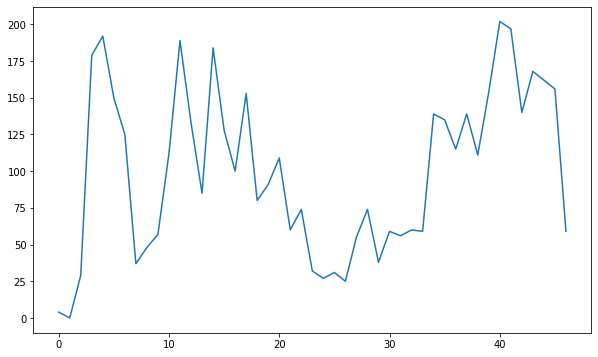

In [28]:
#Visualización del total de productos vendidos por semana
serie = datos.loc[:,['semana','Total']]
serie['Total'].plot()

Teniendo en cuenta la premisa de minimizar el desperdicio alimentario de productos agrícolas nativos, se contemplaron las siguientes alternativas:

- Categorizar los productos en tres grupos: Canasta Básica, Canasta Intermedia y Canasta Premium.  La categorización se realizó mediante la opinión de expertos consutando a varios compradores de insumos en el hogar.


- Agrupar los productos por tipo: Frutas, Verduras, Tubérculos y Granos. 

- Calcular la cantidad de unidades semanales promedio vendidas para cada producto, se tomó como punto de decisión aquellos productos que al menos se venden 1 unidad semanales (aplicando redondeo a entero).

In [31]:
ventas_producto = pd.read_csv("datosAgro_ventas_x_producto.txt",delimiter="\t")
ventas_producto.head(4)

codigo          producto  valor_ventas   ventas_pct  unidades_vendidas  \
0  FRU0046    Tomate Chonto         531550  0,054615528                355   
1  VER0035  Pepino Cohombro         207550  0,021325281                223   
2  VER0016      Champi√±√≥n        1505800  0,154717454                204   
3  VER0028   Lechuga Crespa         271300  0,027875445                174   

  unidades_ventas_pct  unidades_vendidas_sem_prom  
0         0,075339559                           8  
1         0,047325976                           5  
2         0,043293718                           4  
3         0,036926995                           4

Teniendo en cuenta el criterio de unidades promedio vendidas por semana, se obtuvo el siguiente conjunto de datos, el cual contiene el 86% del volumen de ventas (4056/4712) con el 43% de los productos (52/122 productos):

In [32]:
ventas_producto = pd.read_csv("datosAgro_ventas_x_producto_86.txt",delimiter="\t")
ventas_producto.head(4)

semana  FRU0002  FRU0003  FRU0008  FRU0016  FRU0017  FRU0022  FRU0024  \
0  2016-10-30        0        0        0        0        0        0        0   
1  2016-11-06        0        0        0        0        0        0        0   
2  2016-11-13        3        0        1        1        2        0        0   
3  2016-11-20        2        2        4        4        2        3        3   

   FRU0025  FRU0028  ...  VER0033  VER0035  VER0037  VER0038  VER0043  \
0        0        0  ...        0        0        0        0        0   
1        0        0  ...        0        0        0        0        0   
2        0        0  ...        0        0        0        0        0   
3        2        1  ...        1        7        3        9        0   

   VER0049  VER0050  VER0051  VER0052  Total  
0        0        0        0        0      0  
1        0        0        0        0      0  
2        0        1        0        0     13  
3        2        2        1        0    139  

[4 rows x 54 columns]

Se valida si la serie de datos que corresponde al total de ventas semanales es estacional, para lo cual se debe cumplir:  

~ La media no dependa del tiempo  
~ La varianza no dependa del tiempo  
~ La autocorrelacion no dependa del tiempo 

Aparentemente, según el grafico de tendencia, la serie es estacionaria. Para asegurar esta conclusión usamos la prueba de Dickey Fuller 

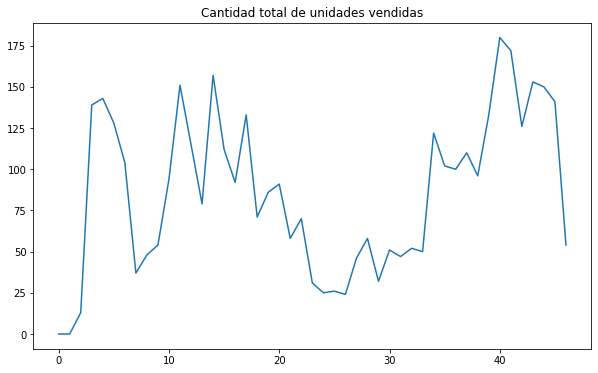

In [33]:
#Construcción data frame con información a analizar

serie = ventas_producto.loc[:,['semana','Total']]
serie['Total'].plot(title="Cantidad total de unidades vendidas", legend=False)

Text(0.5, 0, 'semana')

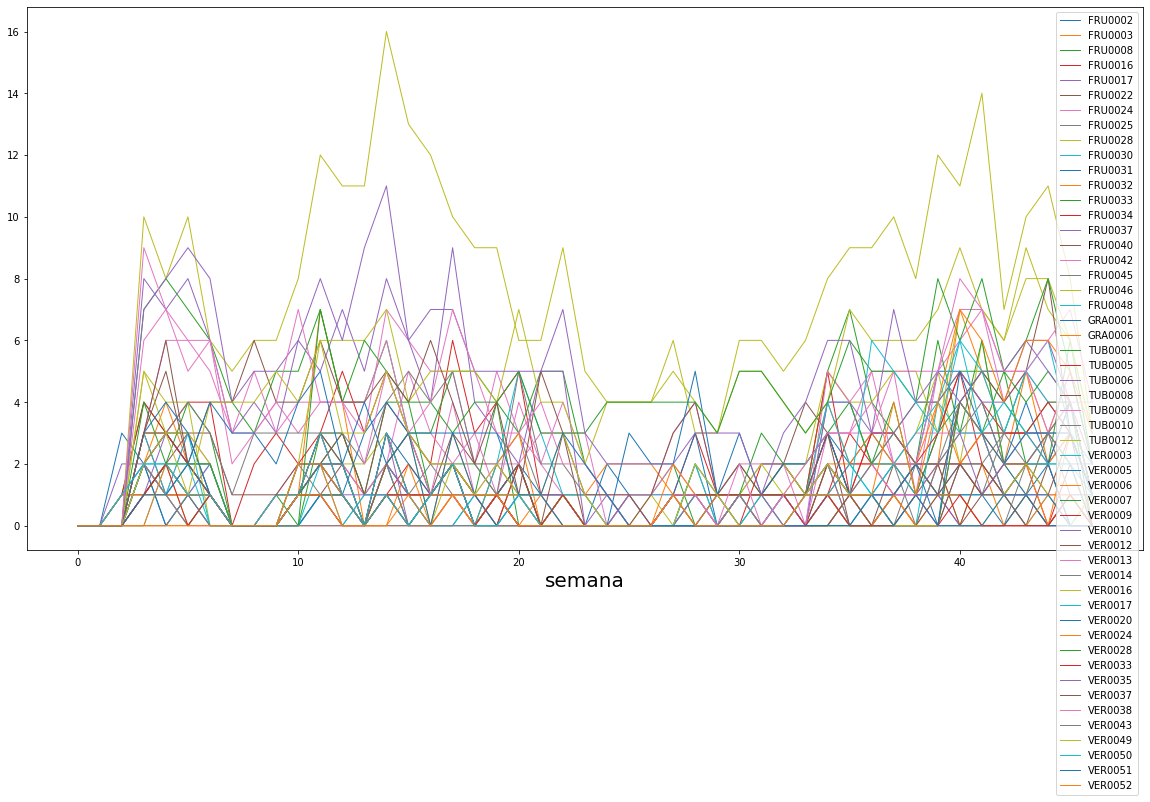

In [34]:
g = ventas_producto.iloc[:, 0:-1] 
g.plot(figsize=(20,10), linewidth=1, fontsize=10)
plt.xlabel('semana', fontsize=20)
#plt.legend(bbox_to_anchor=(0,1.02),loc="lower left", borderaxespad=0.)

In [35]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(serie['Total'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.228528
p-value: 0.018392
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


Con el resultado de la prueba (p-vaue = 0.018) se puede afirmar que la serie de tiempo es estacional. A continuación analizaremos las gráficas de autocorrelación para entender los componentes de autoregresión y promedio móvil.

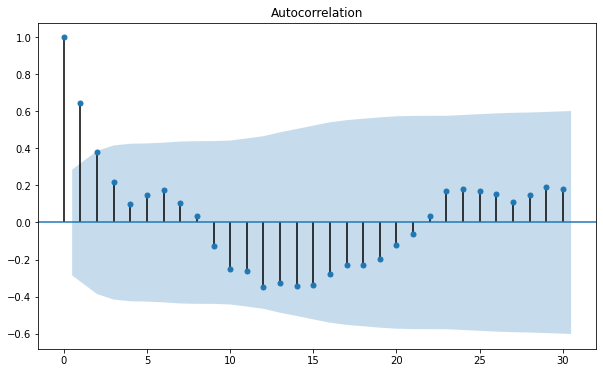

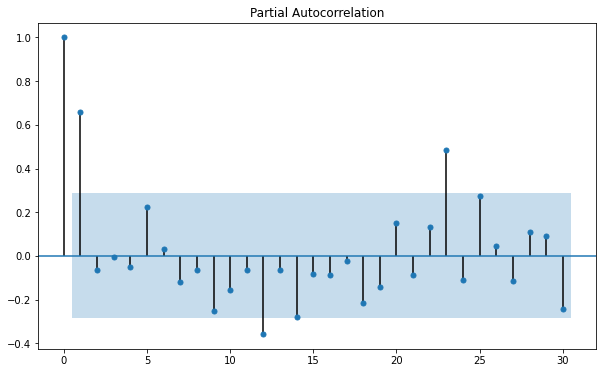

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(serie['Total'], lags=30);
plot_pacf(serie['Total'], lags=30);

De la grafica de autocorrelación podemos concluir que hay un proceso estacional, aunque no se puede determinar con certeza la periodicidad.

## Prophet

A continuación se usa Prophet para realizar el pronostico de ventas por producto:

In [37]:
df_unitario = ventas_producto.iloc[:,[0,1]].copy()
df_unitario.head(4)

semana  FRU0002
0  2016-10-30        0
1  2016-11-06        0
2  2016-11-13        3
3  2016-11-20        2

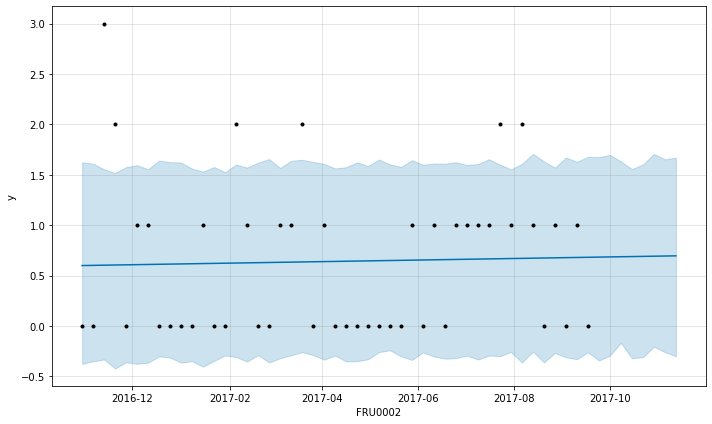

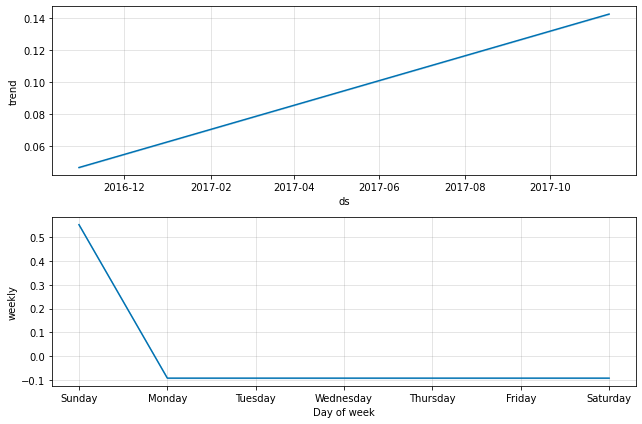

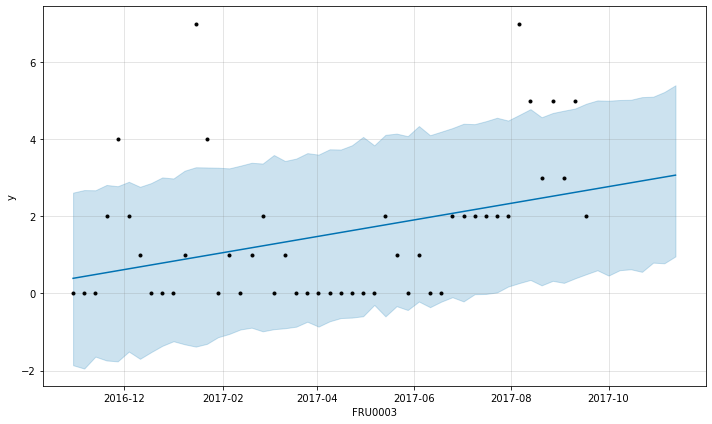

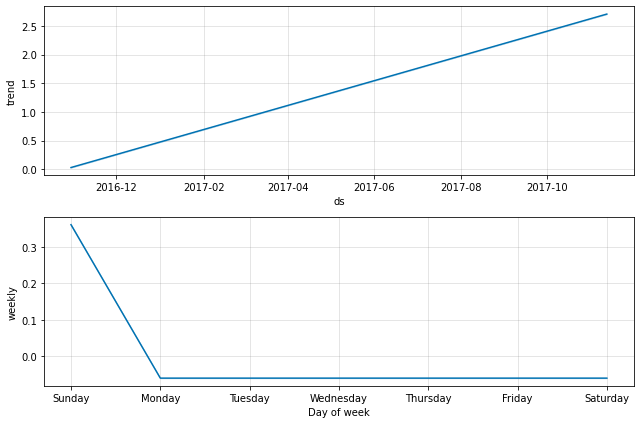

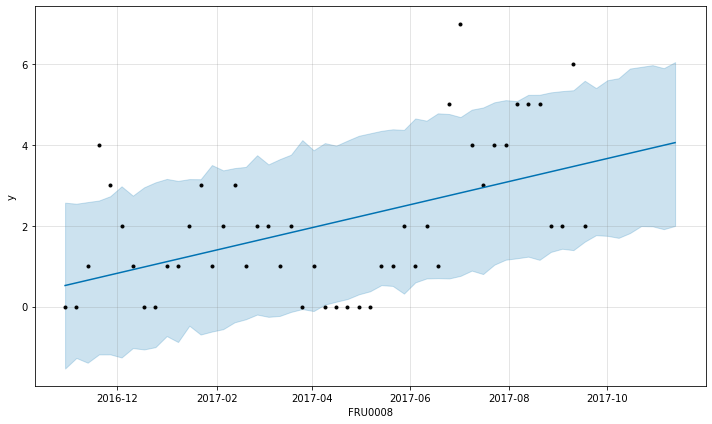

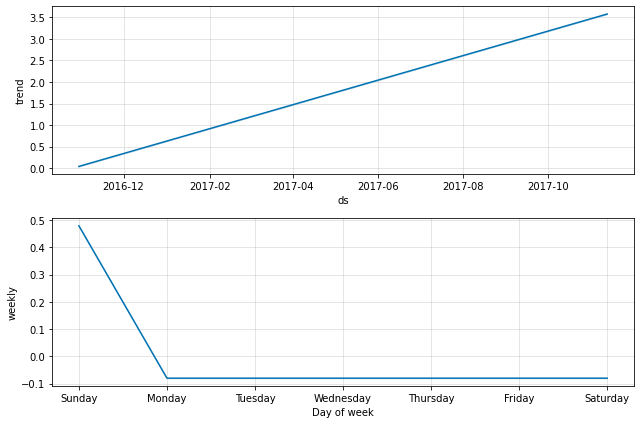

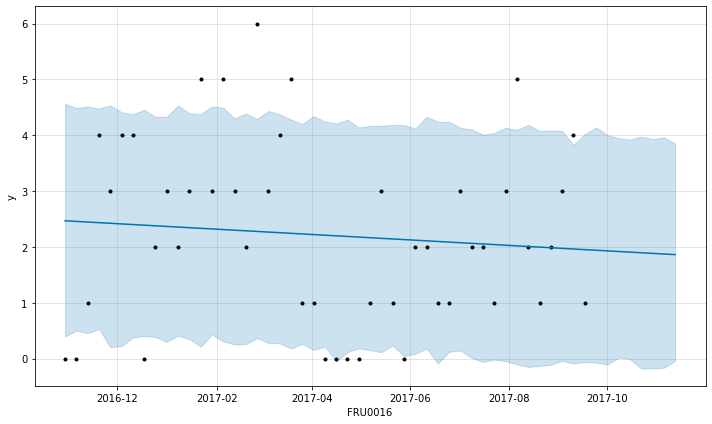

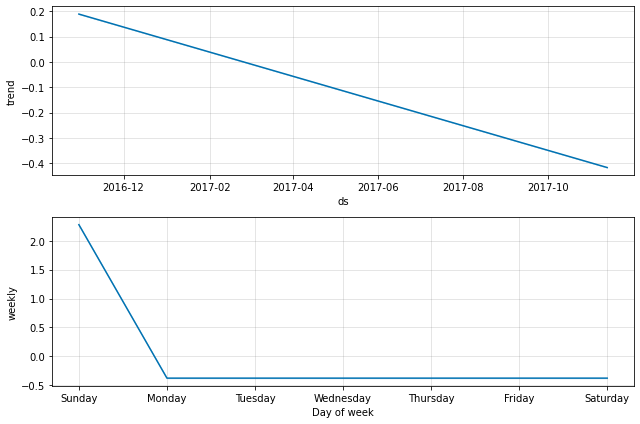

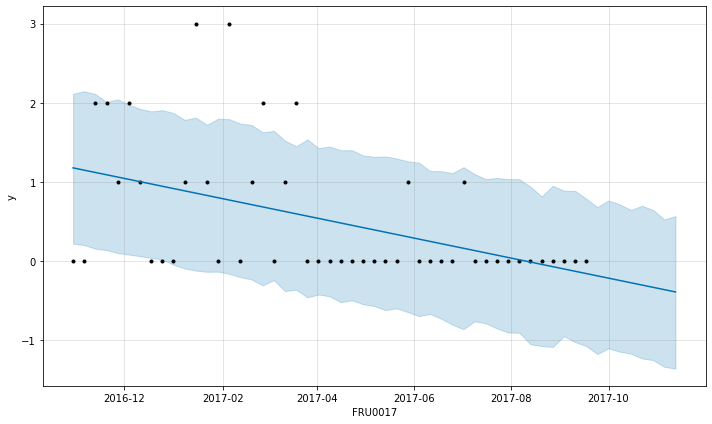

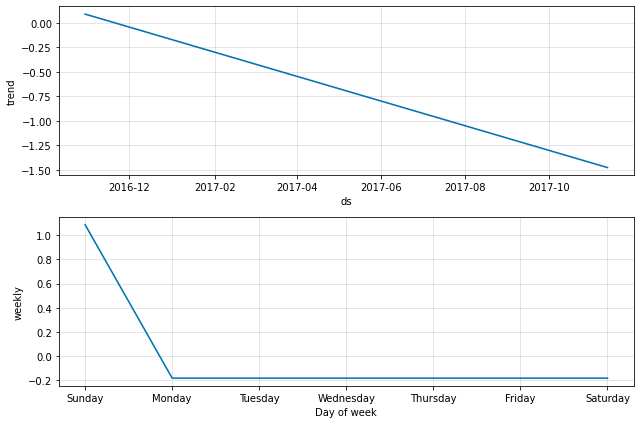

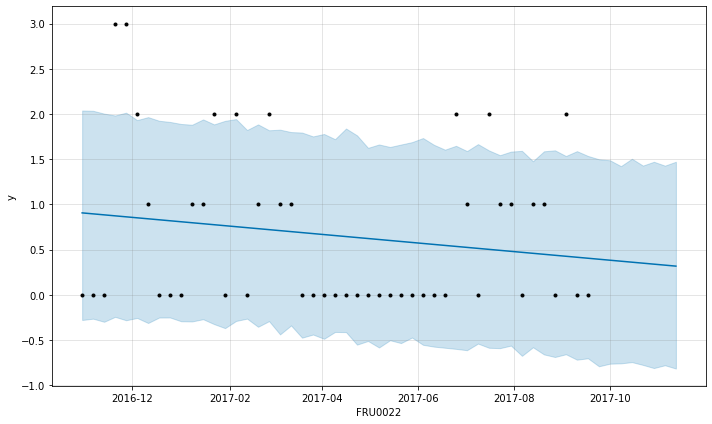

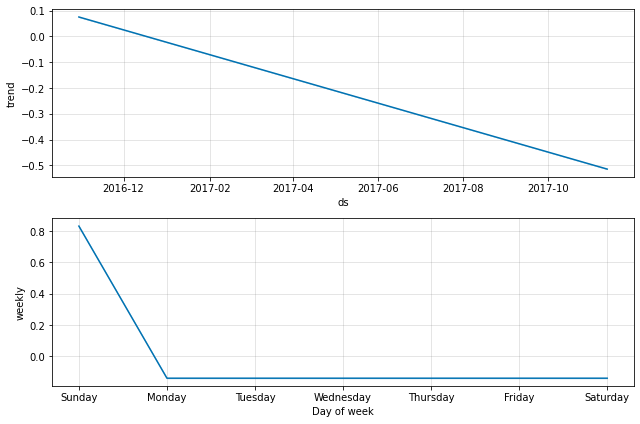

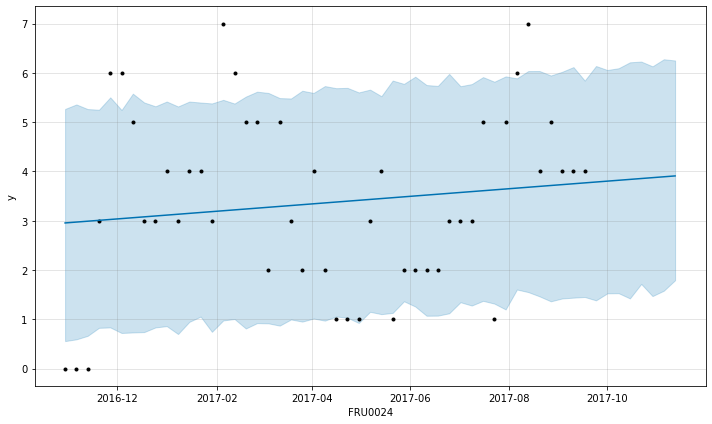

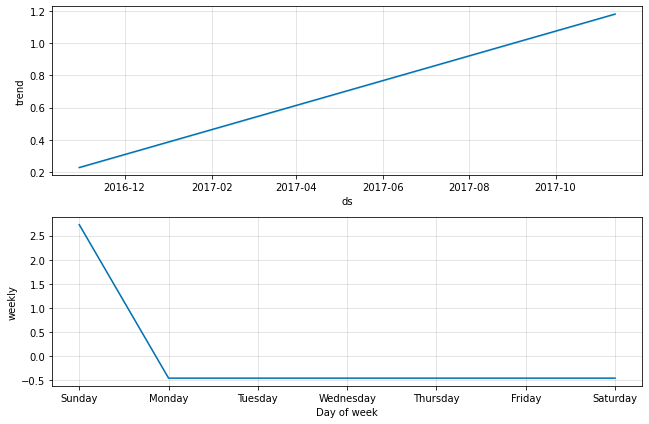

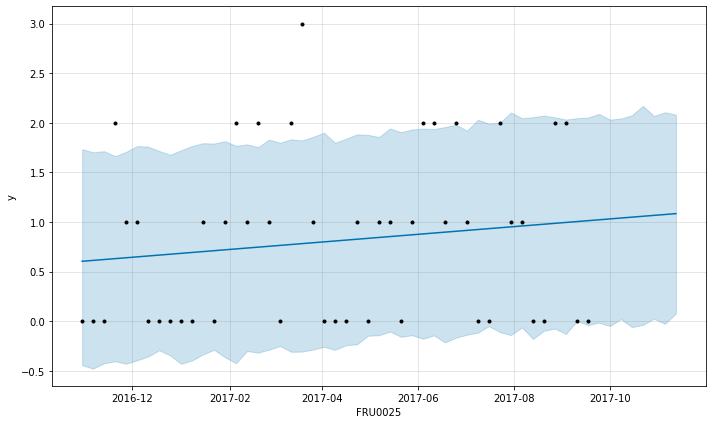

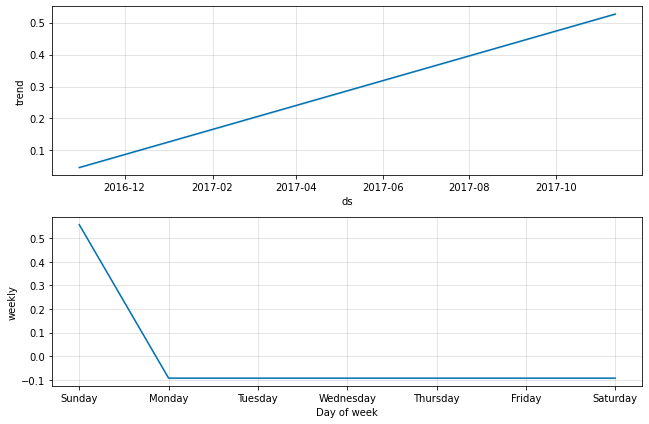

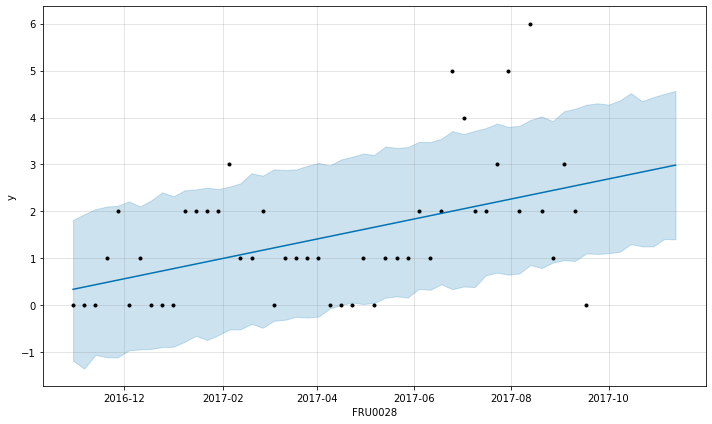

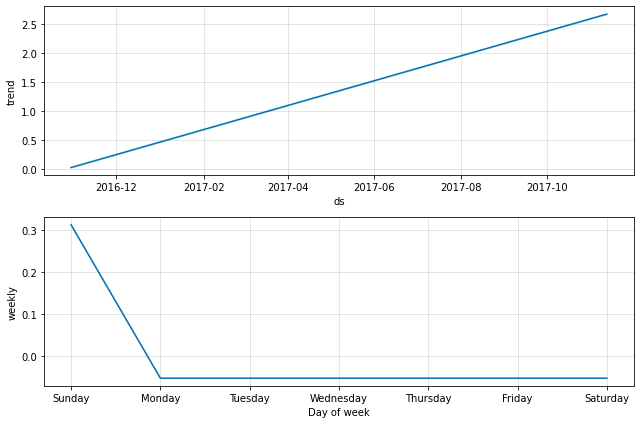

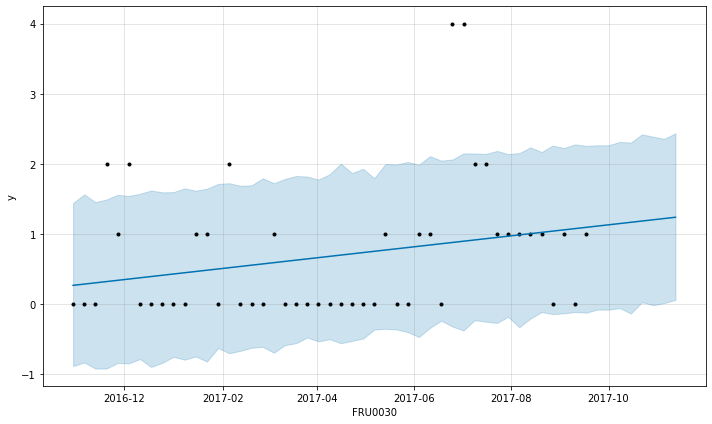

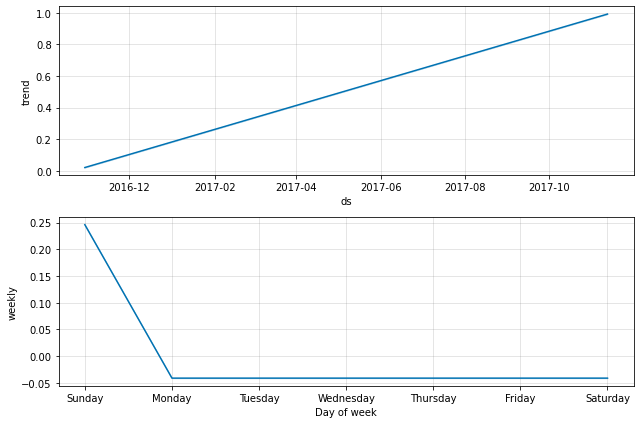

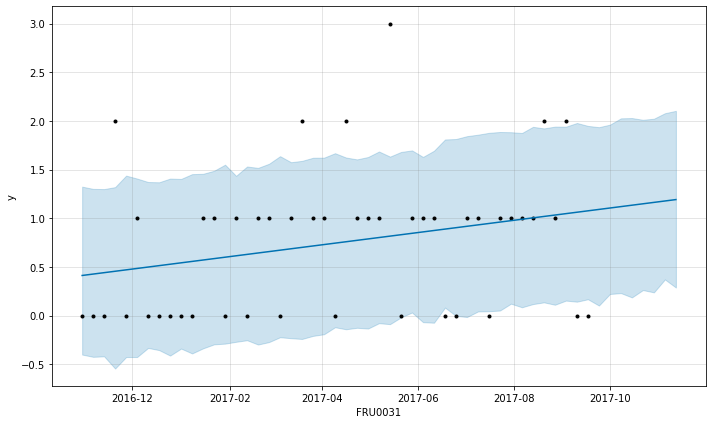

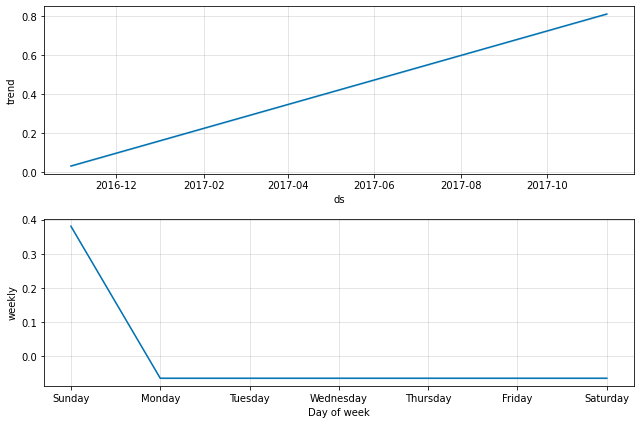

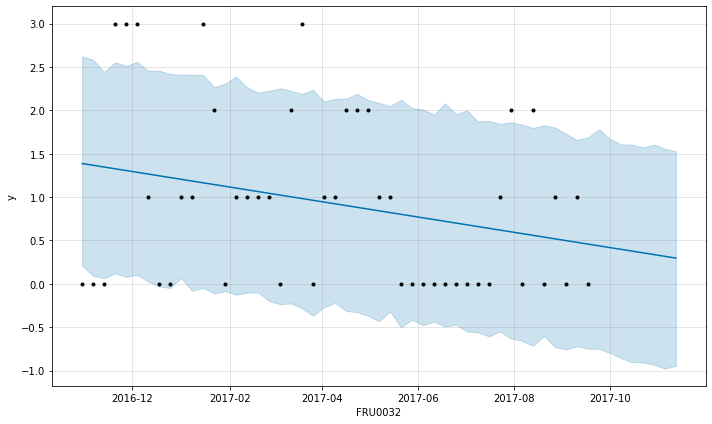

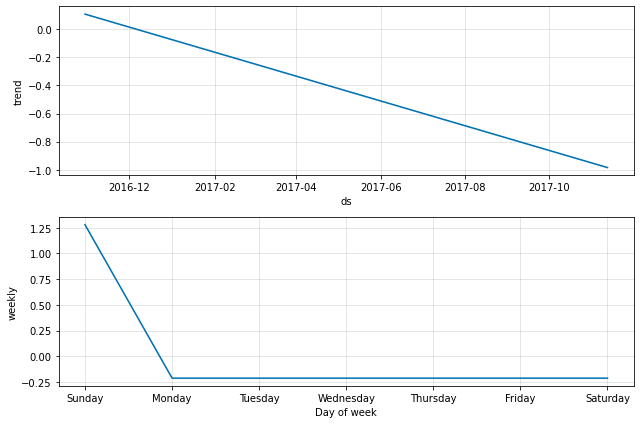

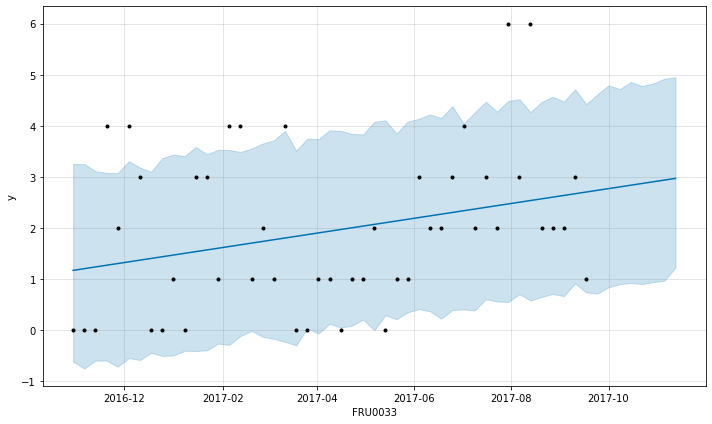

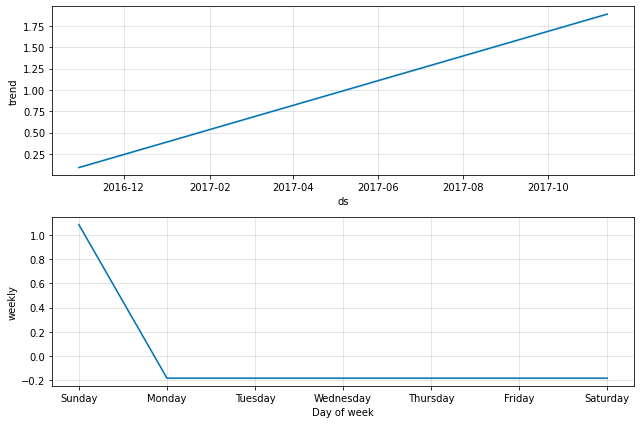

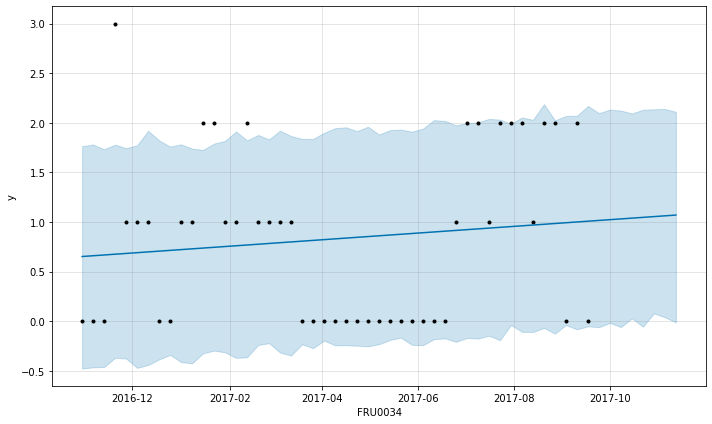

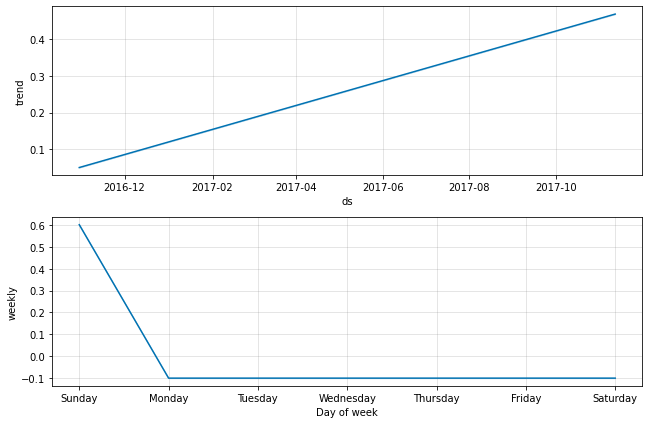

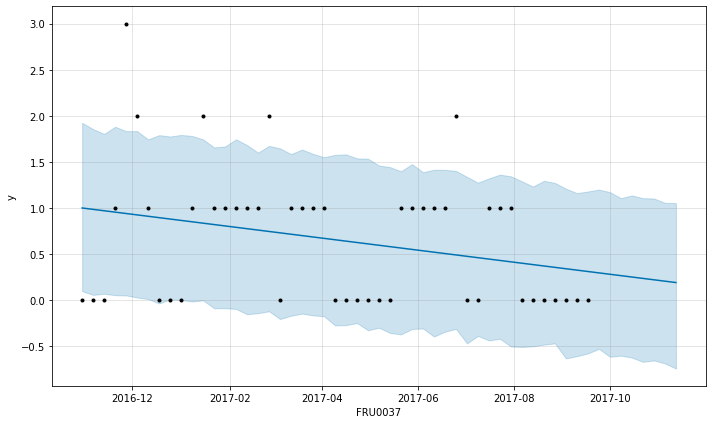

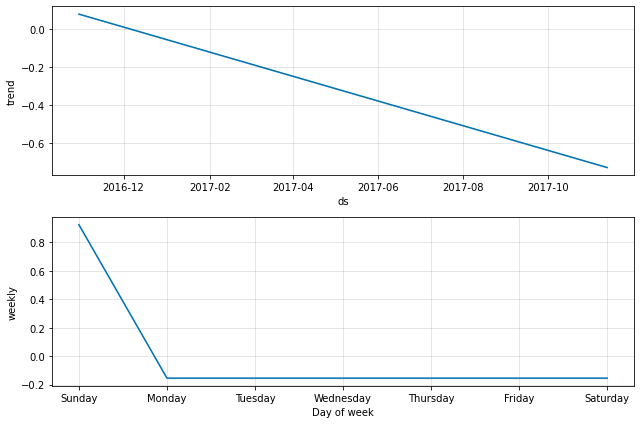

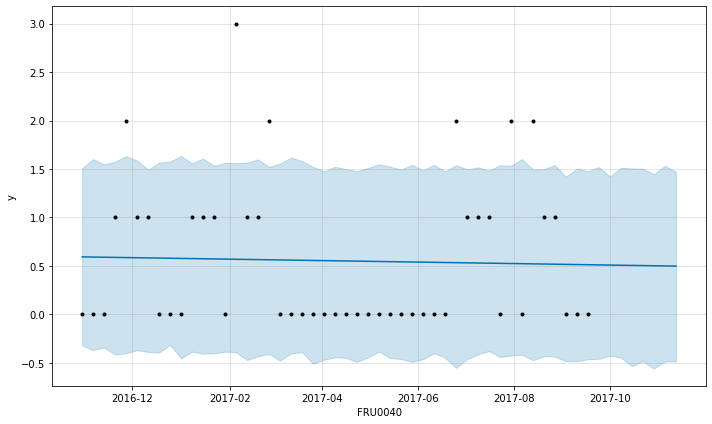

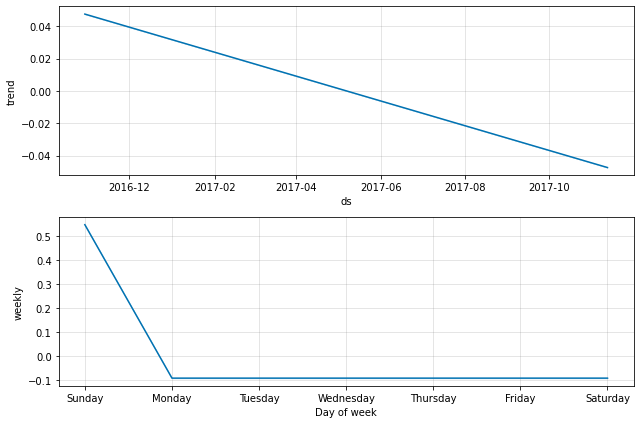

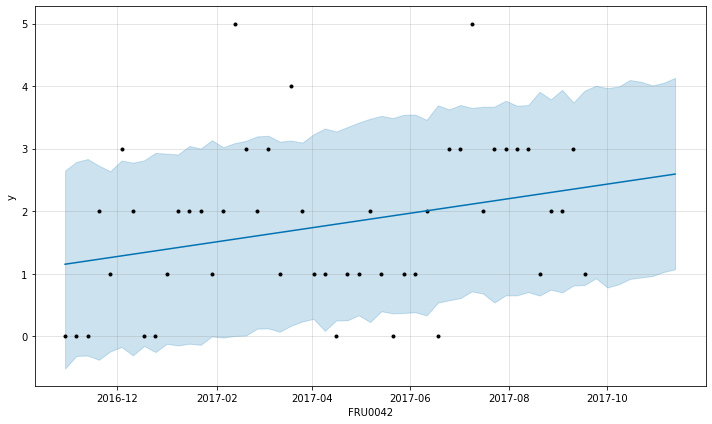

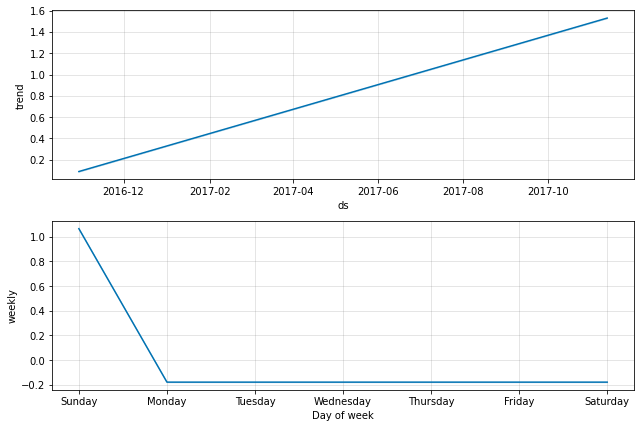

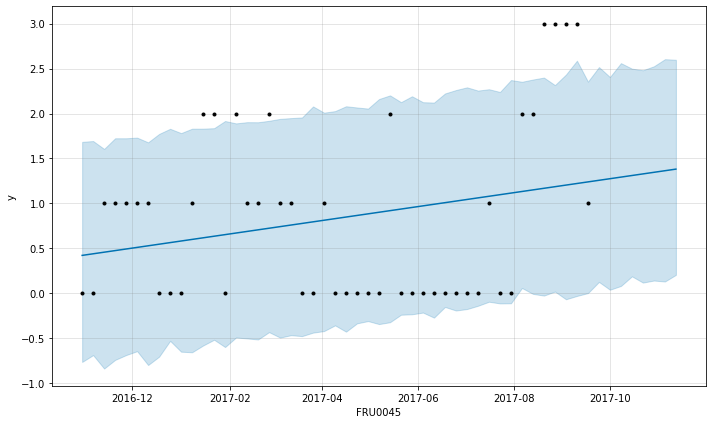

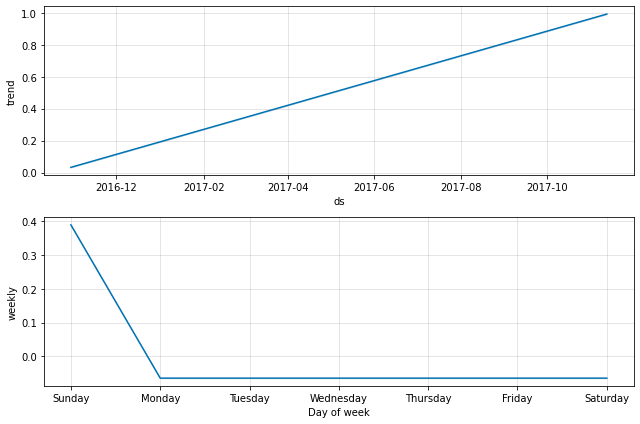

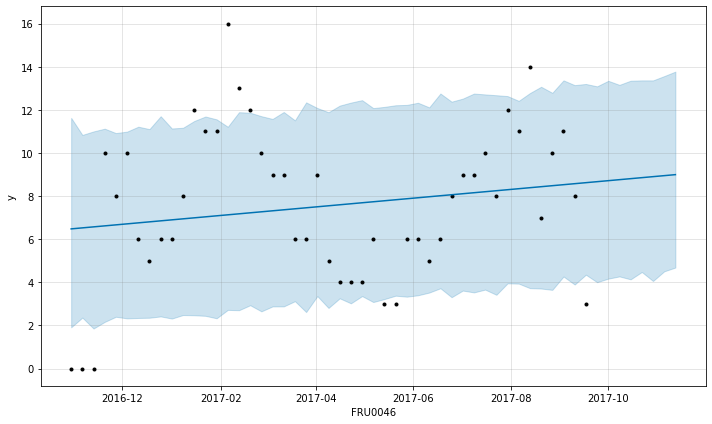

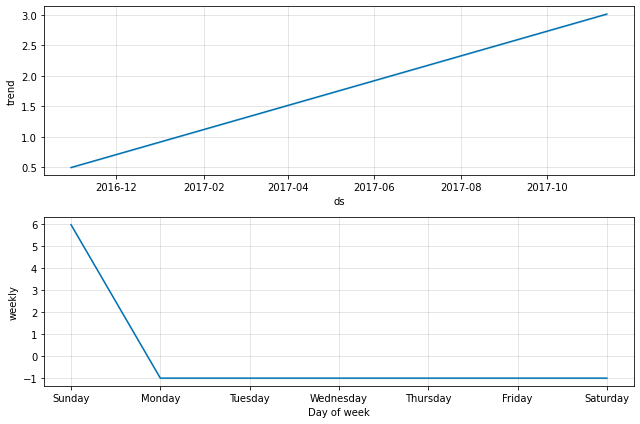

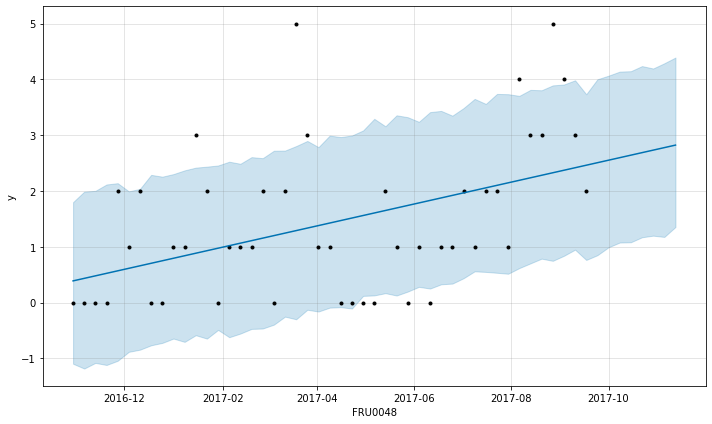

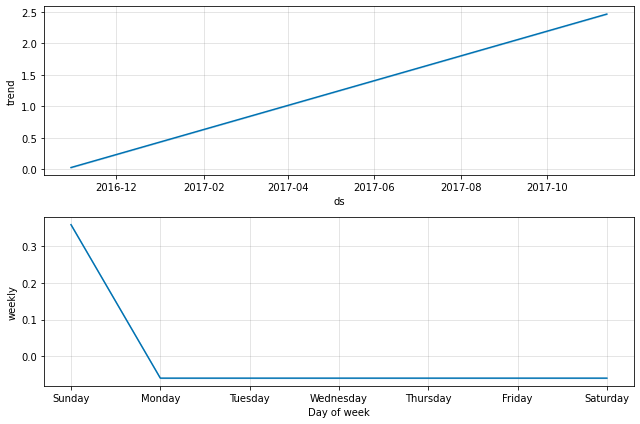

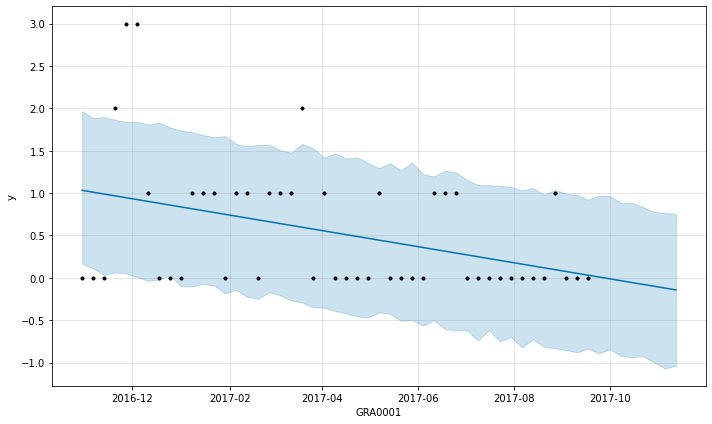

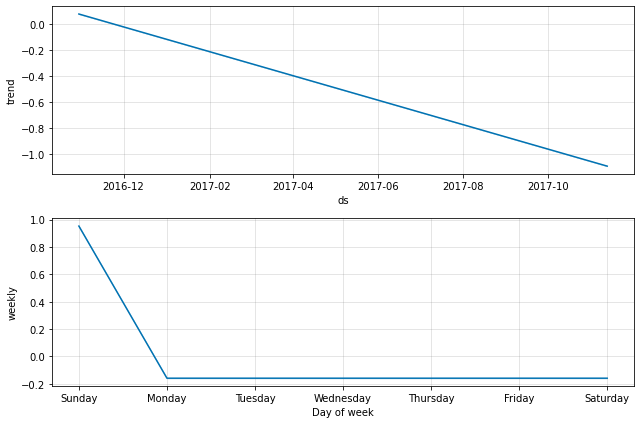

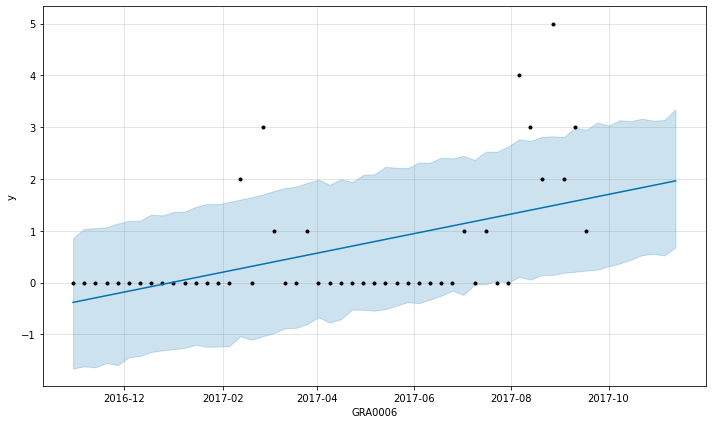

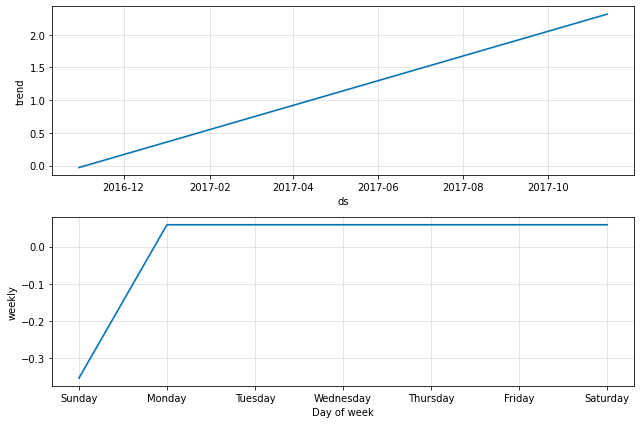

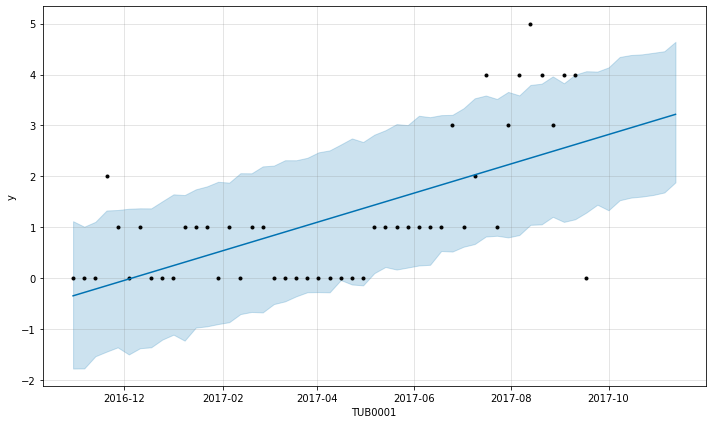

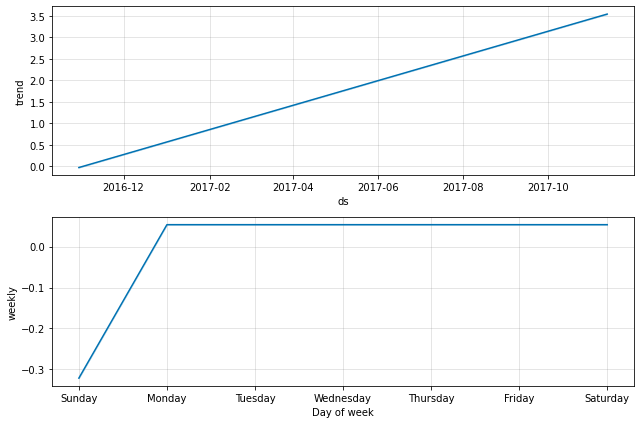

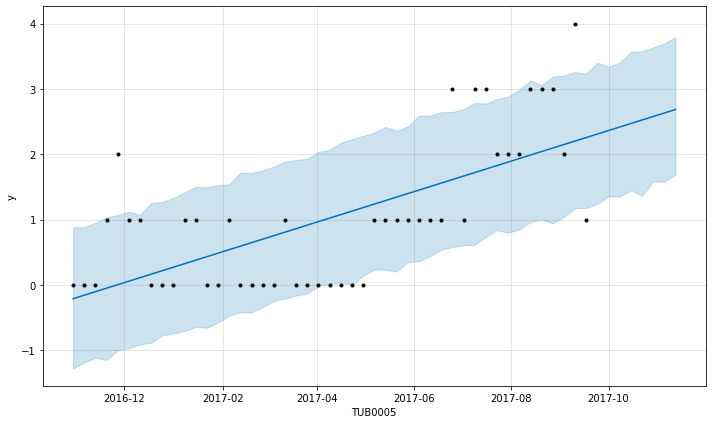

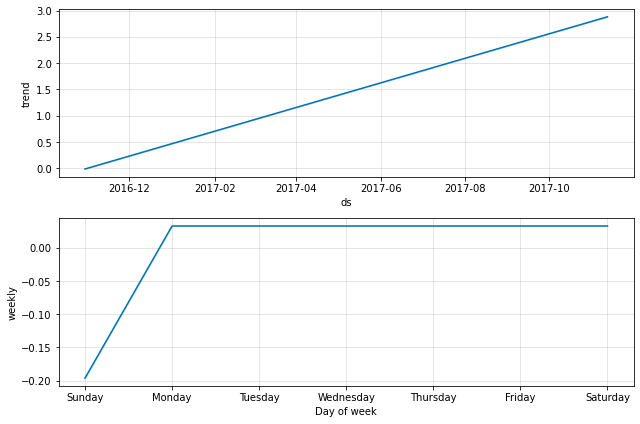

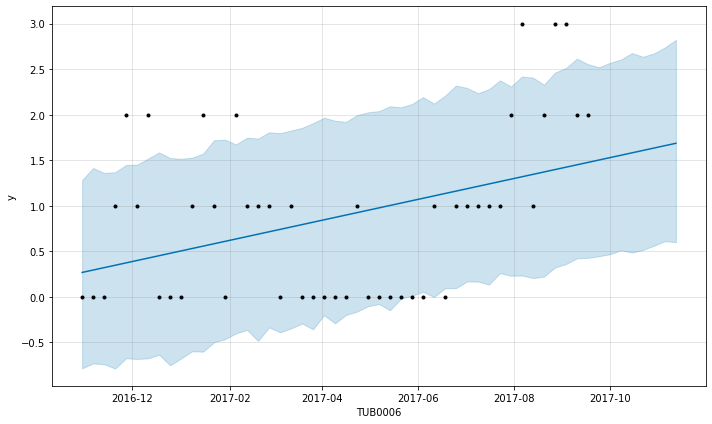

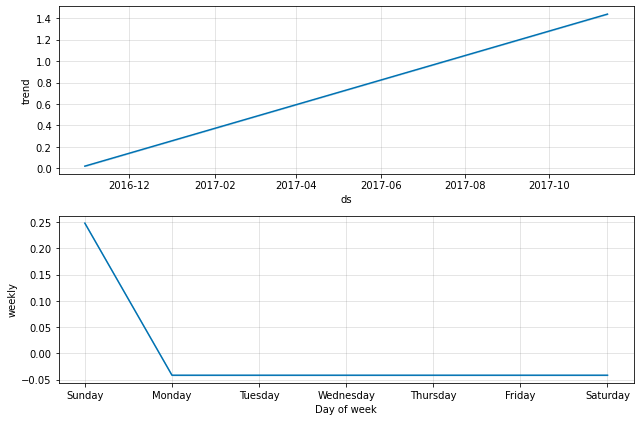

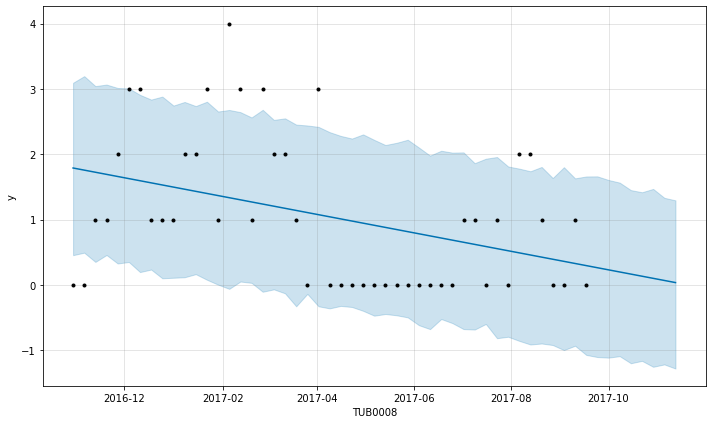

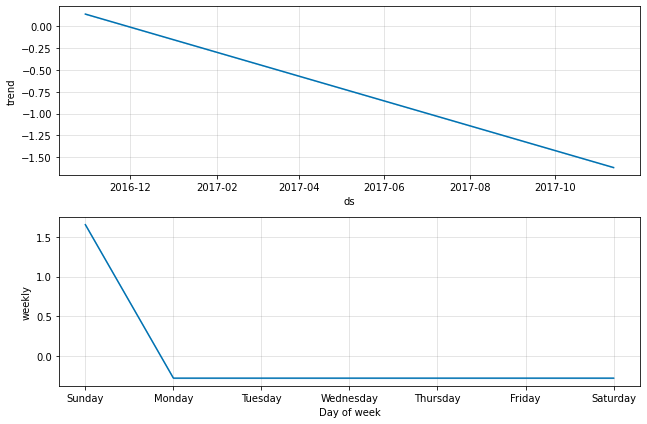

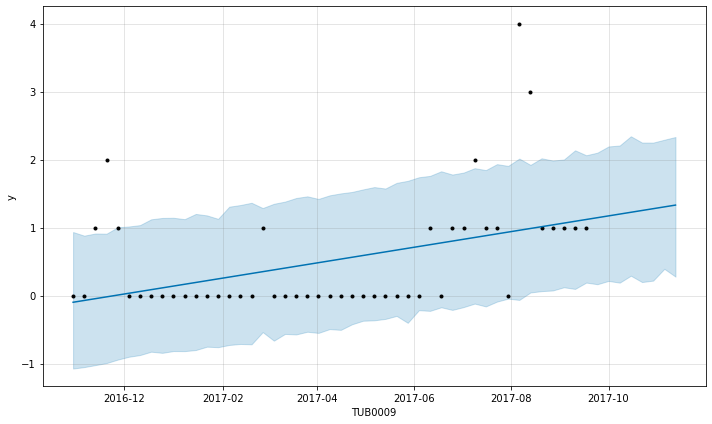

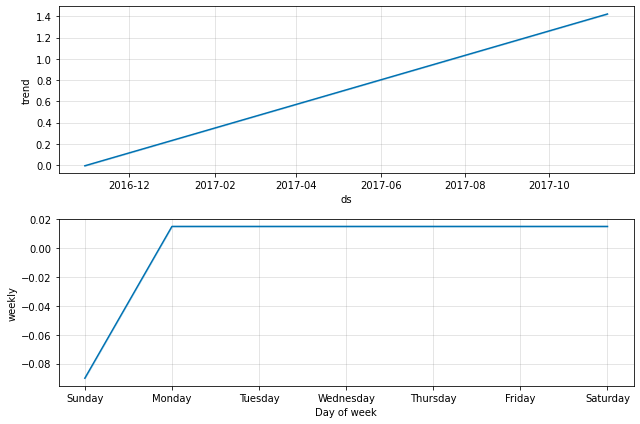

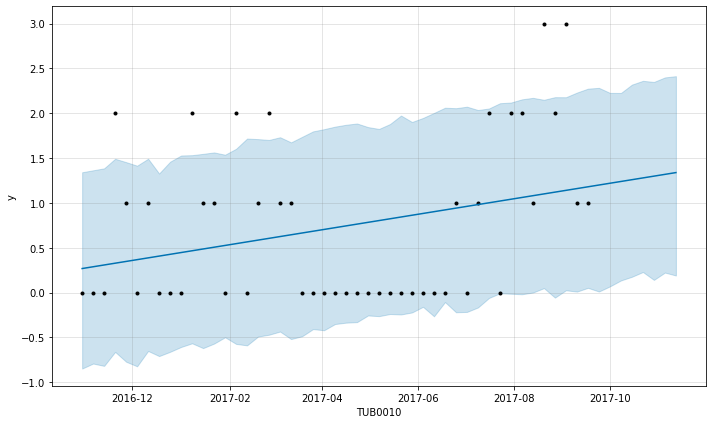

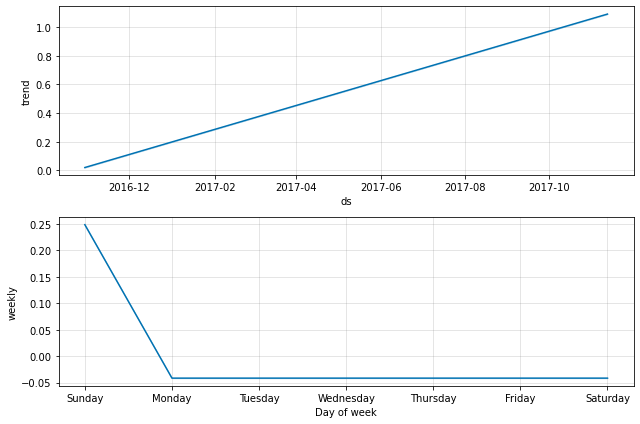

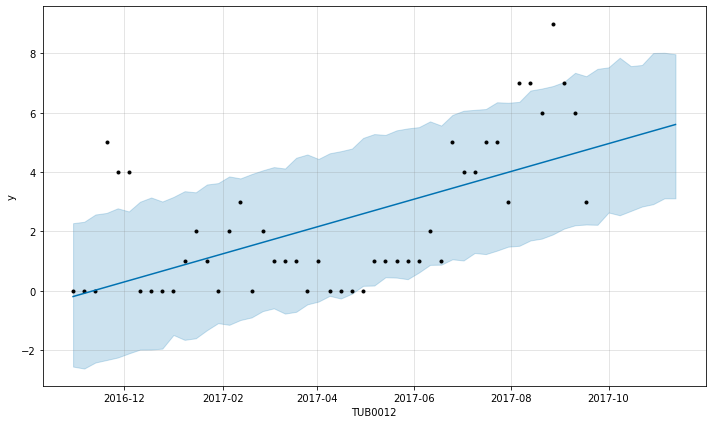

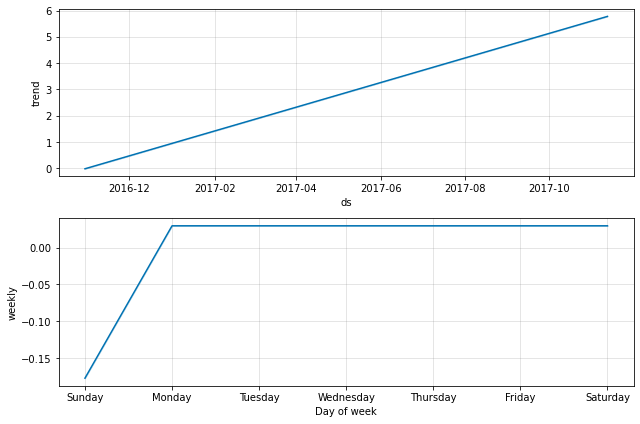

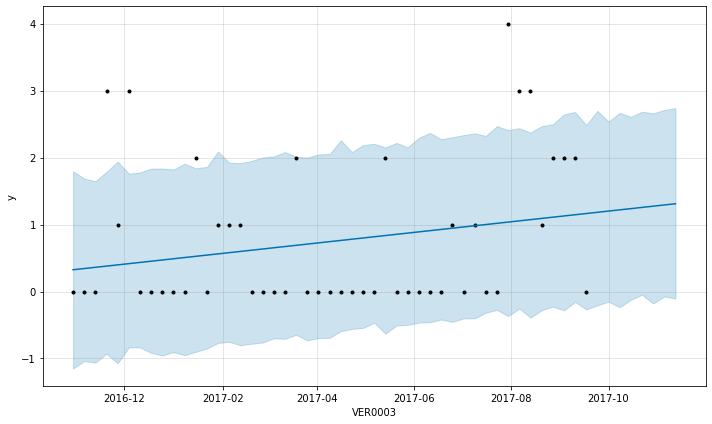

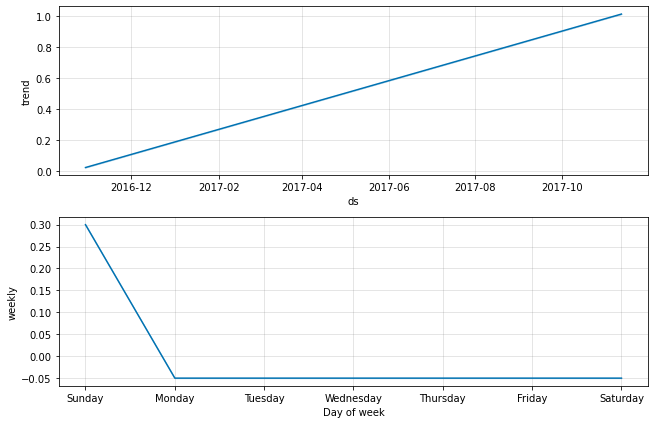

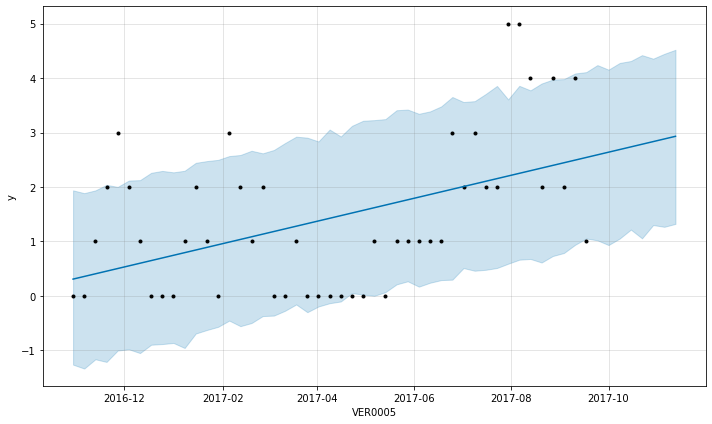

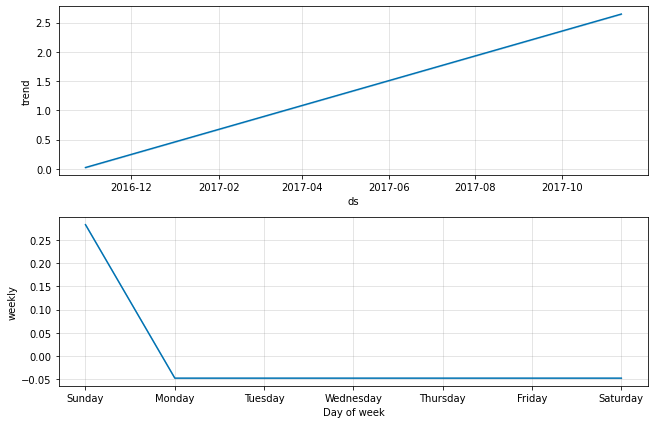

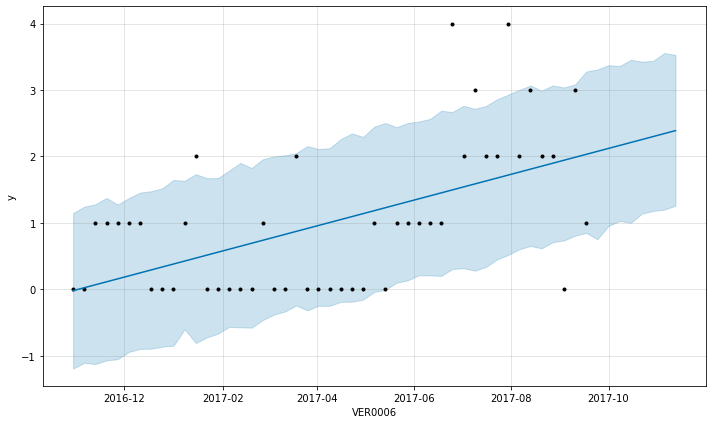

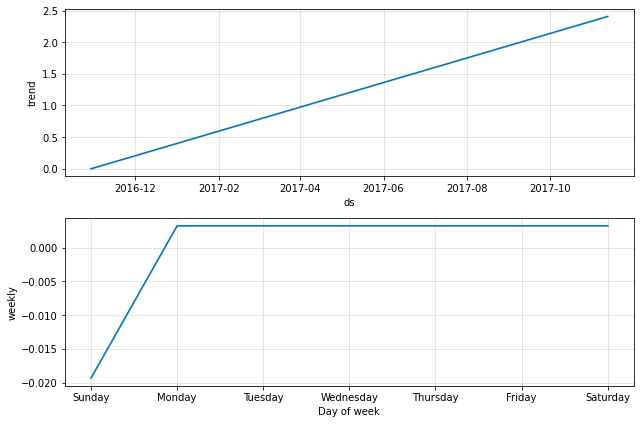

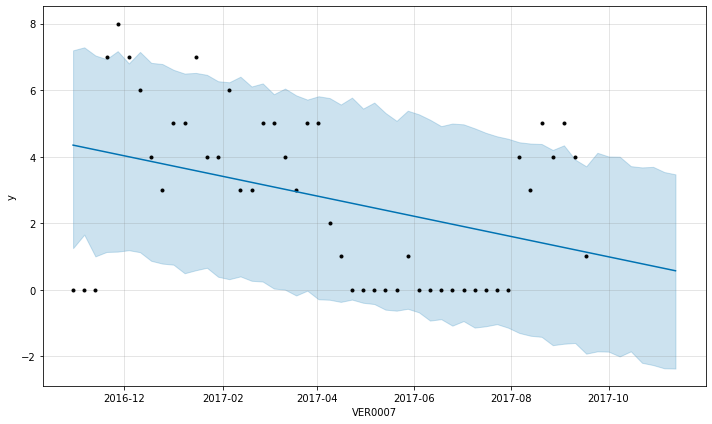

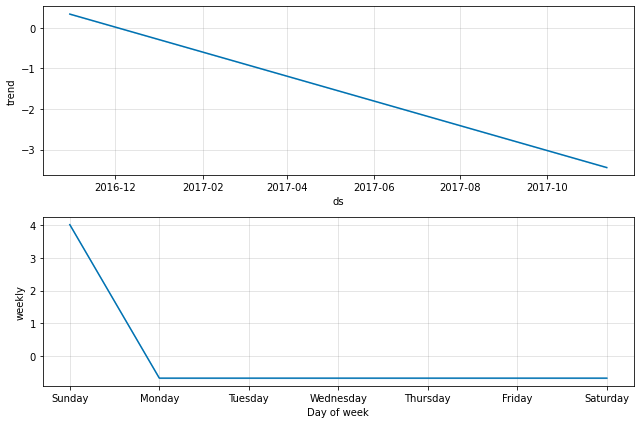

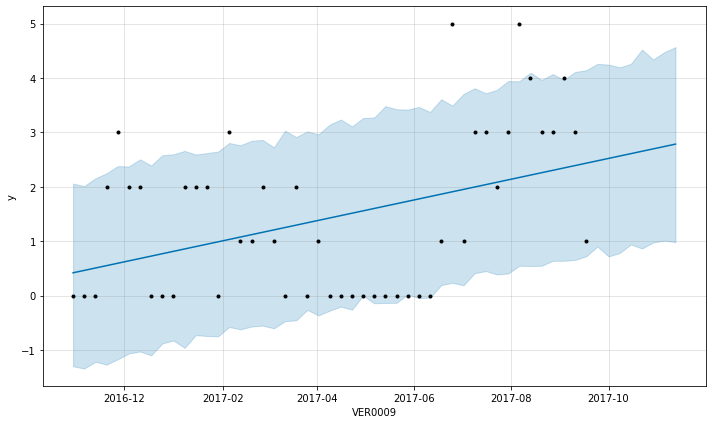

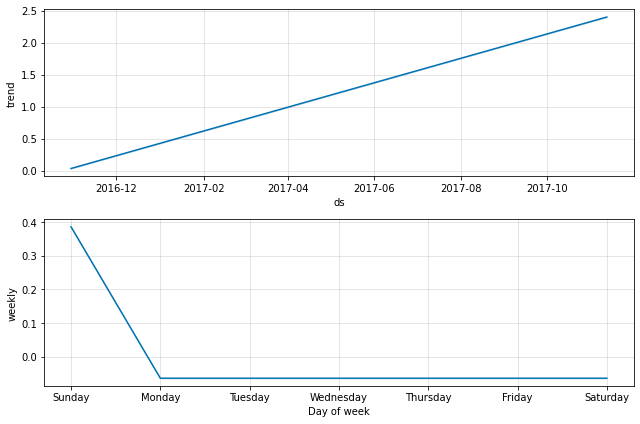

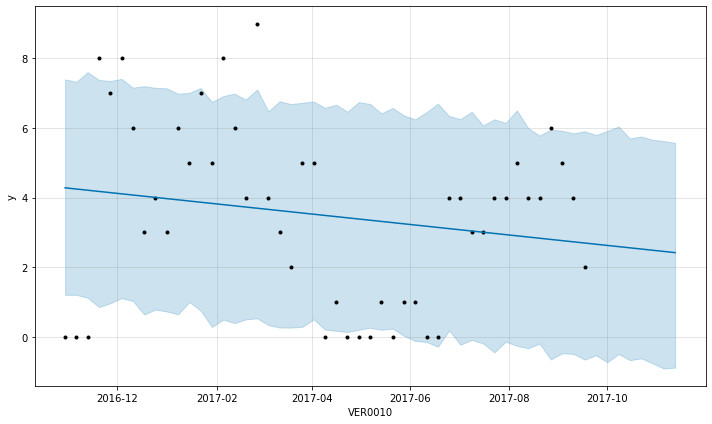

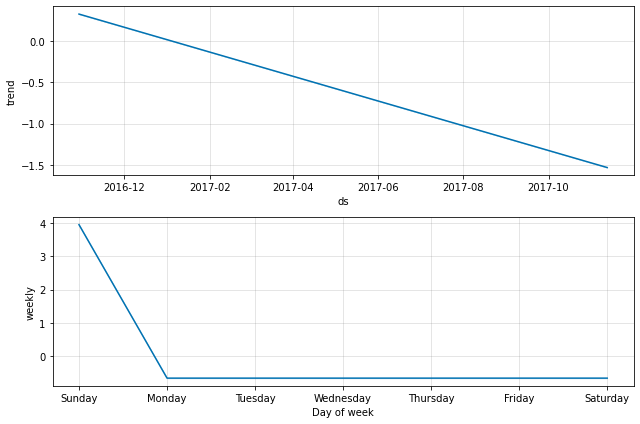

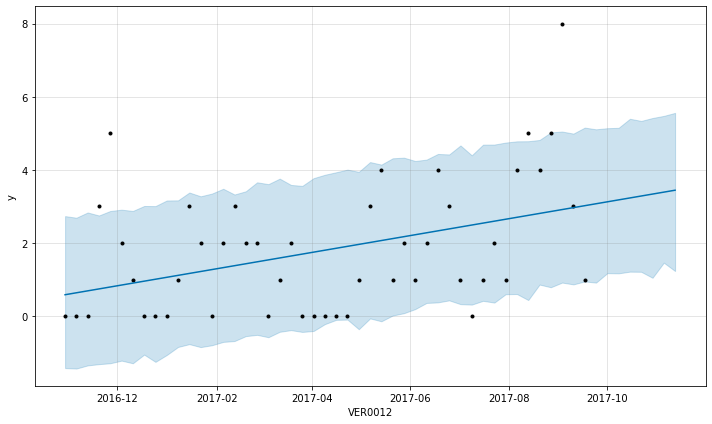

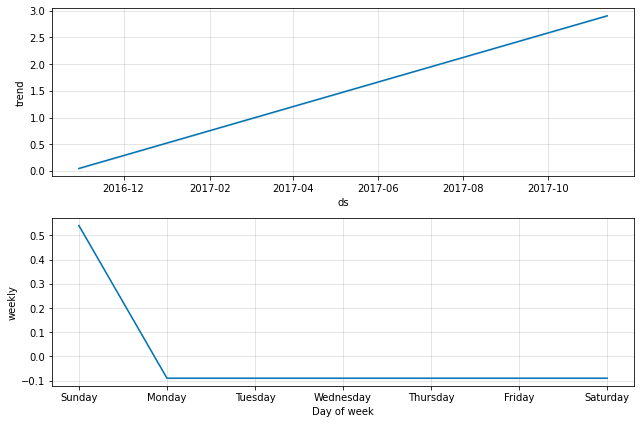

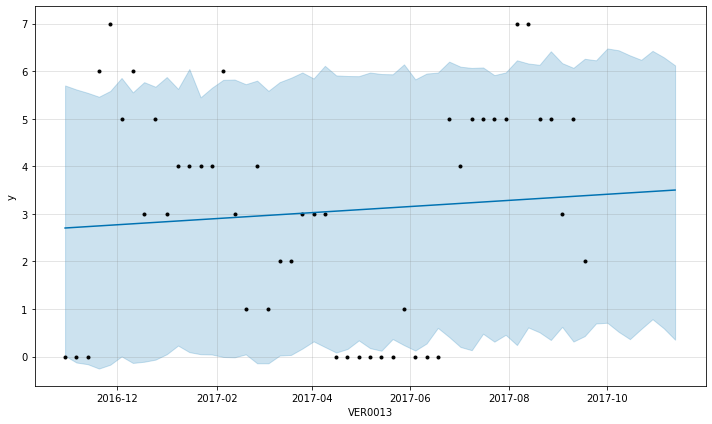

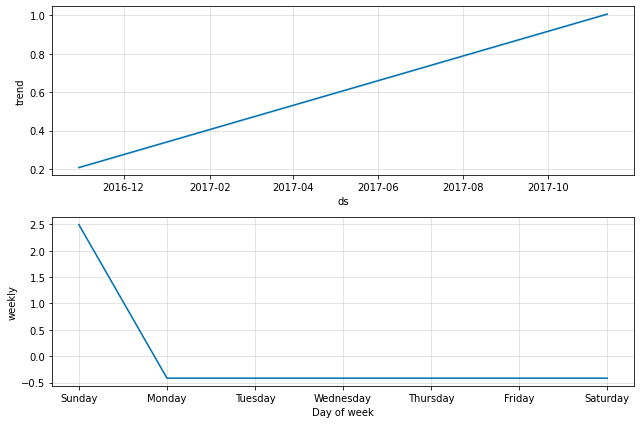

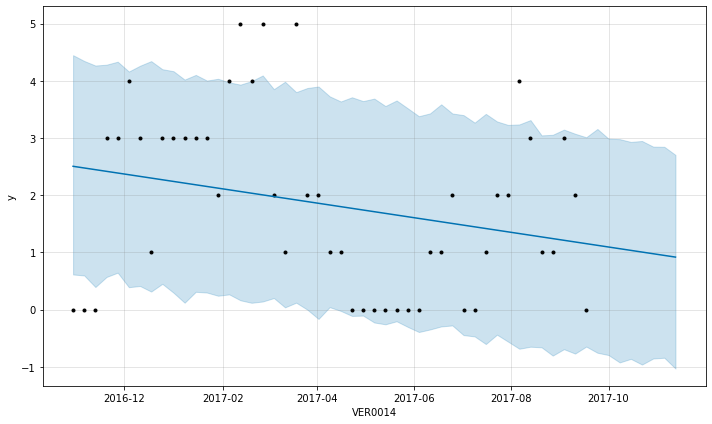

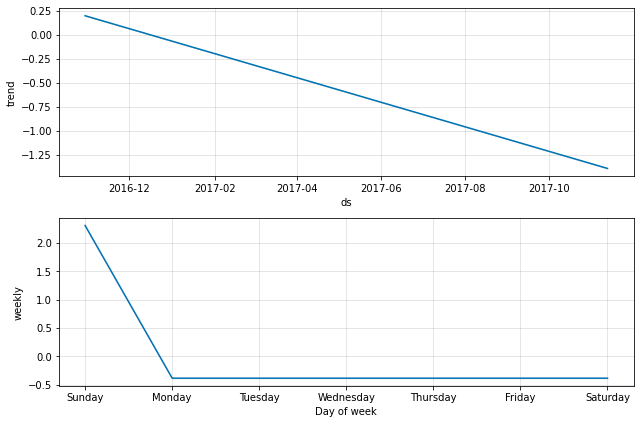

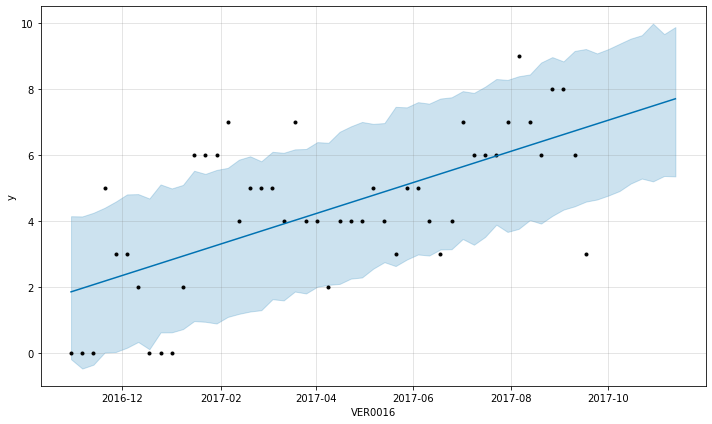

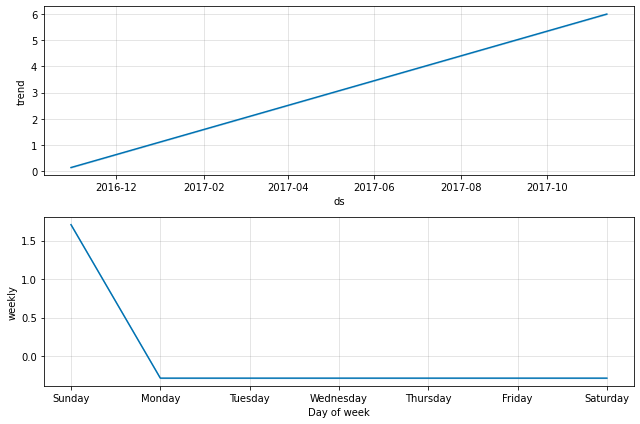

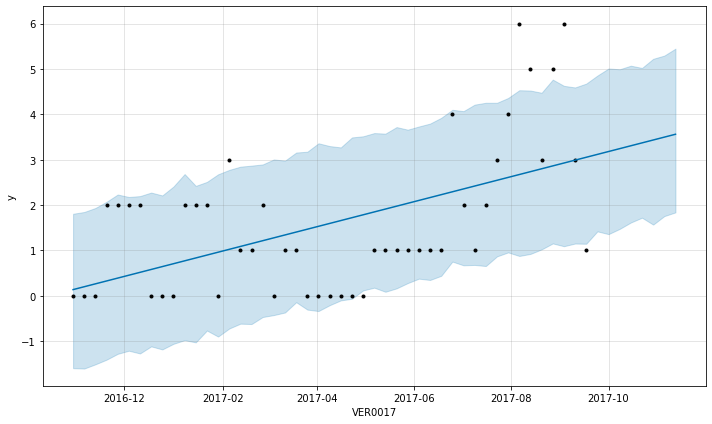

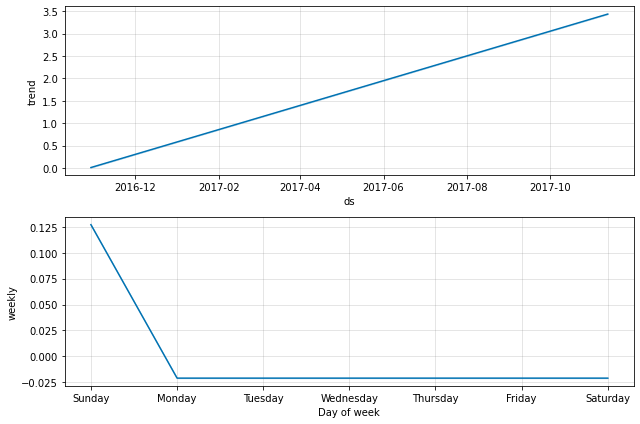

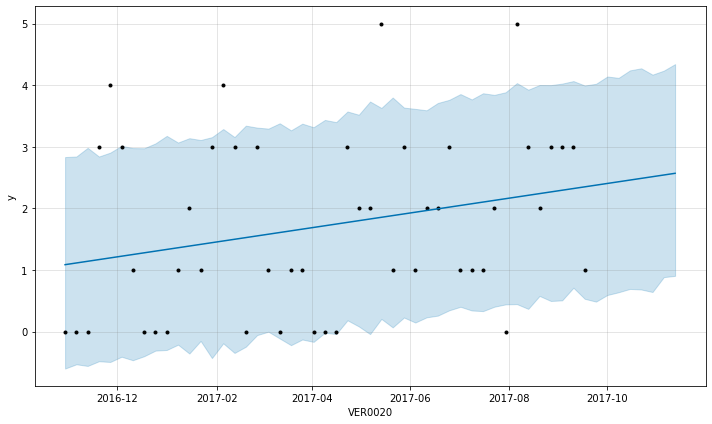

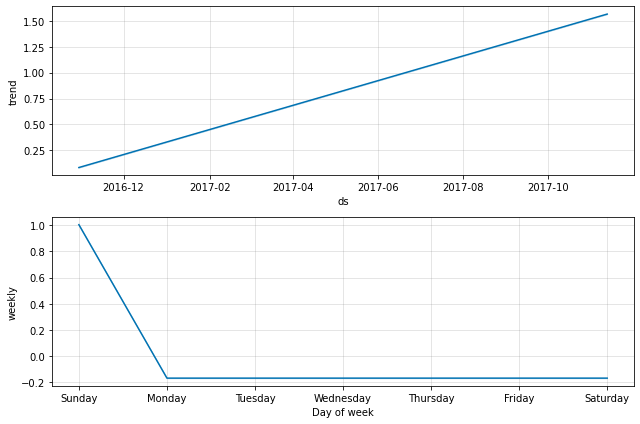

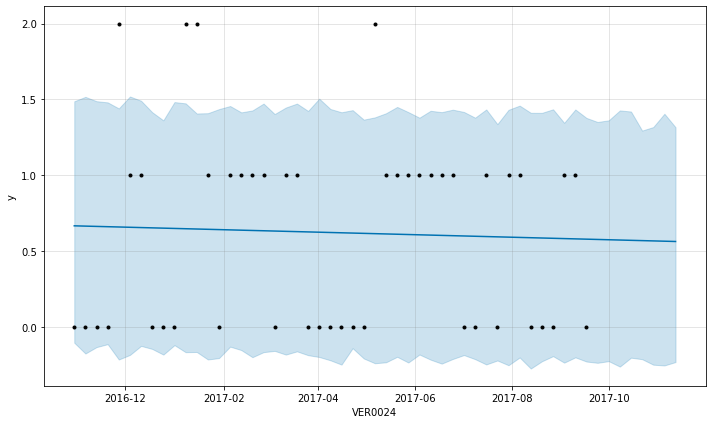

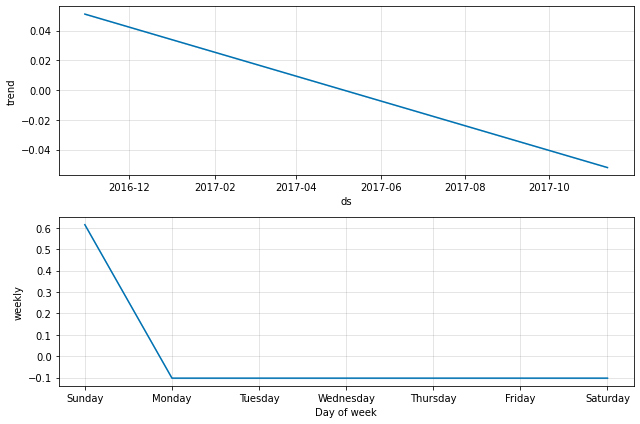

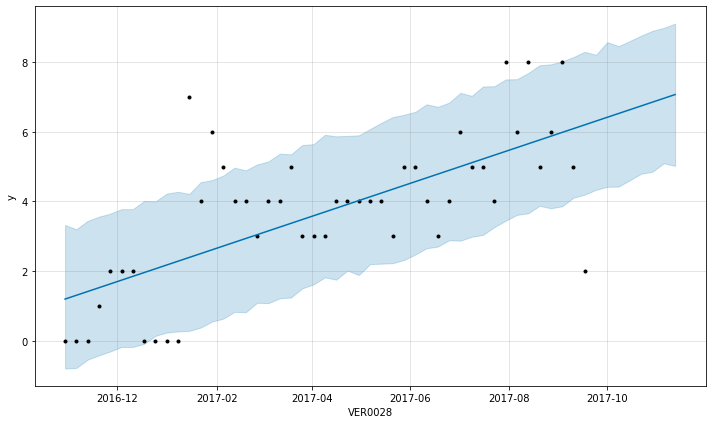

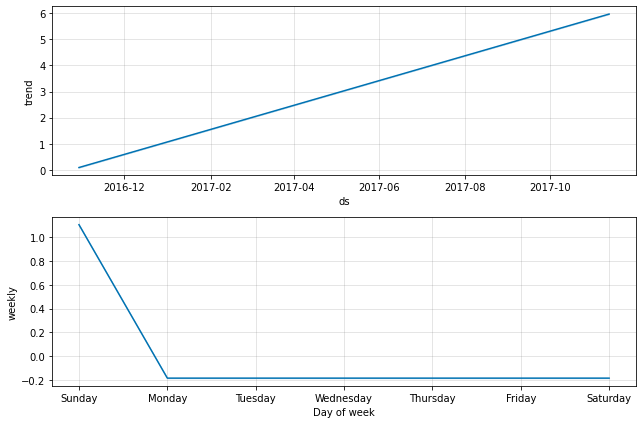

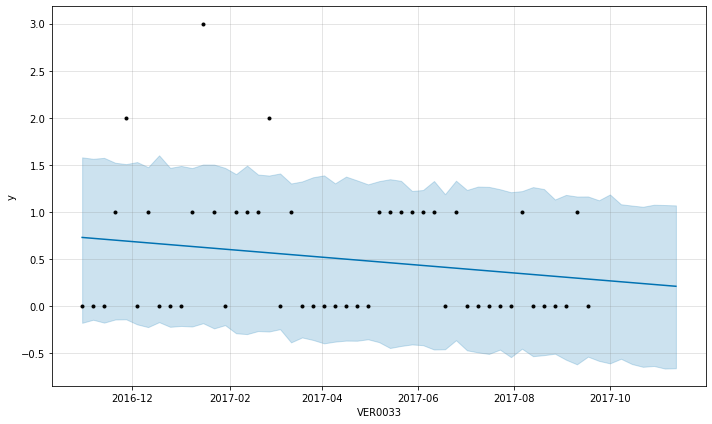

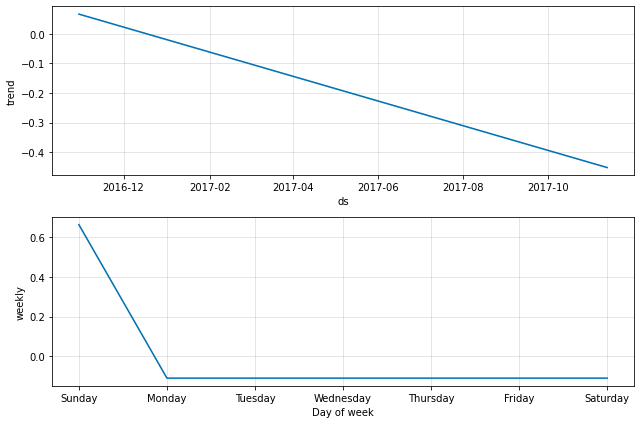

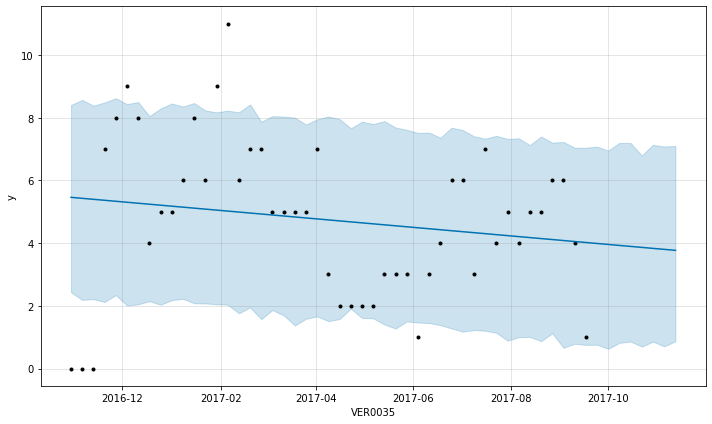

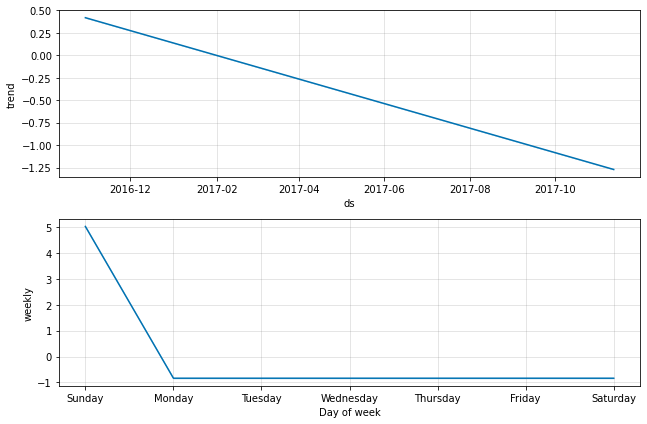

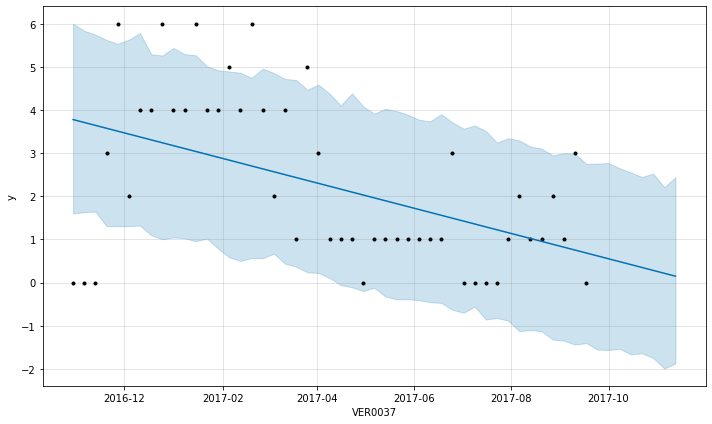

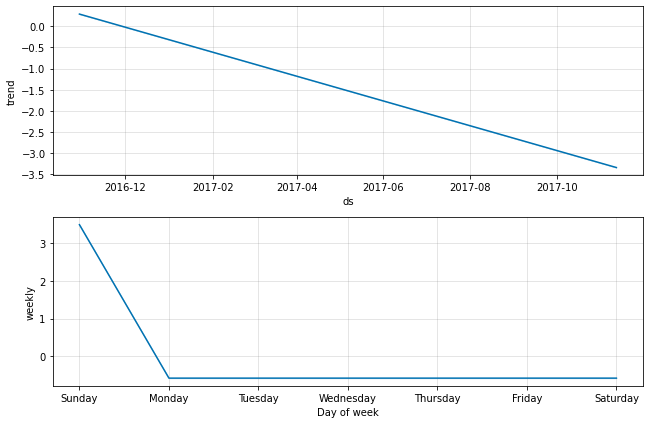

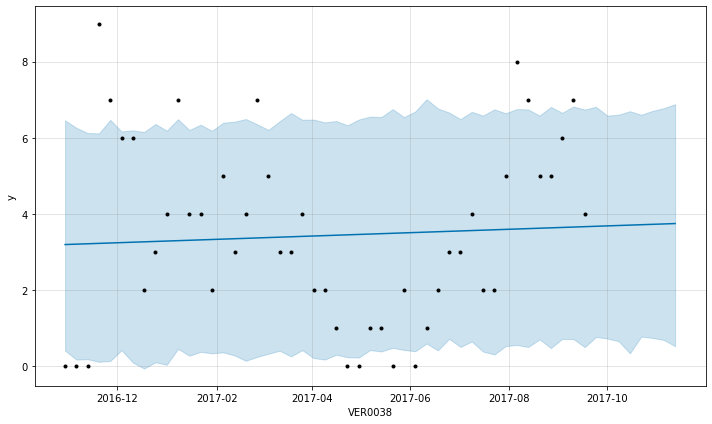

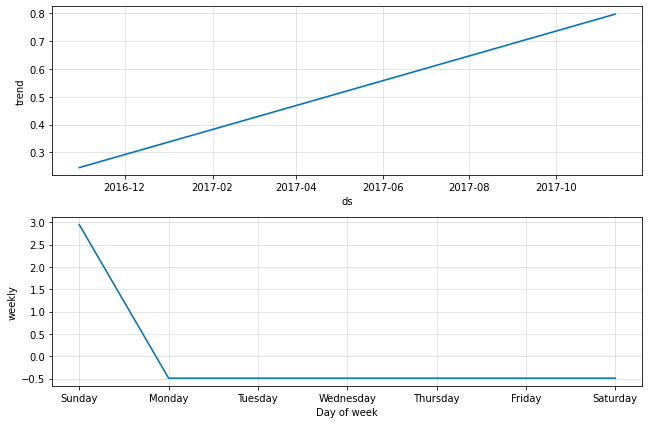

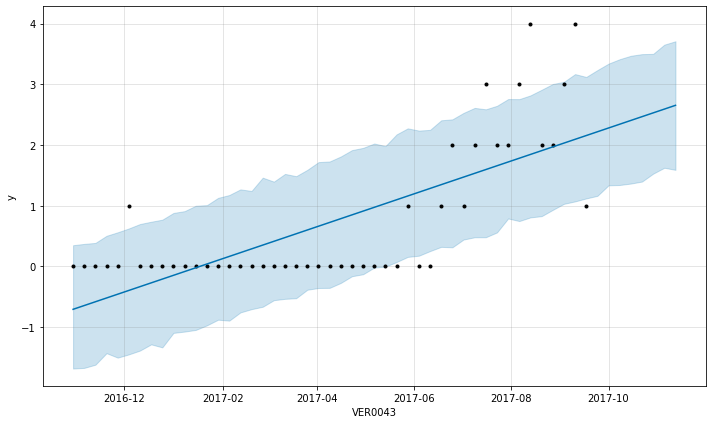

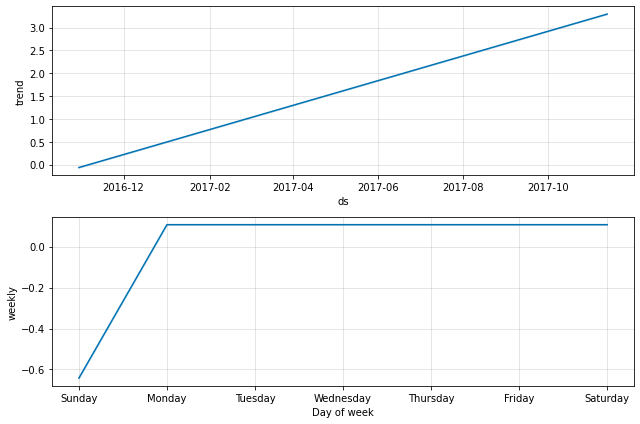

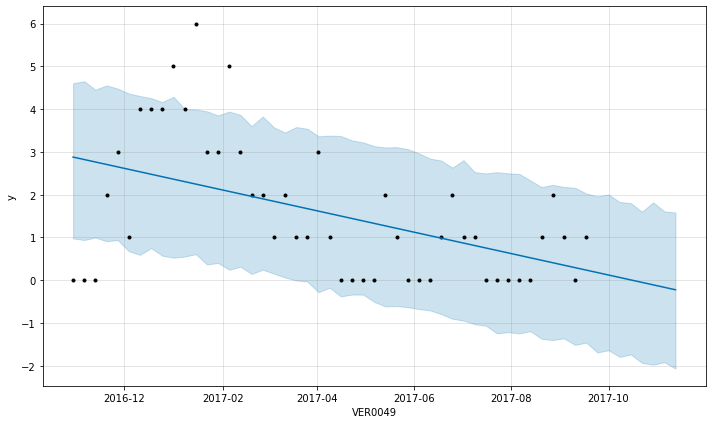

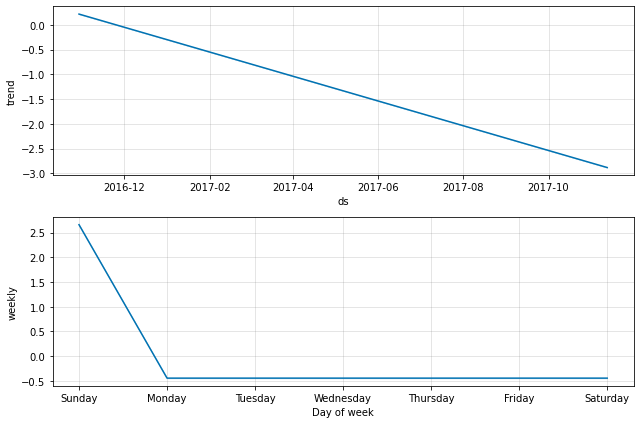

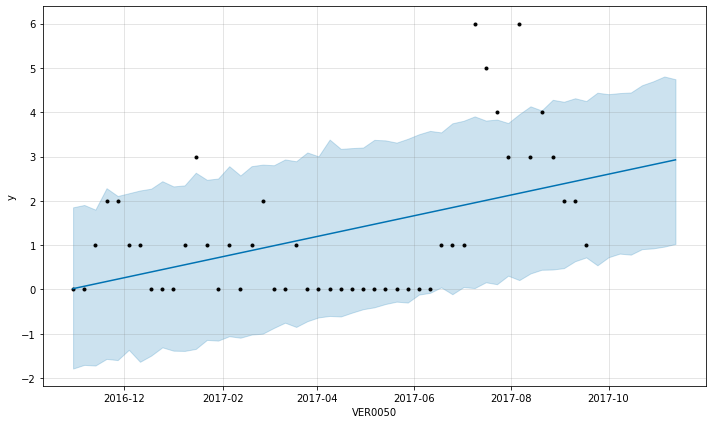

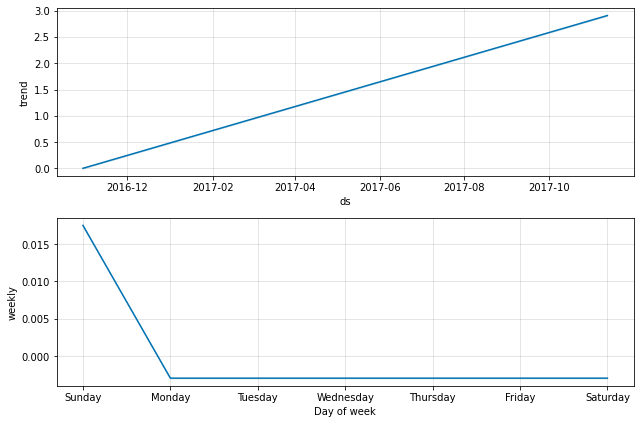

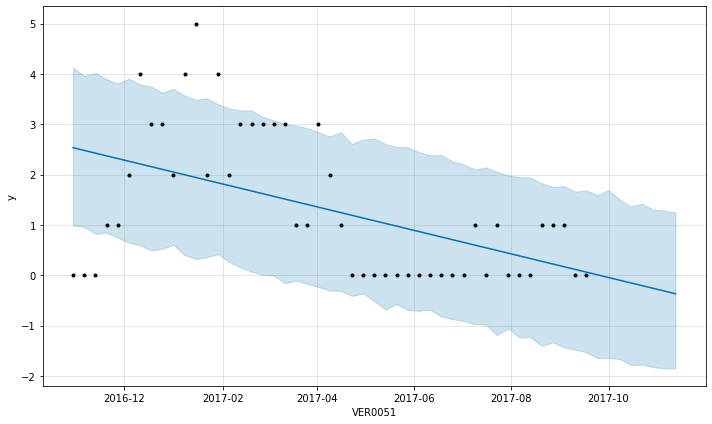

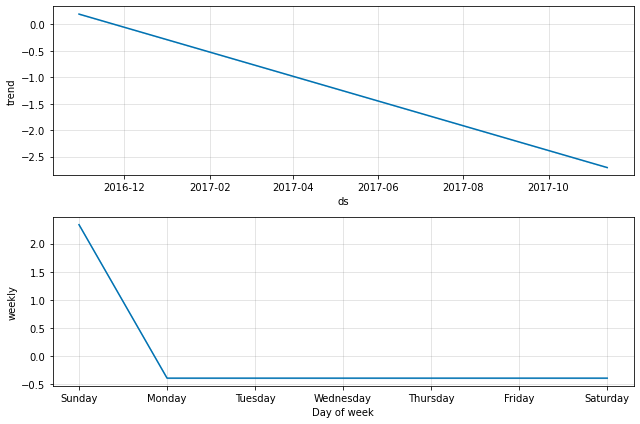

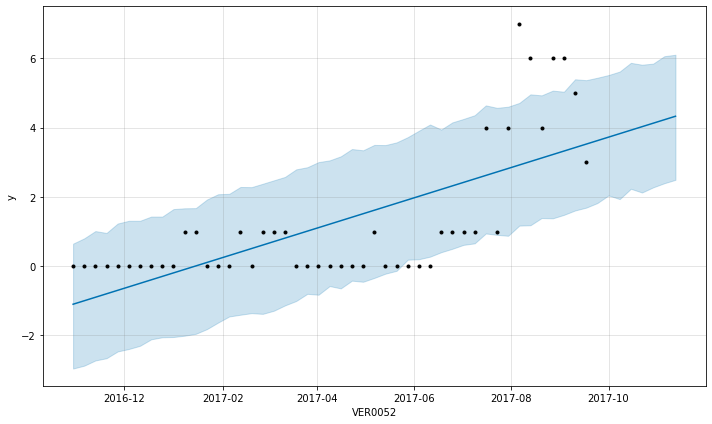

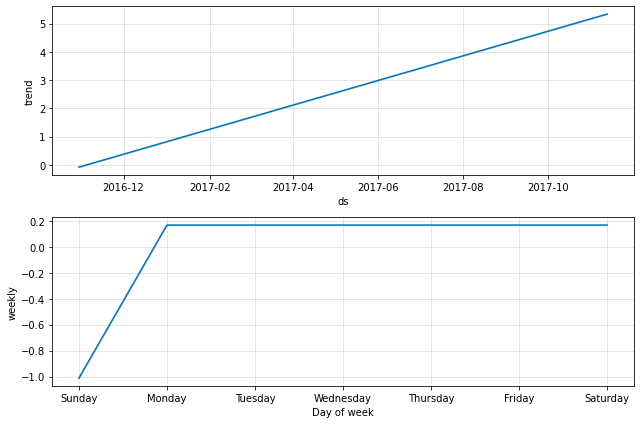

In [38]:
modelo = list()
for i in range(1,ventas_producto.shape[1]-1):
    df_unitario = ventas_producto.iloc[:,[0,i]].copy()
    # print(df_unitario.head(4))
    colname = ventas_producto.columns[i]
    # print("df_unitario - " + colname + ": ")
    df_unitario = df_unitario.rename(columns={"semana":"ds",colname:"y"})
    # Modelo unitario (es decir producto a producto)
    modelo_unitario = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
    modelo_unitario.fit(df_unitario)
    x = modelo_unitario.make_future_dataframe(periods=8, freq='w')
    prediccion_unitaria = modelo_unitario.predict(x)
    # print("prediccion_unitaria - " + colname + ": ")
    # print(prediccion_unitaria)
    modelo.append(prediccion_unitaria)
    forecast=prediccion_unitaria[['ds', 'yhat']]
    # print("forecast - " + colname + ": ")
    # print(forecast)
    if i == 1:
        forecast_acum = forecast.rename(columns={"yhat" : colname})
    if i > 1:
        forecast_acum = forecast_acum.join(forecast.set_index('ds'), on='ds')
        forecast_acum = forecast_acum.rename(columns={"yhat" : colname})
    fig = modelo_unitario.plot(prediccion_unitaria)
    modelo_unitario.plot_components(prediccion_unitaria)
    axes = fig.get_axes()
    axes[0].set_xlabel(colname)

In [75]:
forecast_final = forecast_acum.round()
forecast_final.to_csv('prophet_forecast_final')


In [40]:
# Validacion de estimaciones
from sklearn.metrics import mean_squared_error
error_rolling_prophet = mean_squared_error(ventas_producto.iloc[0:47,1:-1], forecast_final.iloc[0:47,1:])**0.5
print('Test MSE: %.3f' % error_rolling_prophet)

Test MSE: 1.486


# Estimación con Red Neuronal

Teniendo como referencia <a href="https://www.aprendemachinelearning.com/pronostico-de-series-temporales-con-redes-neuronales-en-python/">Pronóstico de Series Temporales con Redes Neuronales en Python</a> se construyó el siguiente modelo de red Neuronal.

Se crea una red neuronal normal feedforward:
La arquitectura de la red neuronal será:

- Neuronas de entrada: 24
- 1 capa oculta con 24 neuronas
- 1 neurona a la salida

Como función de activación se utilizará tangente hiperbólica puesto que se utilizan valores entre -1 y 1. Se utilizará como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error. Como la predicción será un valor continuo y no discreto, para calcular el Acuracy se utilizará Mean Squared Error y para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

In [41]:
# Se crea una función que crea la red neuronal Feed Forward
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh')) # Capa de entrada
    model.add(Flatten()) # Capa oculta
    model.add(Dense(1, activation='tanh')) # Capa de salida
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

Se implementa una función `series_to_supervised` que le asigna a cada registro, N (PASOS) observaciones de períodos anteriores. Para el caso en concreto, se tomarán las ocho (8) semanas anteriores para predecir la(s) posterior(es).

In [42]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [43]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

Se realiza la iteración para cada uno de los productos:

  ******  FRU0002   ******  
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_55 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 81ms/step - loss: 0.5129 - mse: 0.4005 - val_loss: 0.4092 - val_mse: 0.1930
Epoch 2/40
1/1 [==============================] - 0s 26ms/step - loss: 0.4804 - mse: 0.3508 - val_loss: 0.3970 - val_mse: 0.1742
Epoch 3/40
1/1 [==============================] - 0s 25ms/step - loss: 0.4568 - mse: 0.3106 - val_

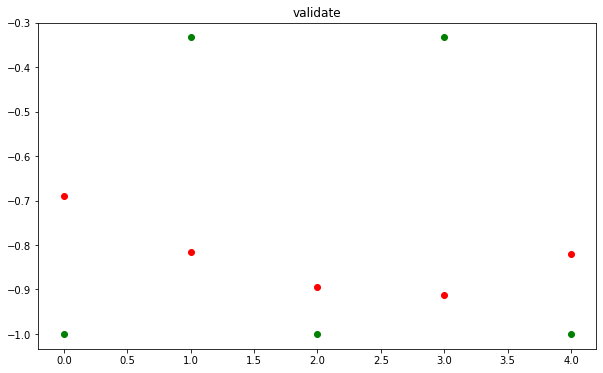

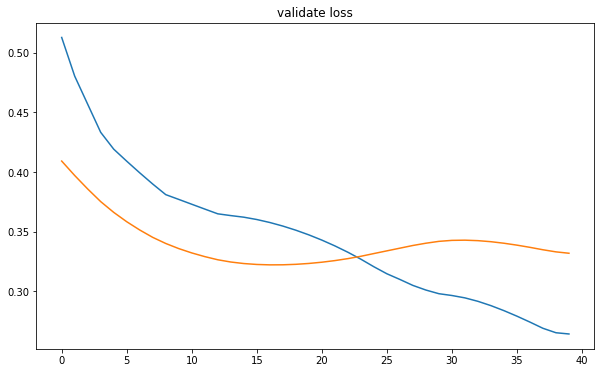

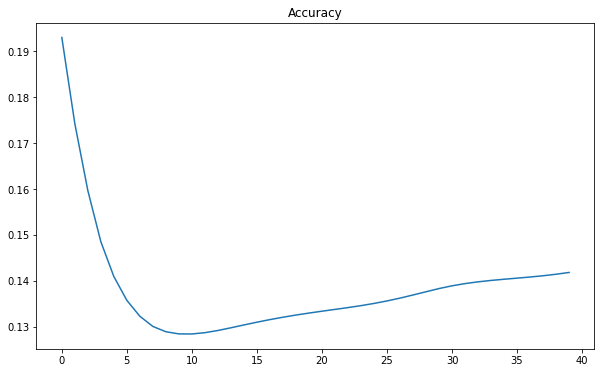

   pronostico
0    0.920884
1    0.246233
2    0.445810
3    0.308029
  ******  FRU0003   ******  
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_56 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4642 - mse: 0.4228 - val_loss: 0.9849 - val_mse: 1.0867
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.4591 - mse: 0.4188 - val_loss: 0.9865 - val_mse: 1.0899
Epoch 3/40
1/1 [============

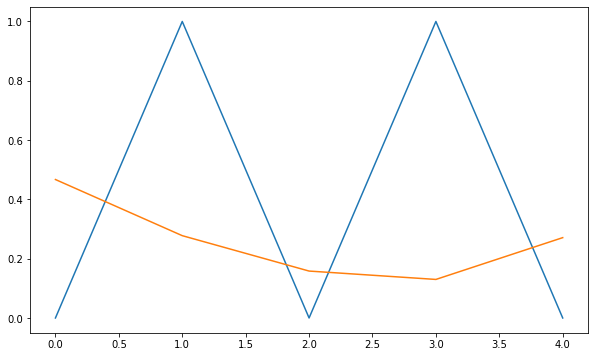

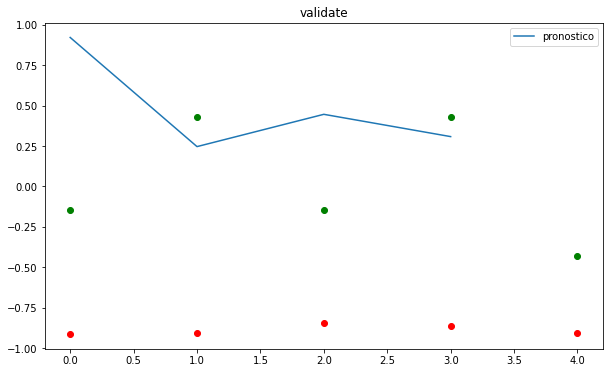

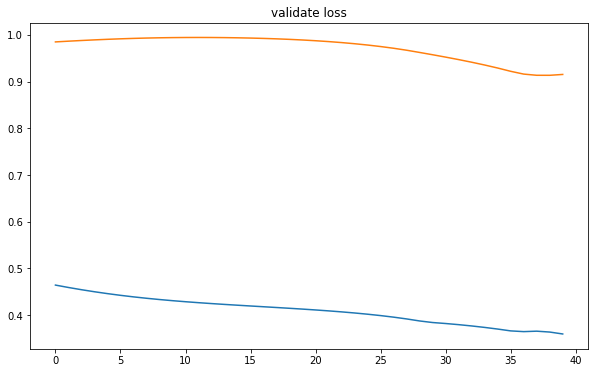

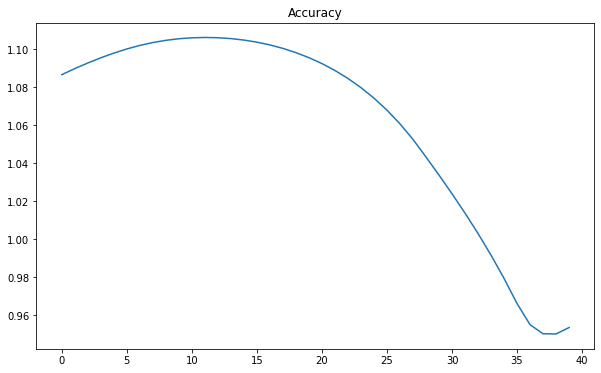

   pronostico
0    0.453291
1    0.519389
2    0.310645
3    0.274509
  ******  FRU0008   ******  
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_57 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4867 - mse: 0.3381 - val_loss: 0.6284 - val_mse: 0.5458
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.4658 - mse: 0.3047 - val_loss: 0.6109 - val_mse: 0.5142
Epoch 3/40
1/1 [============

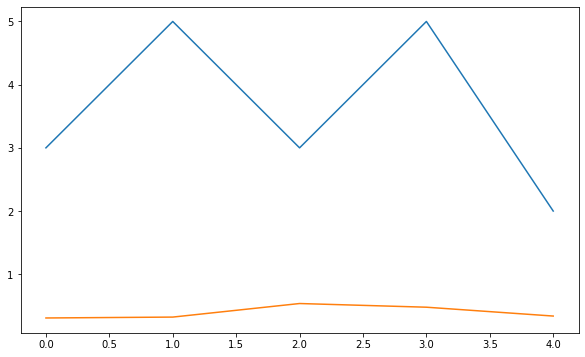

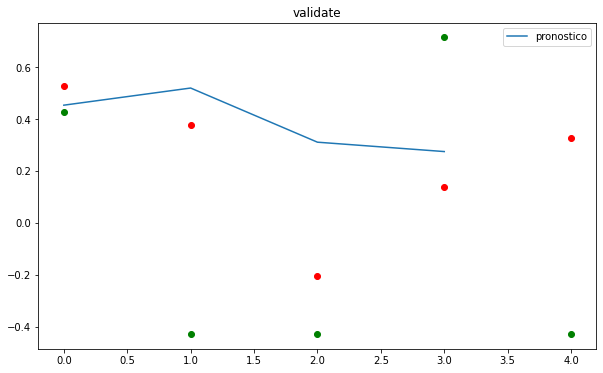

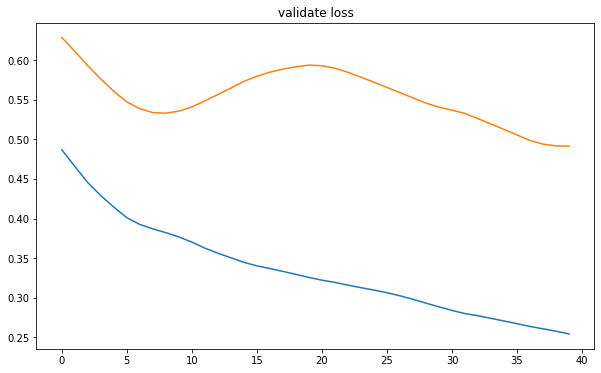

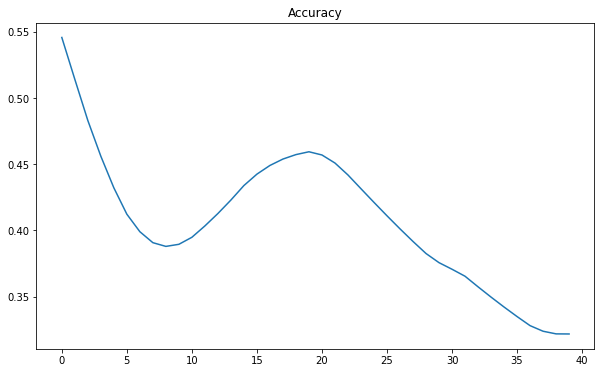

   pronostico
0    0.731910
1    0.899345
2    0.898256
3    0.800577
  ******  FRU0016   ******  
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_58 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 81ms/step - loss: 0.4177 - mse: 0.2748 - val_loss: 0.5369 - val_mse: 0.5378
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.4043 - mse: 0.2622 - val_loss: 0.5406 - val_mse: 0.5386
Epoch 3/40
1/1 [============

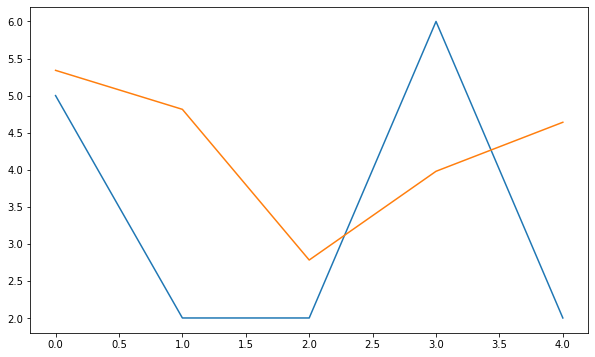

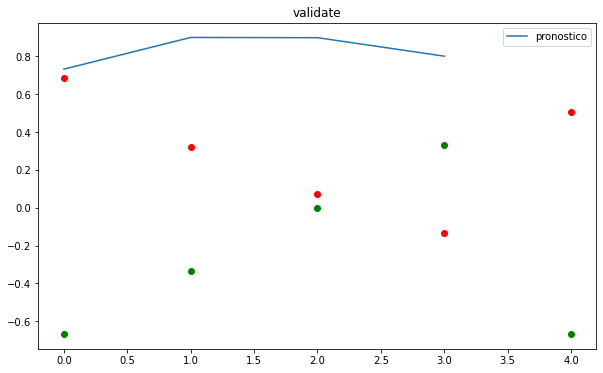

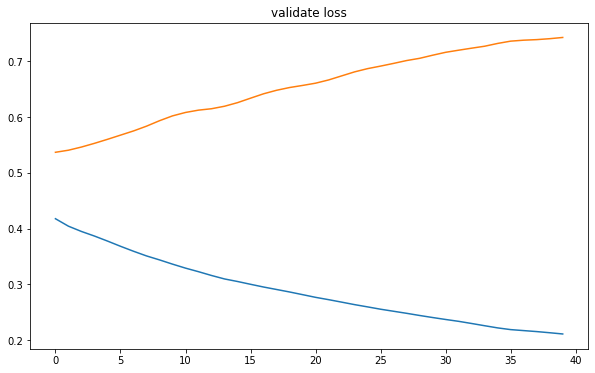

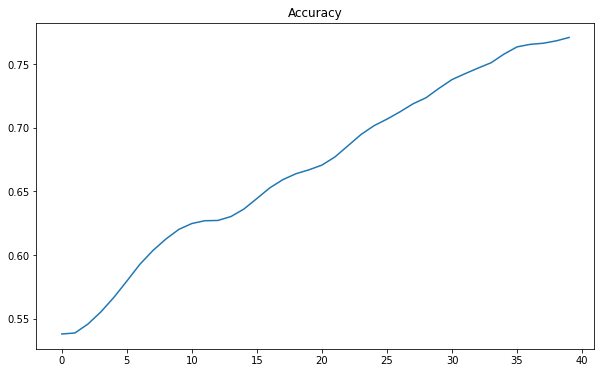

   pronostico
0    0.366328
1    1.446209
2    0.175735
3    0.624052
  ******  FRU0017   ******  
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_59 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 1.1204 - mse: 1.4519 - val_loss: 1.0340 - val_mse: 1.0910
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 1.0694 - mse: 1.3406 - val_loss: 0.9454 - val_mse: 0.9154
Epoch 3/40
1/1 [============

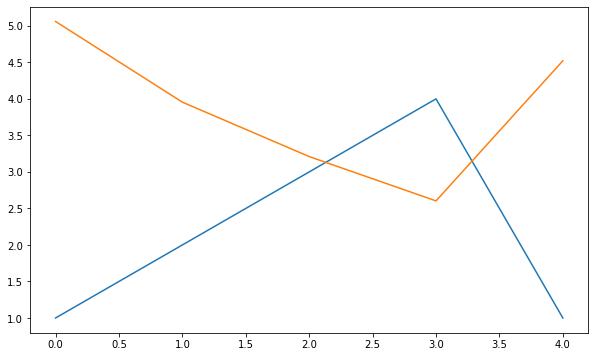

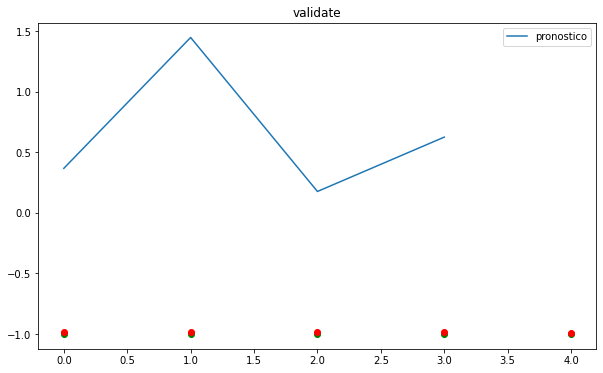

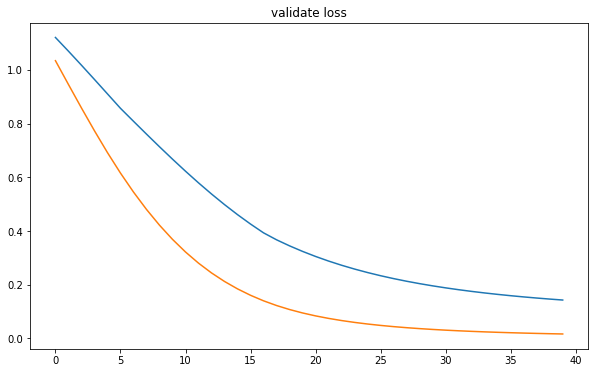

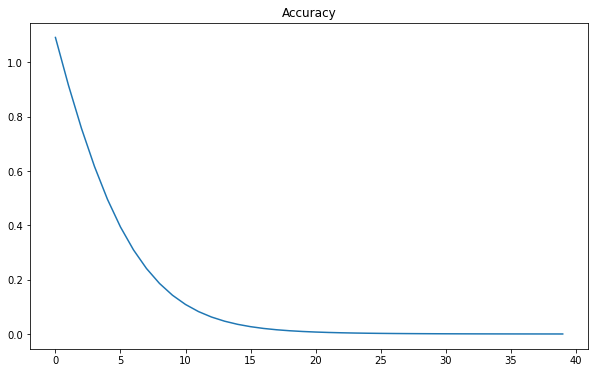

   pronostico
0    0.089768
1    0.132441
2    0.060084
3    0.061615
  ******  FRU0022   ******  
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_60 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4458 - mse: 0.2744 - val_loss: 0.3900 - val_mse: 0.2827
Epoch 2/40
1/1 [==============================] - 0s 21ms/step - loss: 0.4328 - mse: 0.2619 - val_loss: 0.3905 - val_mse: 0.2938
Epoch 3/40
1/1 [============

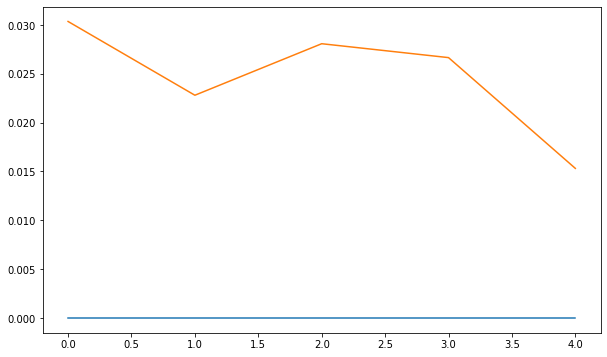

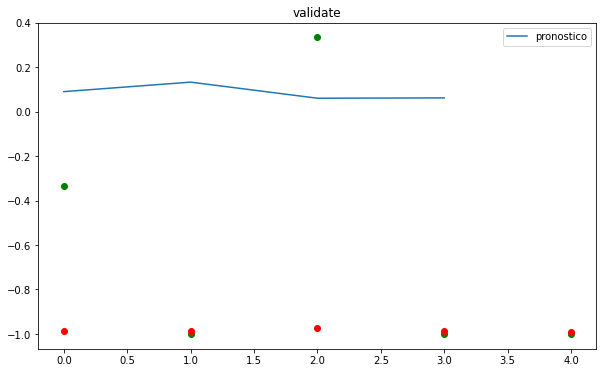

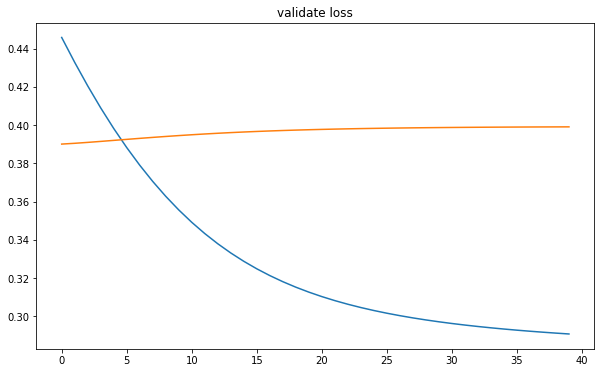

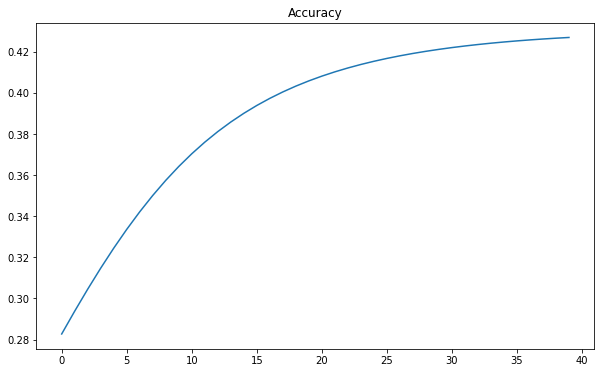

   pronostico
0    0.025417
1    0.039437
2    0.060479
3    0.048752
  ******  FRU0024   ******  
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_122 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_61 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5850 - mse: 0.4672 - val_loss: 0.1528 - val_mse: 0.0458
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.5647 - mse: 0.4392 - val_loss: 0.1659 - val_mse: 0.0445
Epoch 3/40
1/1 [============

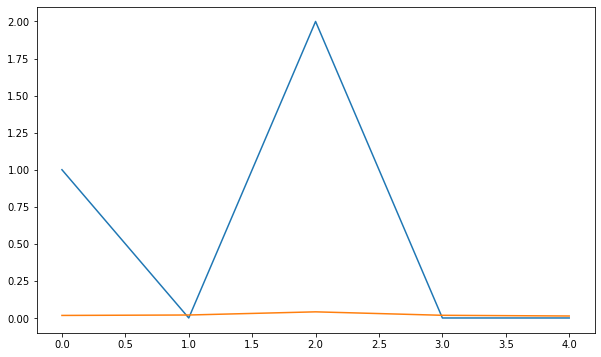

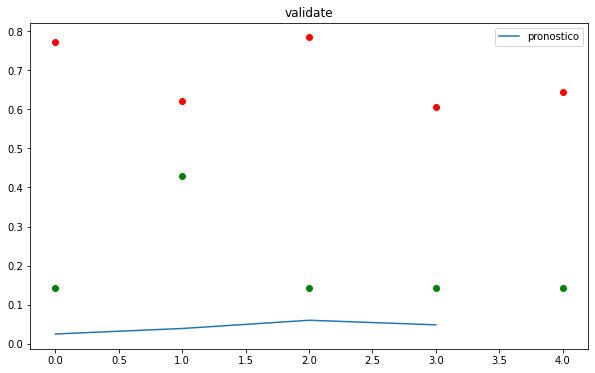

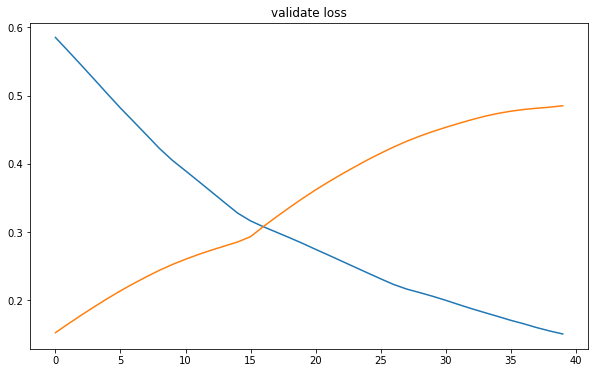

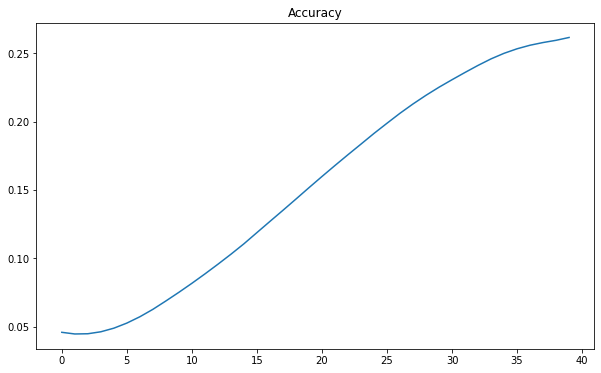

   pronostico
0    1.909838
1    1.729670
2    2.027762
3    3.159519
  ******  FRU0025   ******  
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_62 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 78ms/step - loss: 0.5326 - mse: 0.4551 - val_loss: 0.8136 - val_mse: 0.8877
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.5222 - mse: 0.4475 - val_loss: 0.8043 - val_mse: 0.8739
Epoch 3/40
1/1 [============

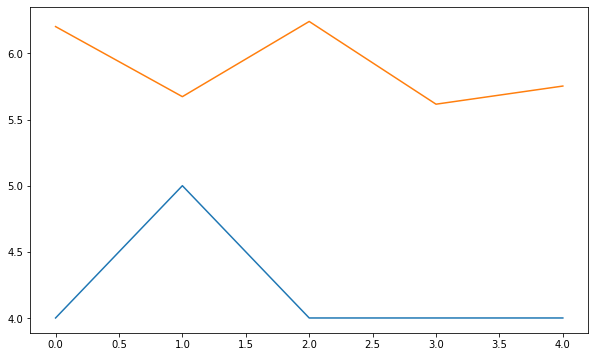

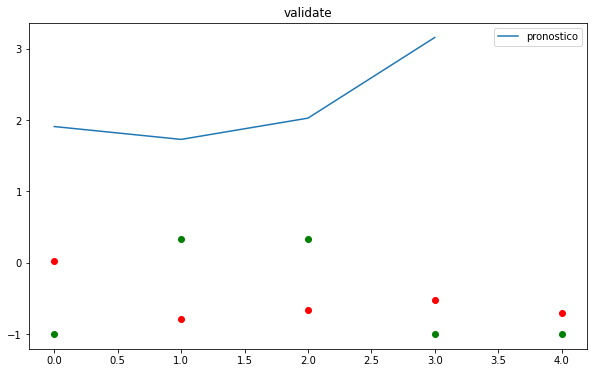

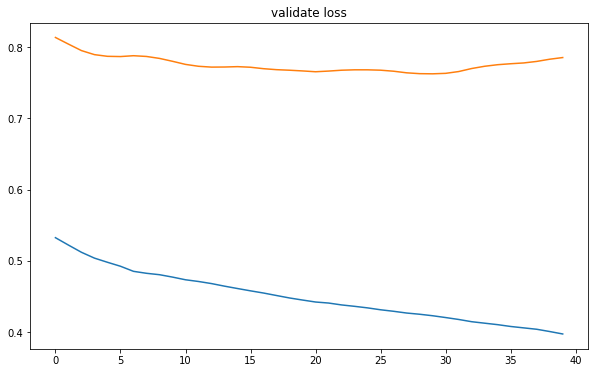

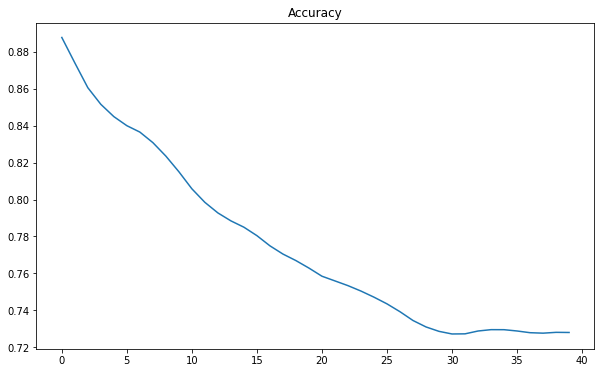

   pronostico
0    0.810920
1    0.098925
2    0.066981
3    0.493495
  ******  FRU0028   ******  
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_63 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.7140 - mse: 0.7432 - val_loss: 0.4208 - val_mse: 0.3698
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.6974 - mse: 0.7243 - val_loss: 0.4306 - val_mse: 0.3514
Epoch 3/40
1/1 [============

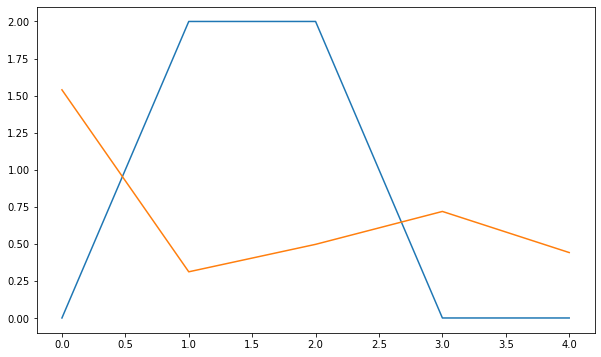

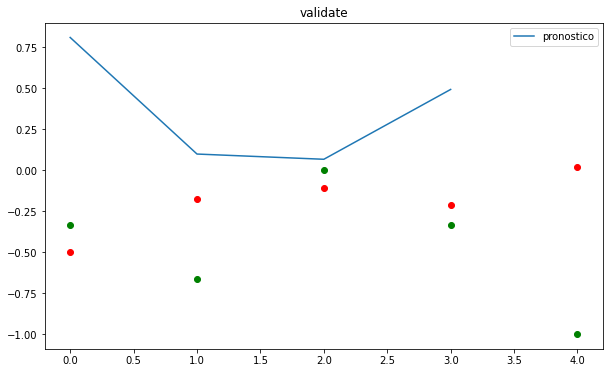

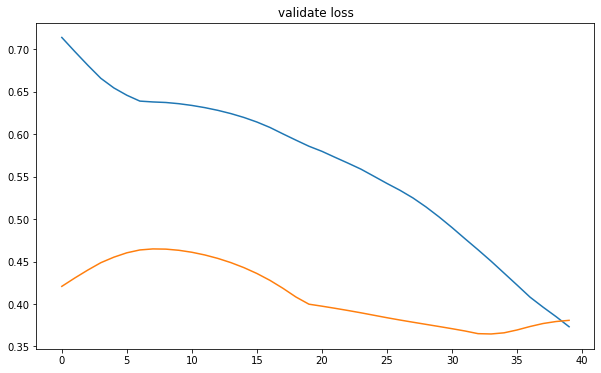

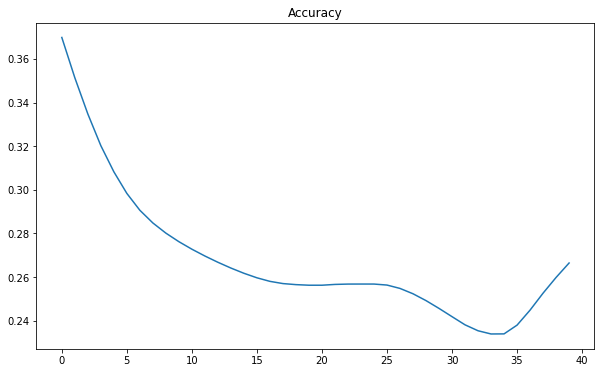

   pronostico
0    1.075052
1    1.589724
2    1.461585
3    1.403665
  ******  FRU0030   ******  
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_64 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 76ms/step - loss: 0.7916 - mse: 0.7377 - val_loss: 0.3238 - val_mse: 0.1887
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.7268 - mse: 0.6352 - val_loss: 0.3258 - val_mse: 0.1706
Epoch 3/40
1/1 [============

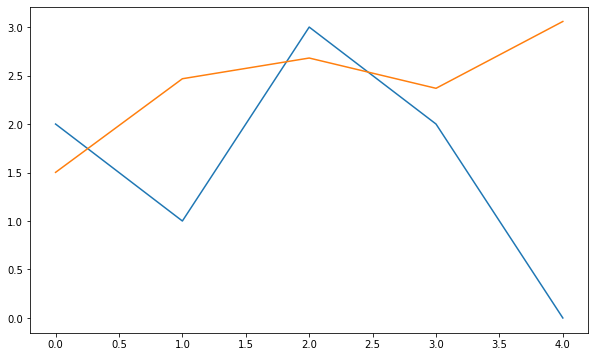

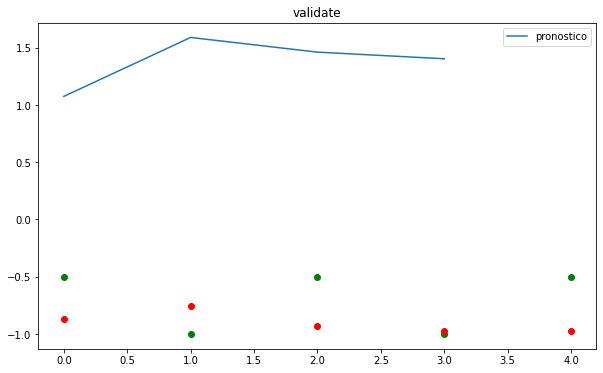

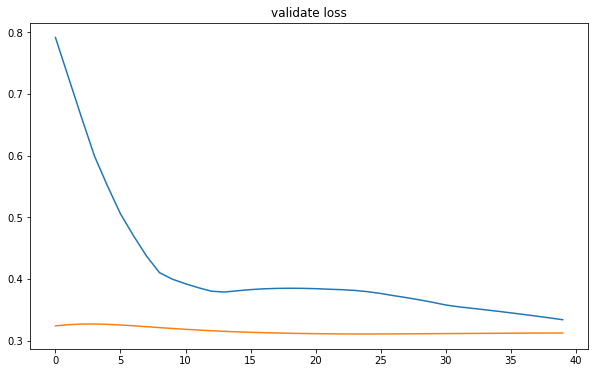

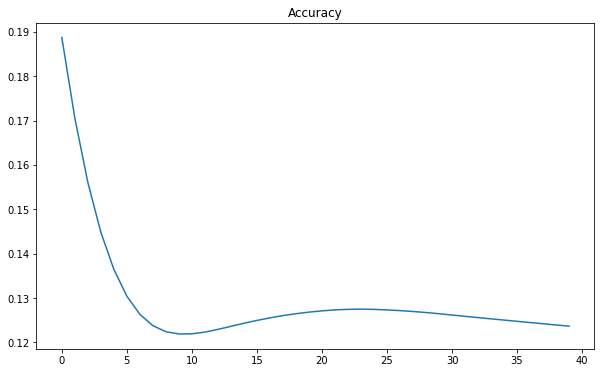

   pronostico
0    0.234276
1    0.474049
2    0.201049
3    0.479416
  ******  FRU0031   ******  
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_65 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 336ms/step - loss: 0.9364 - mse: 1.0187 - val_loss: 0.7995 - val_mse: 0.8908
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.9004 - mse: 0.9534 - val_loss: 0.7655 - val_mse: 0.8380
Epoch 3/40
1/1 [===========

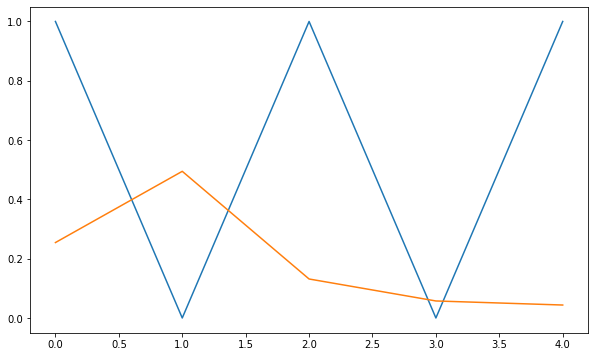

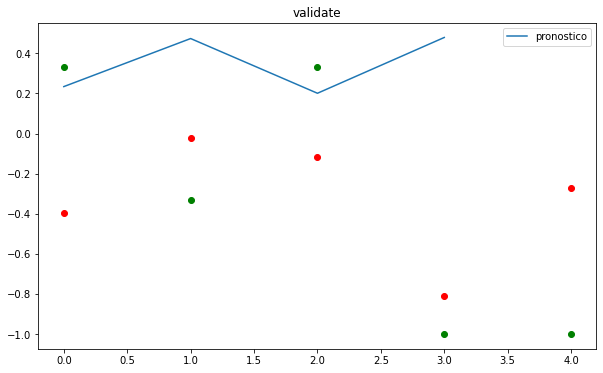

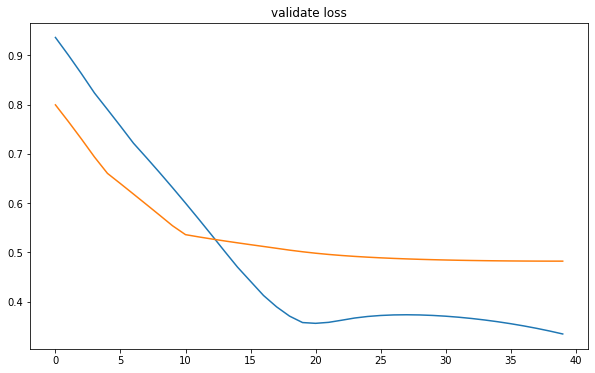

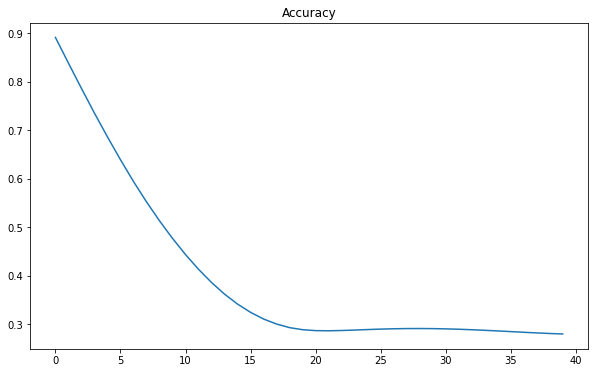

   pronostico
0    0.888166
1    0.746331
2    1.054976
3    0.438901
  ******  FRU0032   ******  
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_66 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_133 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.7610 - mse: 0.8725 - val_loss: 1.2532 - val_mse: 1.7269
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.7405 - mse: 0.8374 - val_loss: 1.2311 - val_mse: 1.6730
Epoch 3/40
1/1 [============

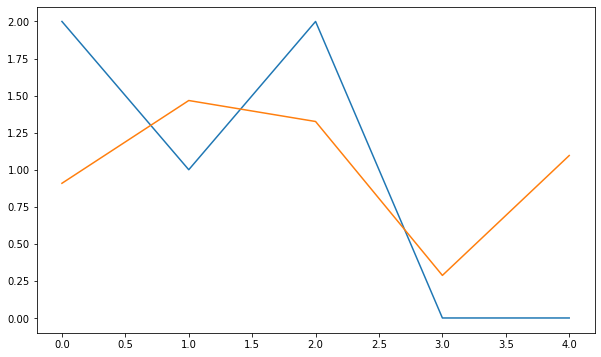

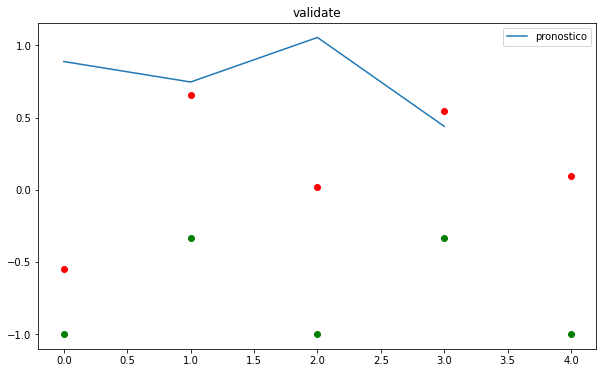

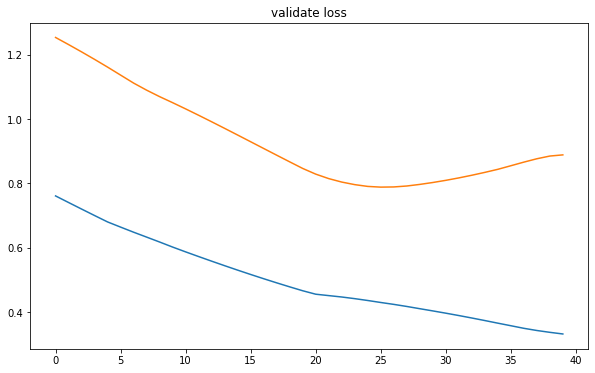

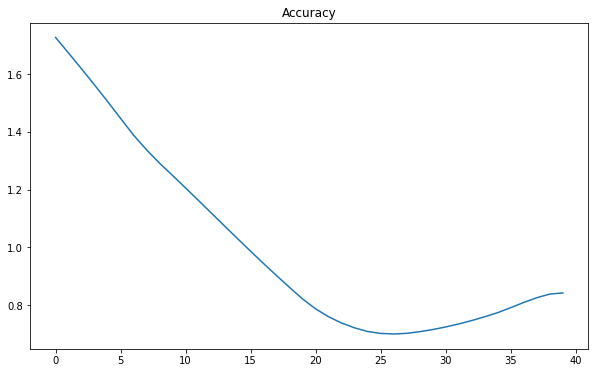

   pronostico
0    2.930026
1    0.804115
2    0.885532
3    0.647284
  ******  FRU0033   ******  
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_67 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.6985 - mse: 0.6975 - val_loss: 0.9559 - val_mse: 1.0239
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.6846 - mse: 0.6706 - val_loss: 0.9448 - val_mse: 1.0055
Epoch 3/40
1/1 [============

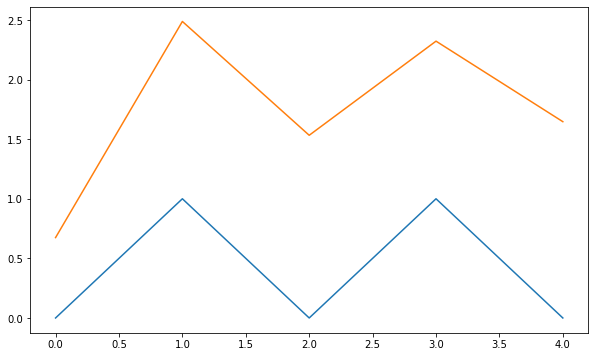

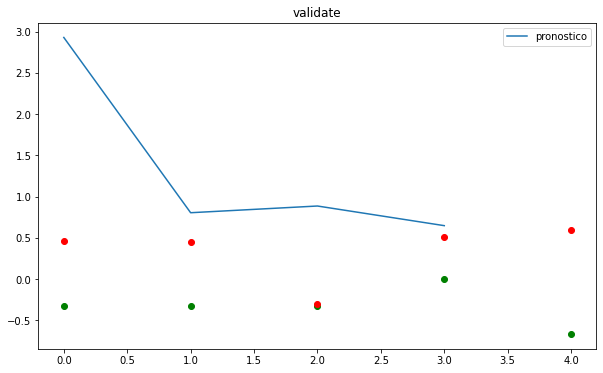

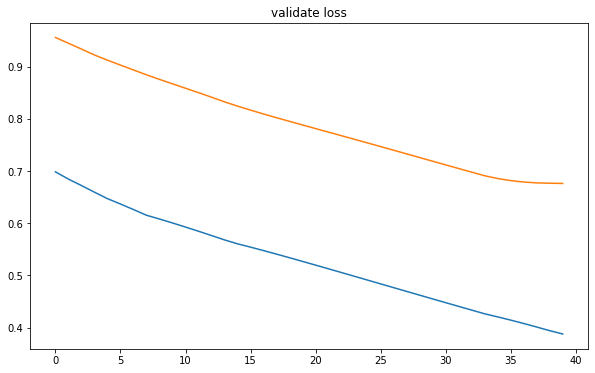

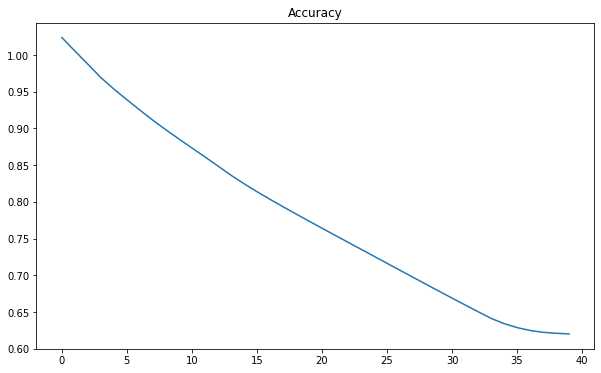

   pronostico
0    1.873504
1    1.895035
2    0.658482
3    1.423412
  ******  FRU0034   ******  
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_68 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.7282 - mse: 0.6997 - val_loss: 0.7650 - val_mse: 0.7827
Epoch 2/40
1/1 [==============================] - 0s 21ms/step - loss: 0.6974 - mse: 0.6498 - val_loss: 0.7676 - val_mse: 0.7972
Epoch 3/40
1/1 [============

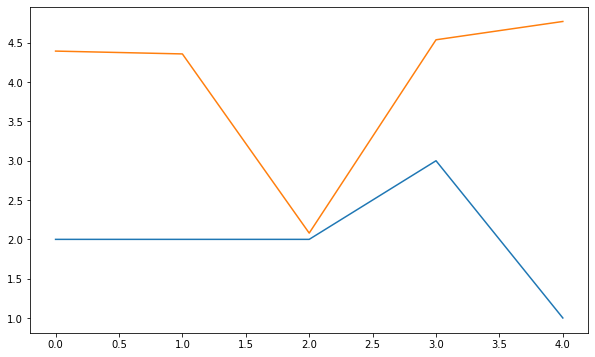

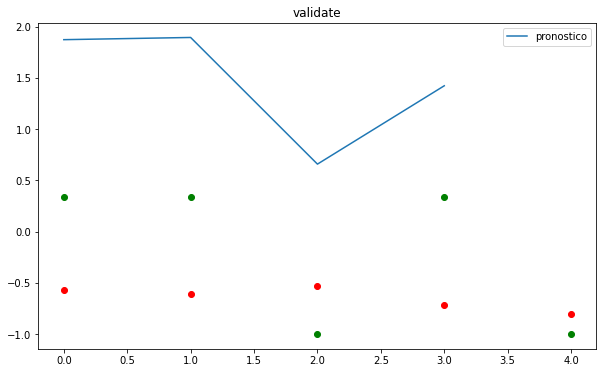

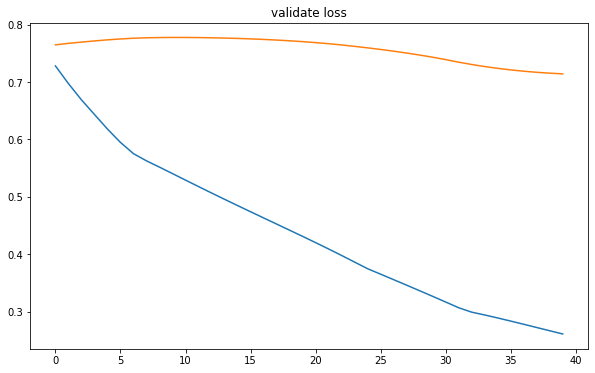

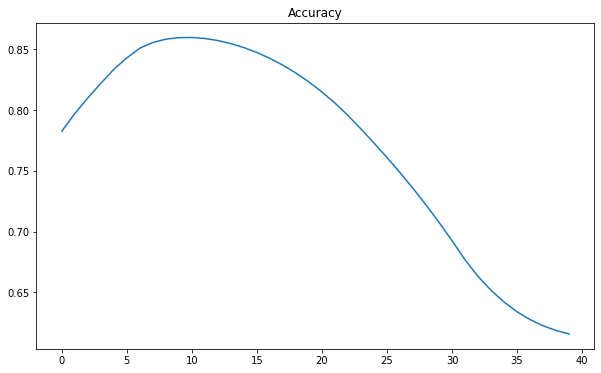

   pronostico
0    0.244353
1    0.200605
2    0.916024
3    1.161129
  ******  FRU0037   ******  
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_69 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 76ms/step - loss: 0.7231 - mse: 0.7931 - val_loss: 0.6772 - val_mse: 0.4673
Epoch 2/40
1/1 [==============================] - 0s 23ms/step - loss: 0.6806 - mse: 0.7322 - val_loss: 0.6096 - val_mse: 0.3791
Epoch 3/40
1/1 [============

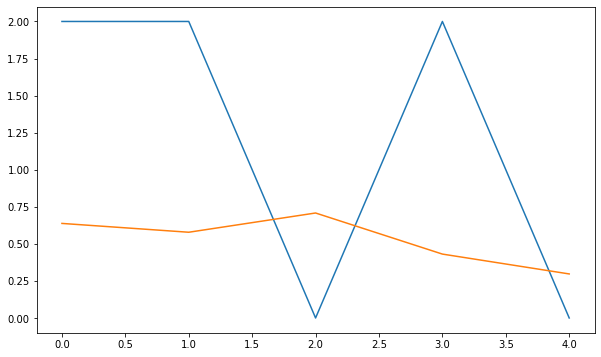

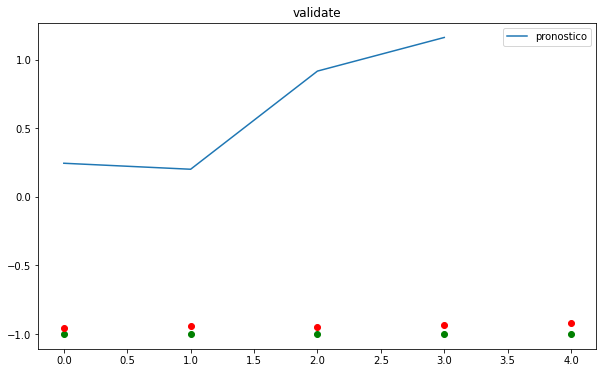

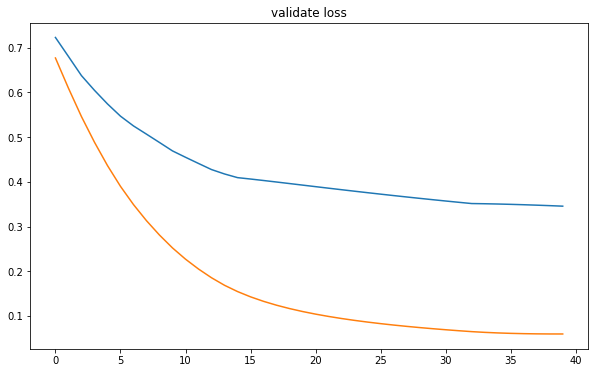

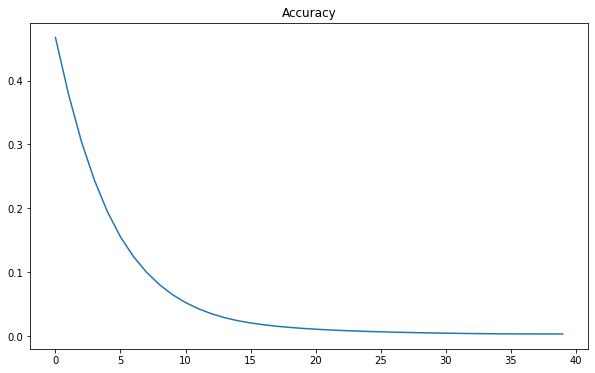

   pronostico
0    0.164613
1    0.154861
2    0.120158
3    0.097649
  ******  FRU0040   ******  
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_70 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5684 - mse: 0.4716 - val_loss: 0.7999 - val_mse: 0.7979
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.5312 - mse: 0.4103 - val_loss: 0.7270 - val_mse: 0.6880
Epoch 3/40
1/1 [============

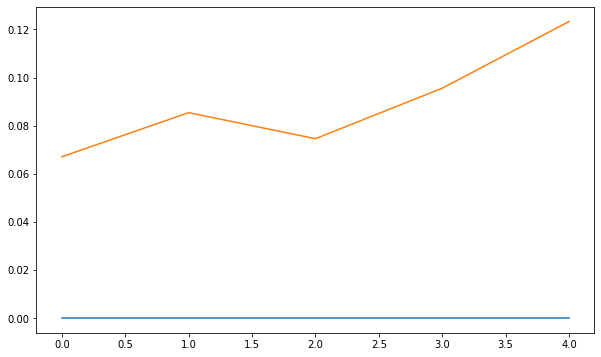

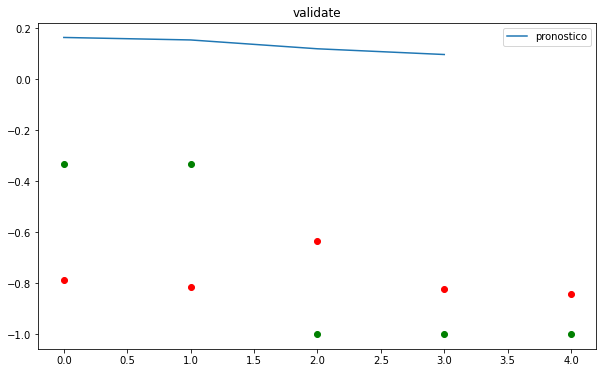

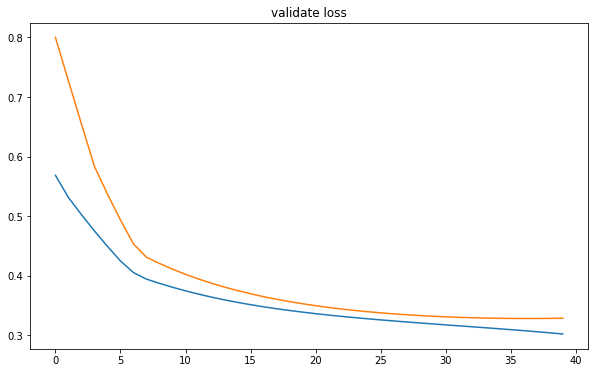

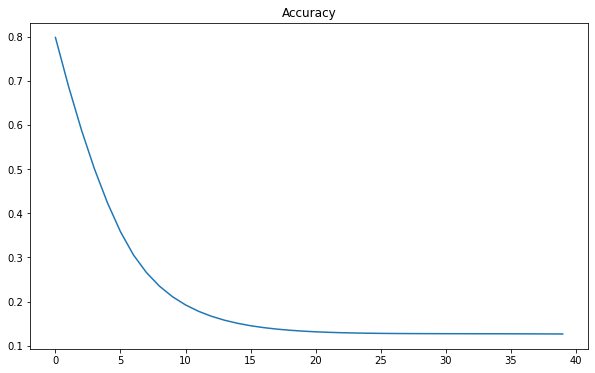

   pronostico
0    0.028203
1    0.066441
2    0.119951
3    0.168850
  ******  FRU0042   ******  
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_71 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5808 - mse: 0.4830 - val_loss: 0.4238 - val_mse: 0.2886
Epoch 2/40
1/1 [==============================] - 0s 21ms/step - loss: 0.5538 - mse: 0.4468 - val_loss: 0.4078 - val_mse: 0.2871
Epoch 3/40
1/1 [============

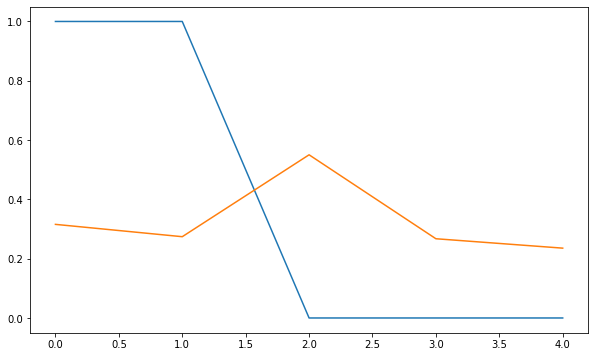

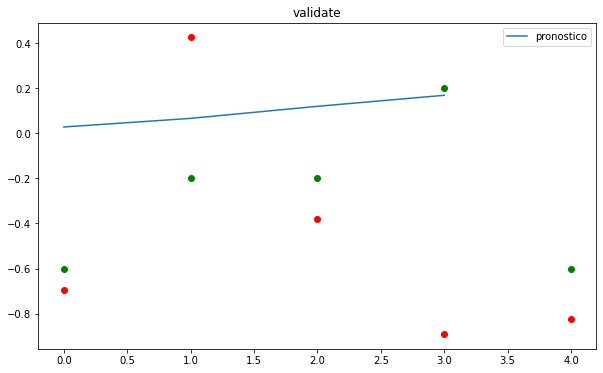

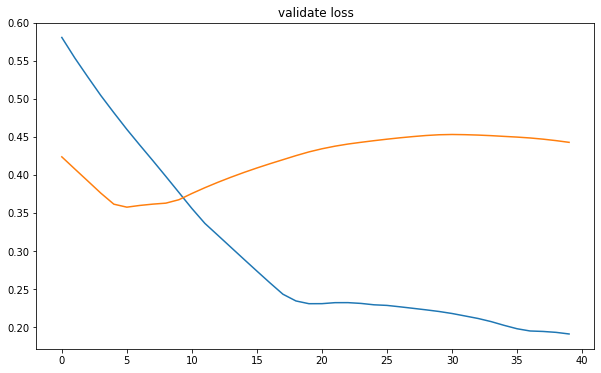

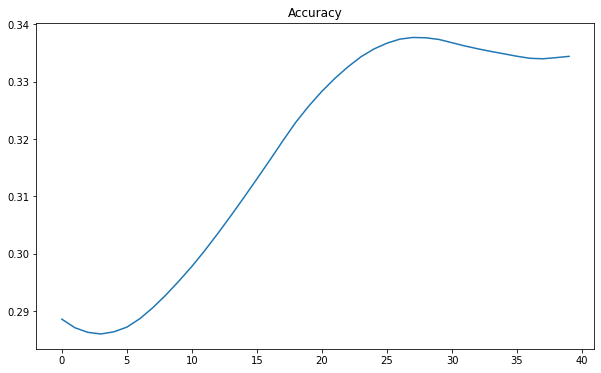

   pronostico
0    0.444941
1    1.162925
2    1.976876
3    2.106230
  ******  FRU0045   ******  
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_72 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 83ms/step - loss: 1.0758 - mse: 1.4065 - val_loss: 1.4170 - val_mse: 2.2633
Epoch 2/40
1/1 [==============================] - 0s 23ms/step - loss: 1.0395 - mse: 1.3082 - val_loss: 1.4562 - val_mse: 2.3795
Epoch 3/40
1/1 [============

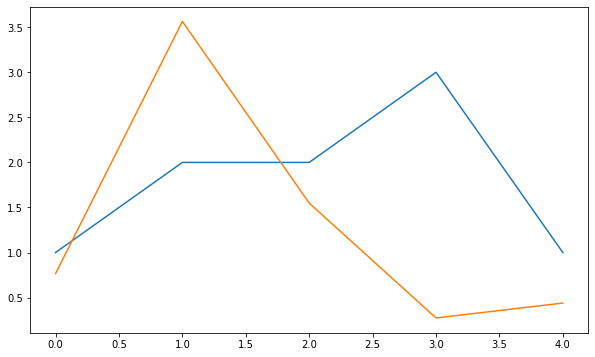

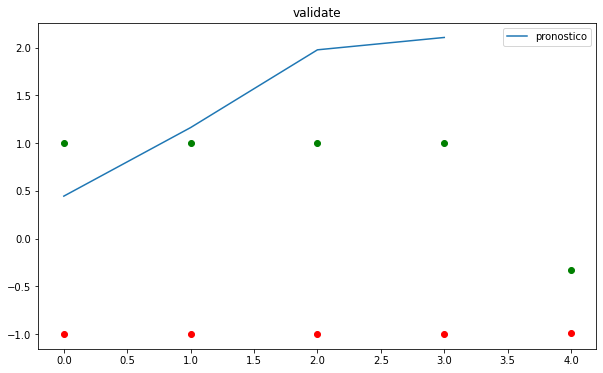

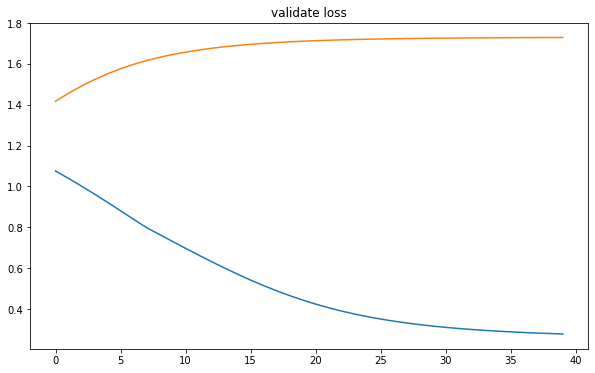

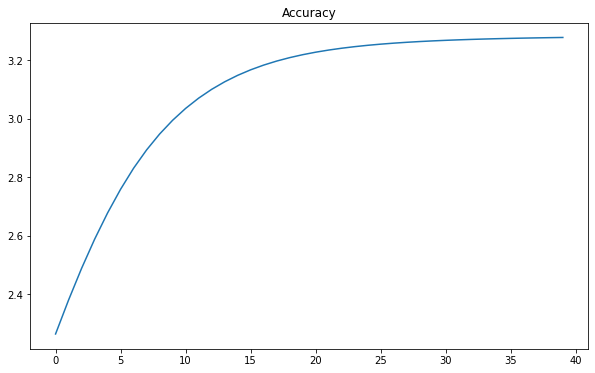

   pronostico
0    0.126019
1    0.081685
2    0.154721
3    0.023804
  ******  FRU0046   ******  
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_73 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 78ms/step - loss: 0.5818 - mse: 0.4999 - val_loss: 0.6157 - val_mse: 0.3949
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.5623 - mse: 0.4720 - val_loss: 0.6020 - val_mse: 0.3756
Epoch 3/40
1/1 [============

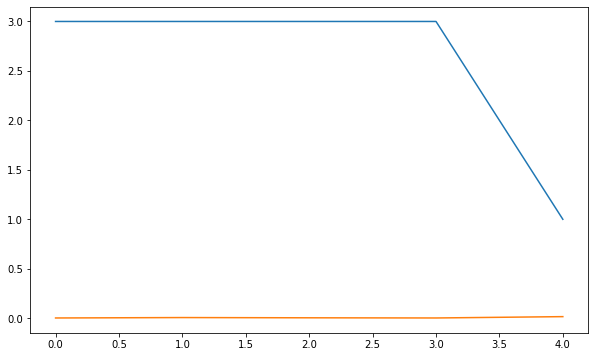

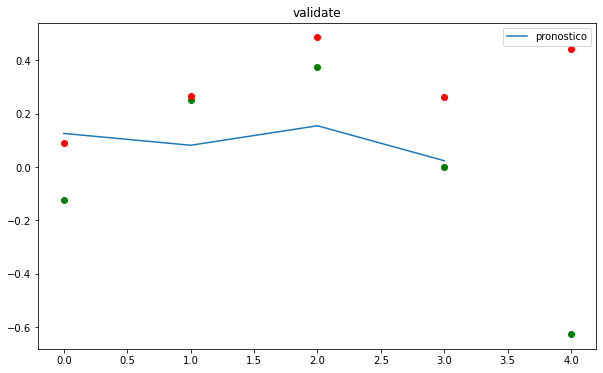

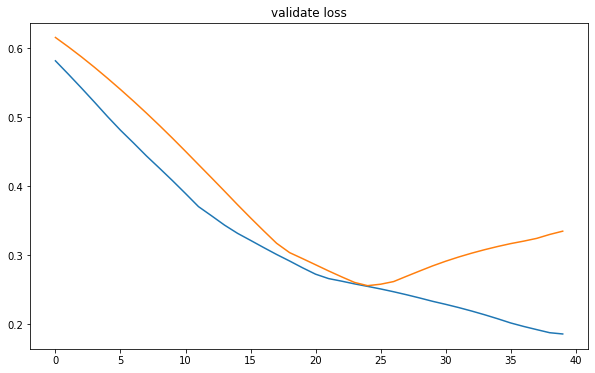

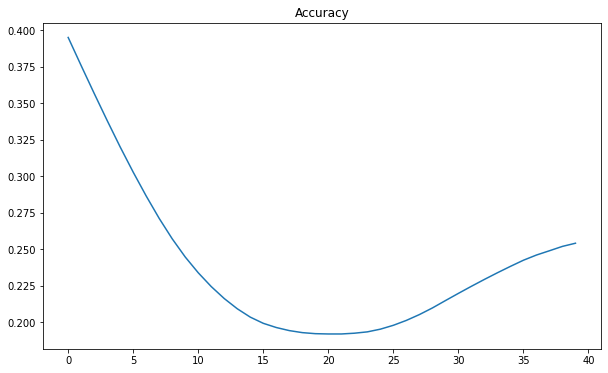

   pronostico
0    4.636235
1    5.634070
2    5.480896
3    4.891088
  ******  FRU0048   ******  
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_74 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 340ms/step - loss: 0.4501 - mse: 0.3039 - val_loss: 0.7923 - val_mse: 0.9730
Epoch 2/40
1/1 [==============================] - 0s 21ms/step - loss: 0.4176 - mse: 0.2698 - val_loss: 0.8094 - val_mse: 1.0062
Epoch 3/40
1/1 [===========

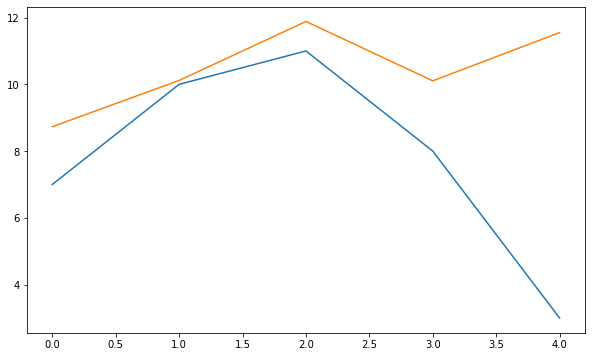

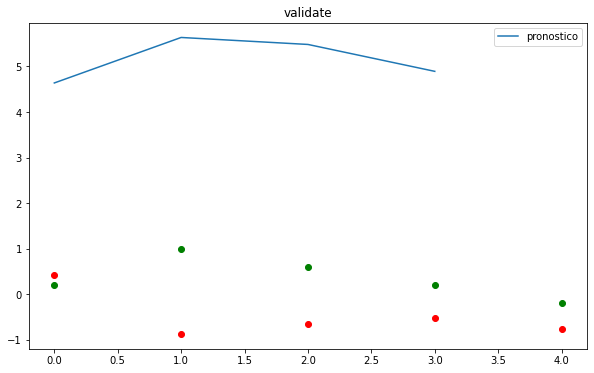

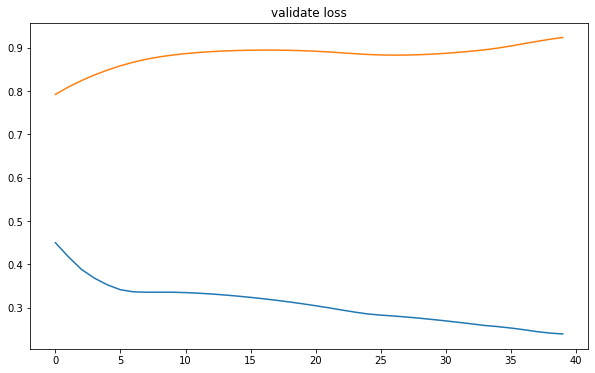

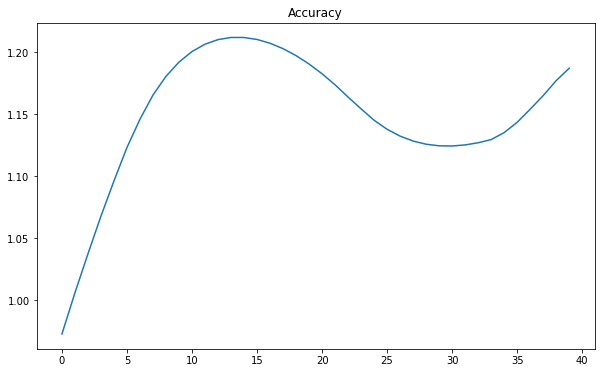

   pronostico
0    0.277048
1    0.742013
2    0.823220
3    1.037171
  ******  GRA0001   ******  
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_75 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 76ms/step - loss: 0.3752 - mse: 0.1566 - val_loss: 0.2477 - val_mse: 0.0728
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.3514 - mse: 0.1387 - val_loss: 0.2334 - val_mse: 0.0707
Epoch 3/40
1/1 [============

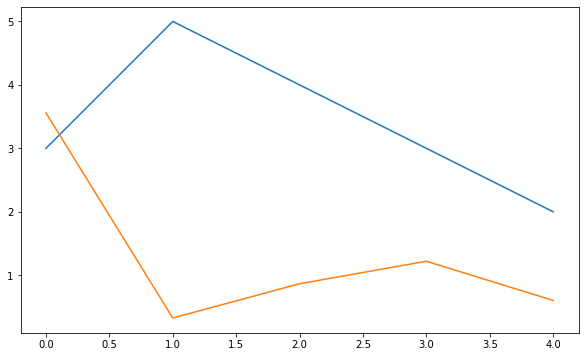

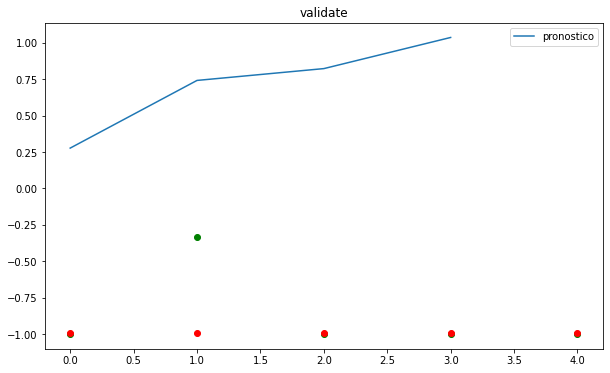

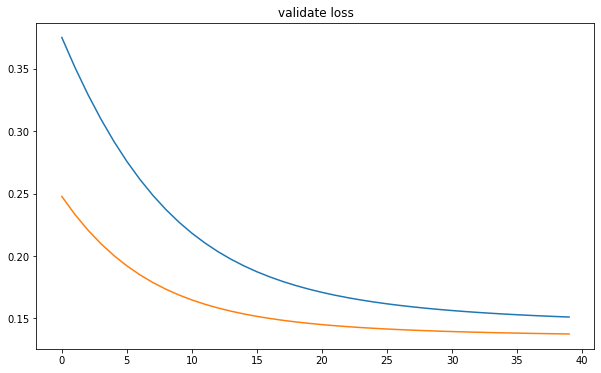

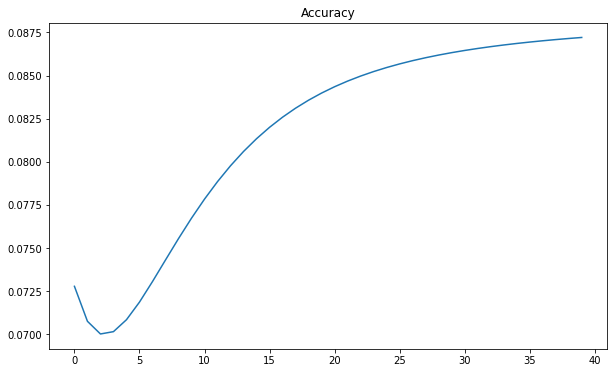

   pronostico
0    0.029517
1    0.010079
2    0.014185
3    0.028850
  ******  GRA0006   ******  
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_76 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.8564 - mse: 0.8370 - val_loss: 0.3526 - val_mse: 0.2222
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.7747 - mse: 0.6891 - val_loss: 0.4100 - val_mse: 0.2800
Epoch 3/40
1/1 [============

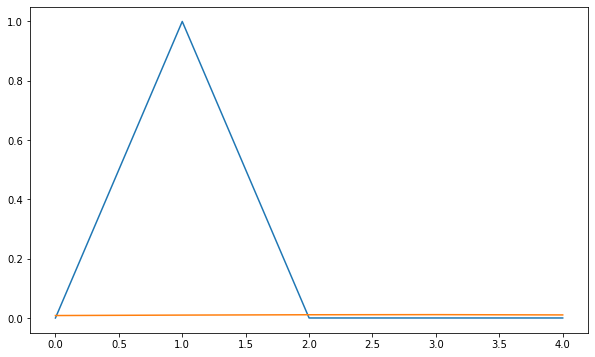

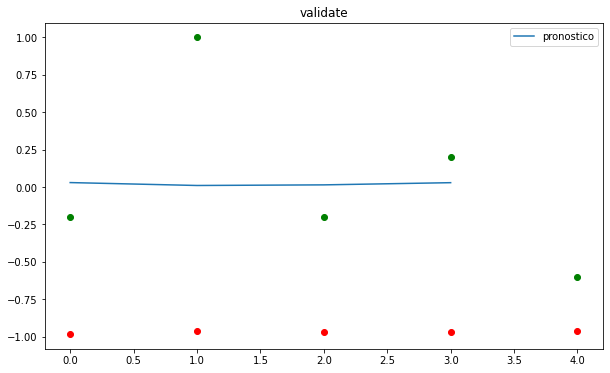

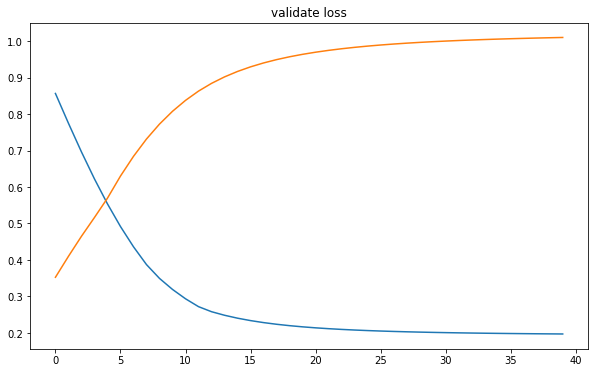

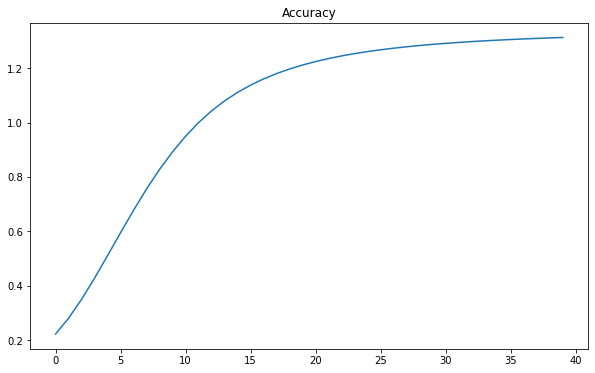

   pronostico
0    0.030712
1    0.035601
2    0.016257
3    0.029397
  ******  TUB0001   ******  
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_77 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 78ms/step - loss: 0.7144 - mse: 0.6068 - val_loss: 0.4424 - val_mse: 0.5037
Epoch 2/40
1/1 [==============================] - 0s 21ms/step - loss: 0.6549 - mse: 0.5114 - val_loss: 0.4475 - val_mse: 0.4853
Epoch 3/40
1/1 [============

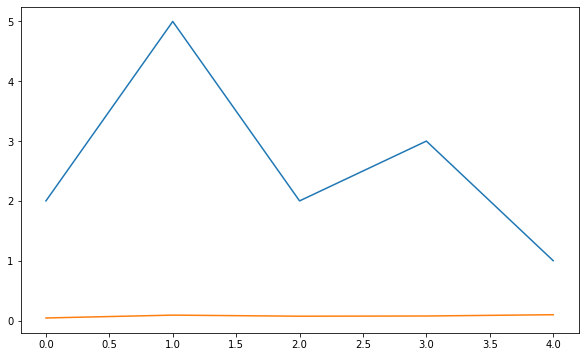

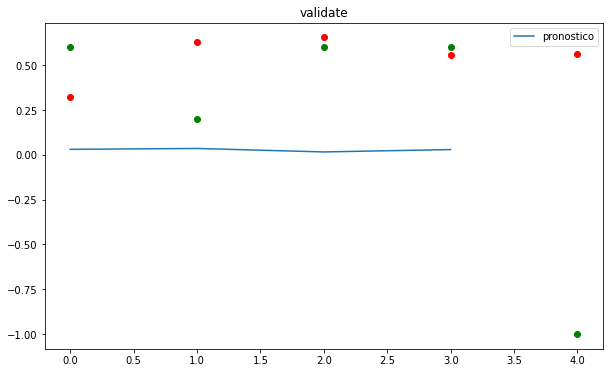

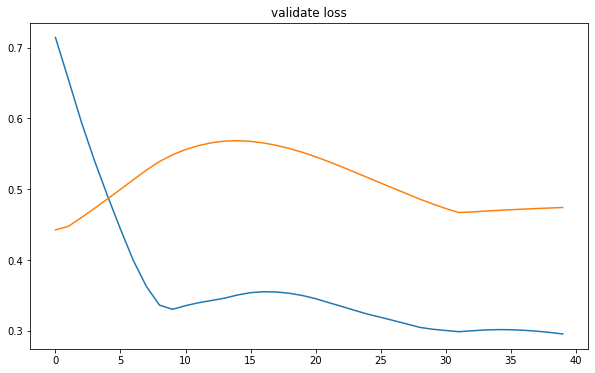

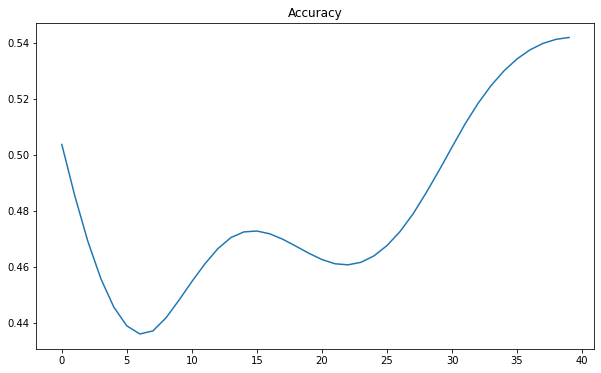

   pronostico
0    0.926671
1    0.643920
2    1.296677
3    0.975042
  ******  TUB0005   ******  
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_78 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_157 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 76ms/step - loss: 0.3831 - mse: 0.2467 - val_loss: 0.4815 - val_mse: 0.4054
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.3737 - mse: 0.2378 - val_loss: 0.4572 - val_mse: 0.3811
Epoch 3/40
1/1 [============

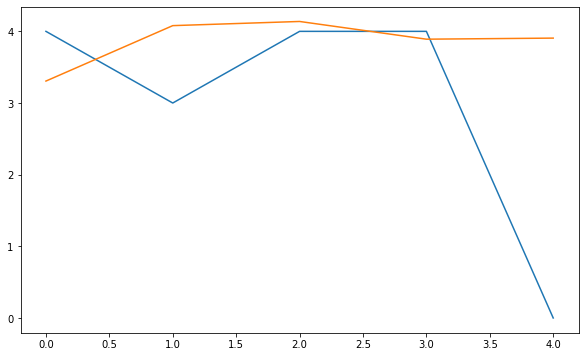

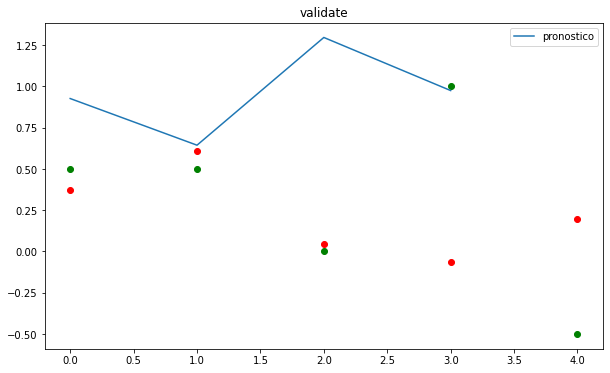

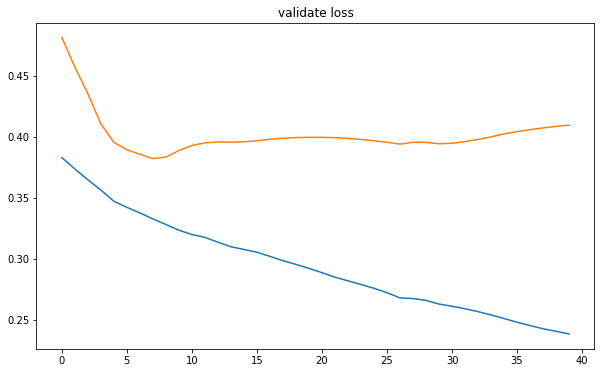

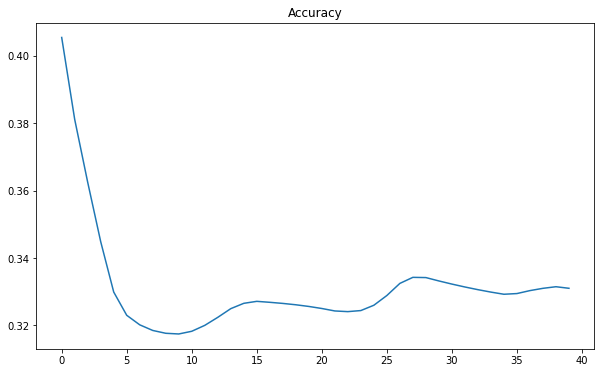

   pronostico
0    0.966680
1    0.851166
2    0.976029
3    1.670759
  ******  TUB0006   ******  
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_79 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4899 - mse: 0.4069 - val_loss: 1.4668 - val_mse: 2.3034
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.4791 - mse: 0.4036 - val_loss: 1.4722 - val_mse: 2.3177
Epoch 3/40
1/1 [============

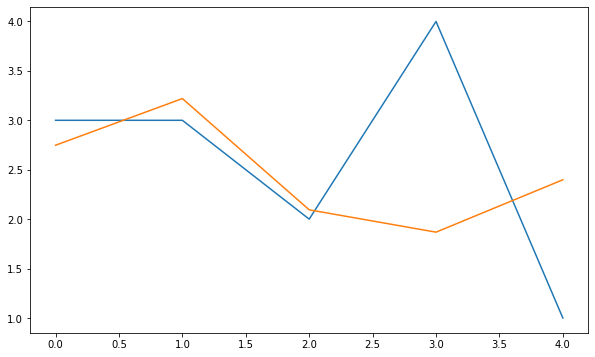

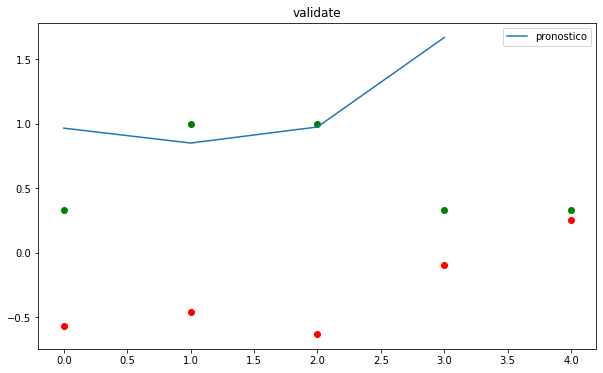

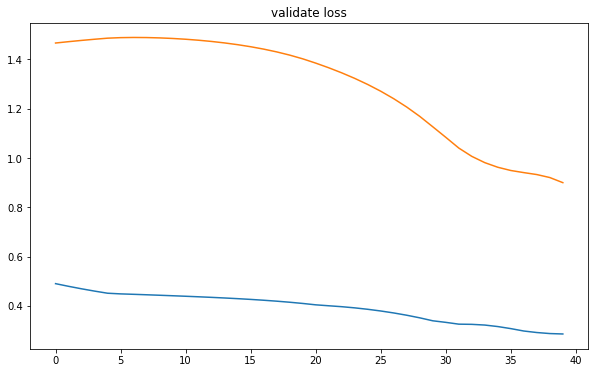

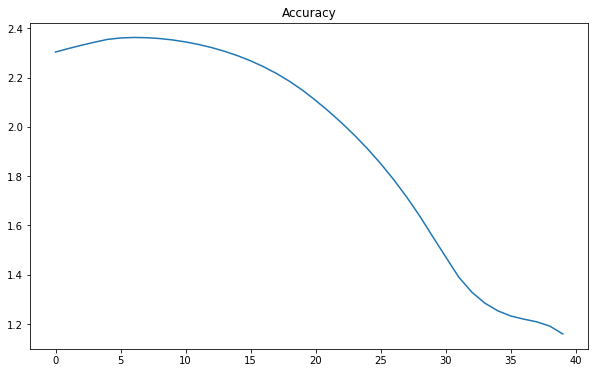

   pronostico
0    0.359963
1    0.383005
2    0.377341
3    0.122041
  ******  TUB0008   ******  
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_80 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 78ms/step - loss: 1.2199 - mse: 1.7391 - val_loss: 0.8551 - val_mse: 0.7569
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 1.1815 - mse: 1.6513 - val_loss: 0.7702 - val_mse: 0.6196
Epoch 3/40
1/1 [============

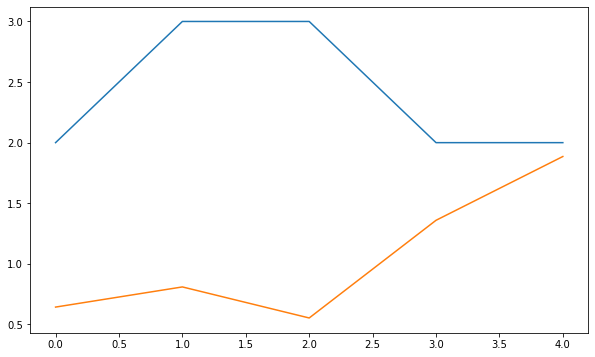

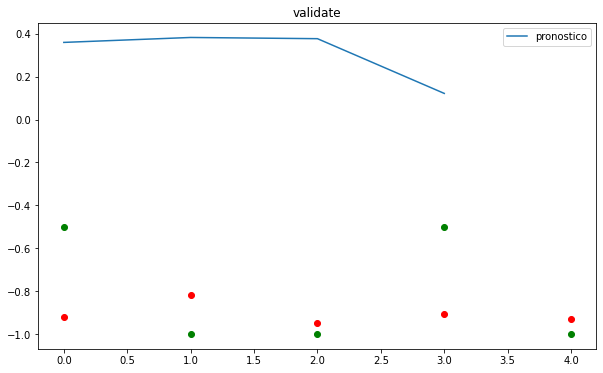

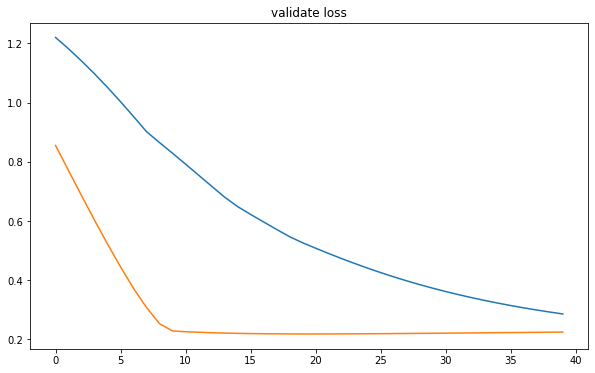

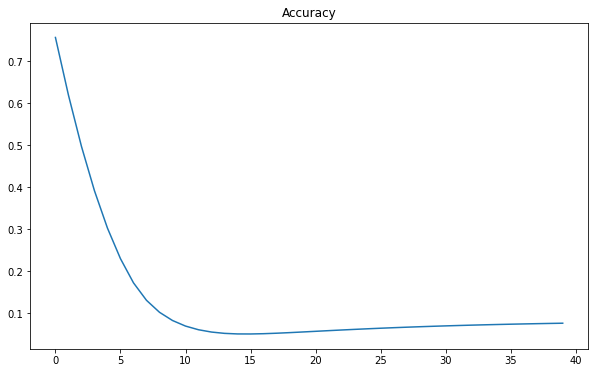

   pronostico
0    0.331030
1    0.091953
2    0.259562
3    0.597067
  ******  TUB0009   ******  
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_81 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_163 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4244 - mse: 0.3790 - val_loss: 0.3118 - val_mse: 0.1148
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.4131 - mse: 0.3859 - val_loss: 0.3202 - val_mse: 0.1258
Epoch 3/40
1/1 [============

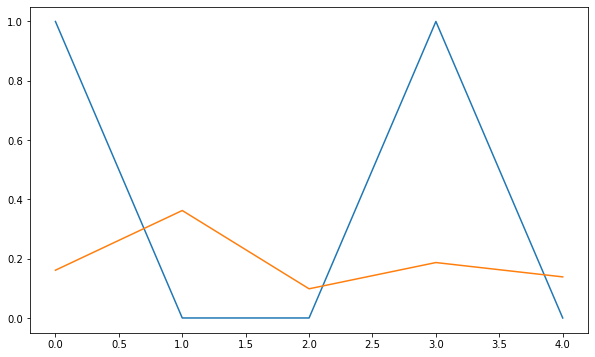

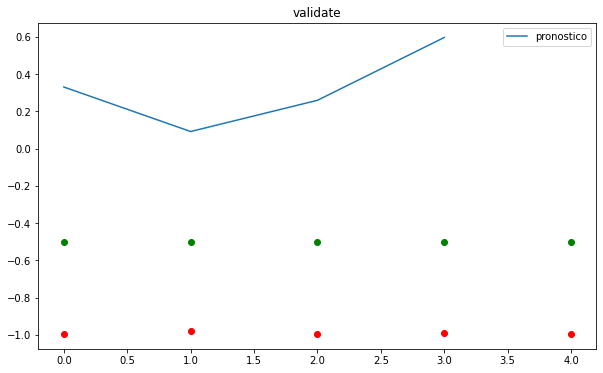

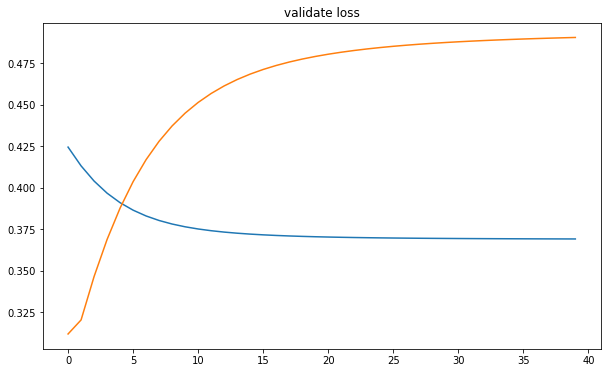

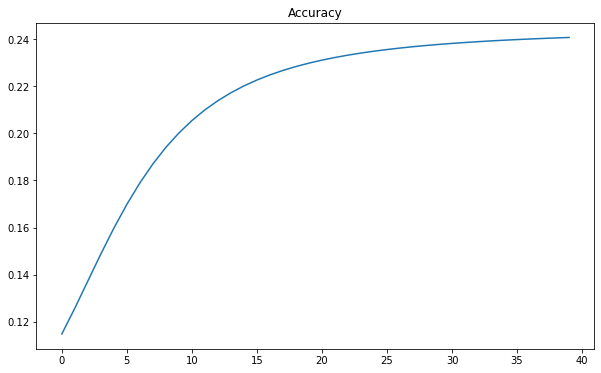

   pronostico
0    0.003633
1    0.005157
2    0.004568
3    0.003350
  ******  TUB0010   ******  
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_164 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_82 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.6566 - mse: 0.5822 - val_loss: 0.5772 - val_mse: 0.5332
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.6220 - mse: 0.5427 - val_loss: 0.6161 - val_mse: 0.6054
Epoch 3/40
1/1 [============

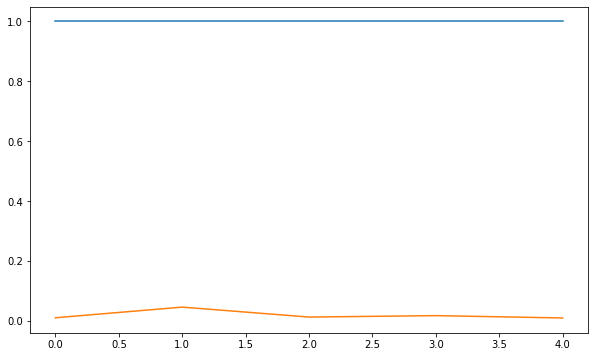

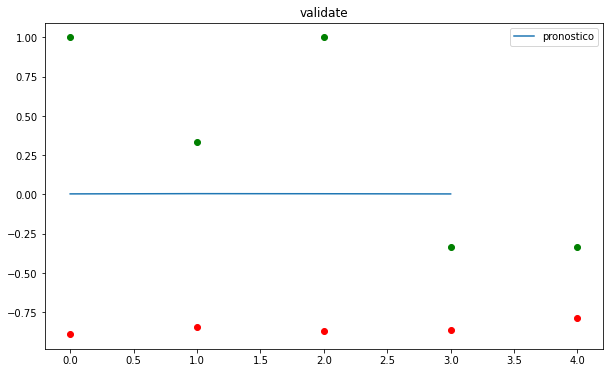

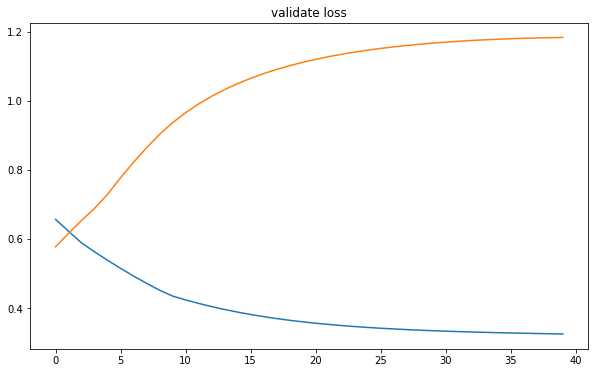

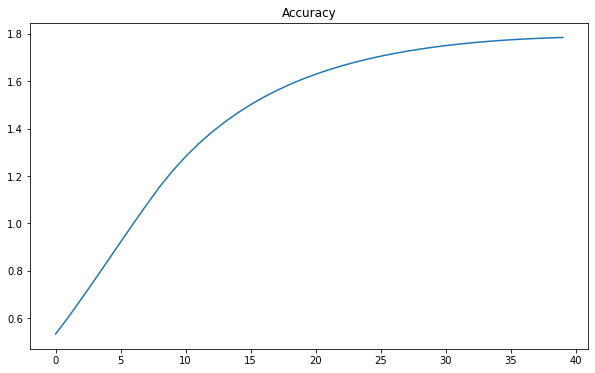

   pronostico
0    0.114410
1    0.009402
2    0.026848
3    0.034101
  ******  TUB0012   ******  
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_83 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 348ms/step - loss: 0.3757 - mse: 0.1800 - val_loss: 0.4957 - val_mse: 0.3299
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.3586 - mse: 0.1718 - val_loss: 0.5217 - val_mse: 0.3678
Epoch 3/40
1/1 [===========

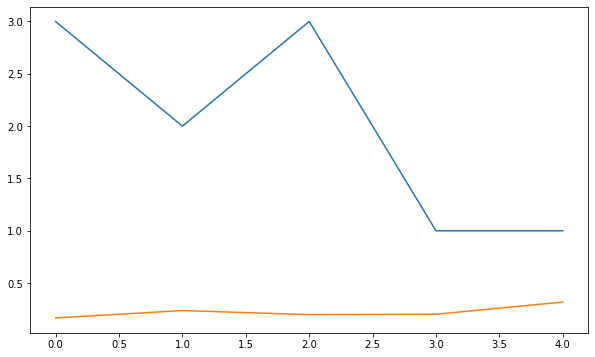

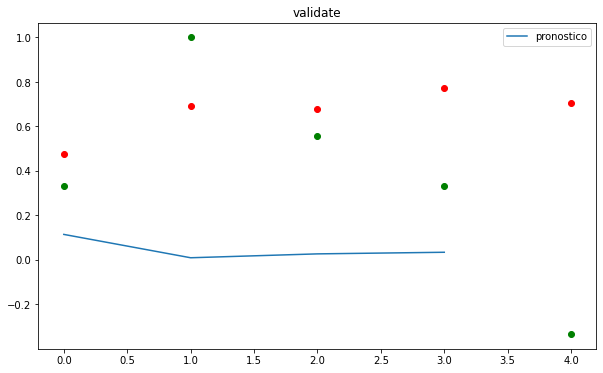

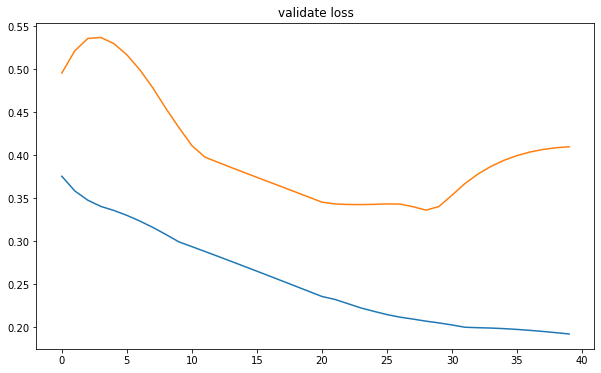

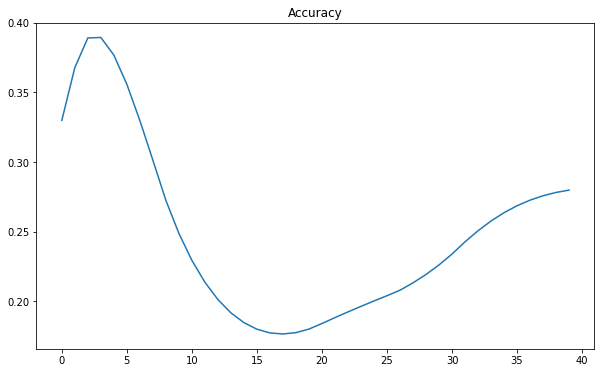

   pronostico
0    1.343216
1    0.854507
2    1.731363
3    1.606804
  ******  VER0003   ******  
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_168 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_84 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_169 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5951 - mse: 0.5182 - val_loss: 0.5698 - val_mse: 0.5440
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.5739 - mse: 0.4861 - val_loss: 0.5590 - val_mse: 0.4960
Epoch 3/40
1/1 [============

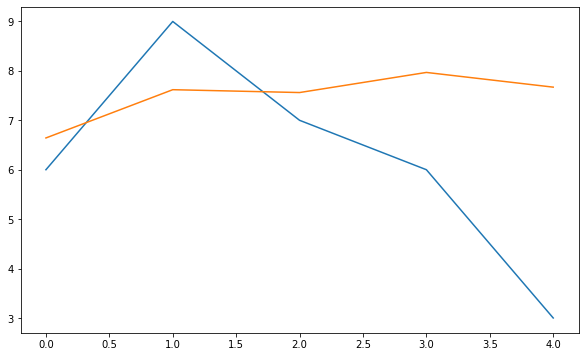

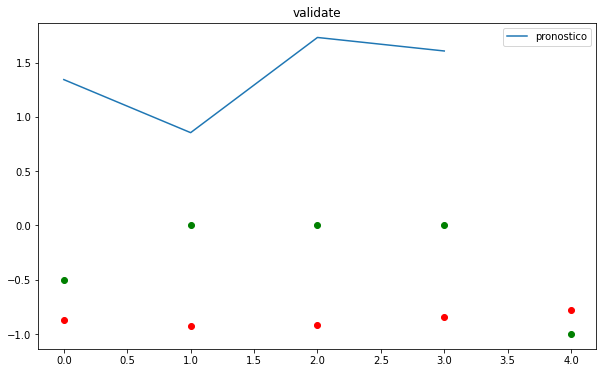

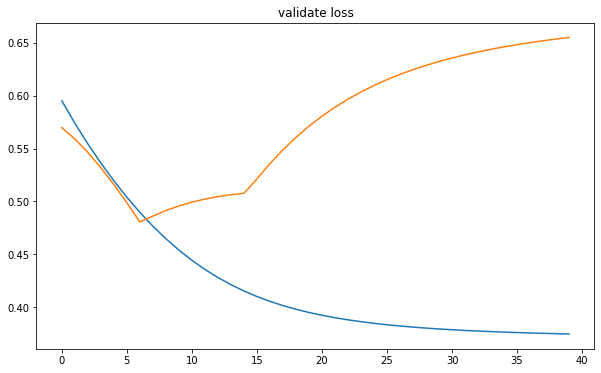

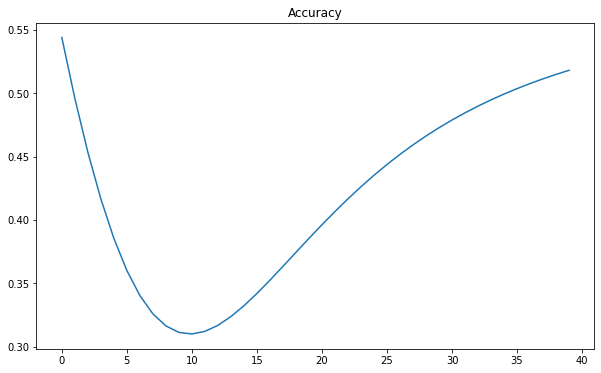

   pronostico
0    0.005417
1    0.094051
2    0.027268
3    0.026287
  ******  VER0005   ******  
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_170 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_85 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 89ms/step - loss: 0.6277 - mse: 0.6693 - val_loss: 0.6894 - val_mse: 0.7445
Epoch 2/40
1/1 [==============================] - 0s 21ms/step - loss: 0.6195 - mse: 0.6537 - val_loss: 0.6700 - val_mse: 0.7088
Epoch 3/40
1/1 [============

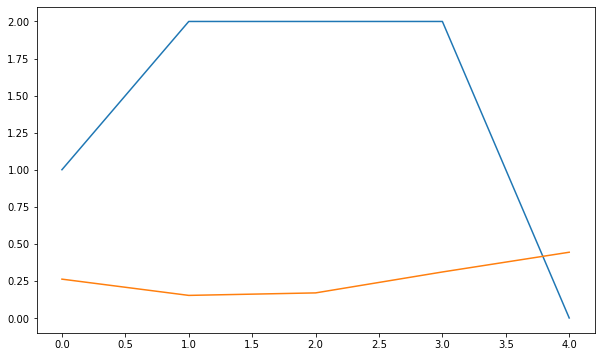

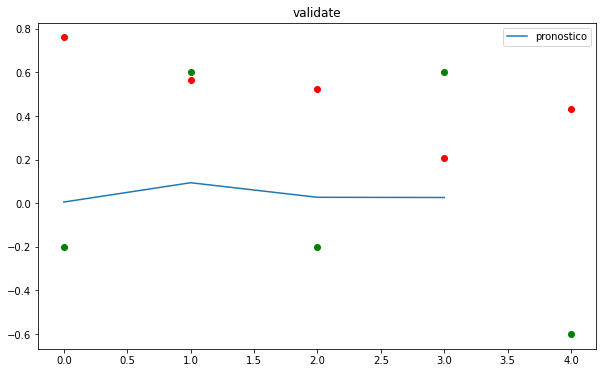

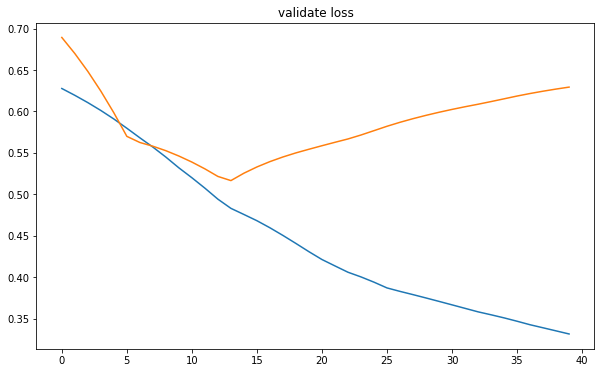

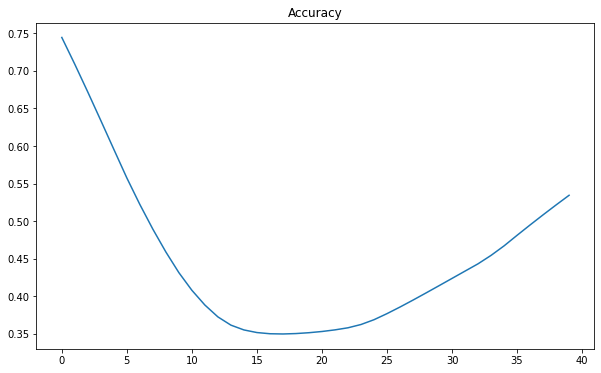

   pronostico
0    1.273114
1    0.794680
2    0.629544
3    0.895880
  ******  VER0006   ******  
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_172 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_86 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_173 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 79ms/step - loss: 0.9894 - mse: 1.2498 - val_loss: 0.7385 - val_mse: 0.7970
Epoch 2/40
1/1 [==============================] - 0s 24ms/step - loss: 0.9553 - mse: 1.1699 - val_loss: 0.7082 - val_mse: 0.7547
Epoch 3/40
1/1 [============

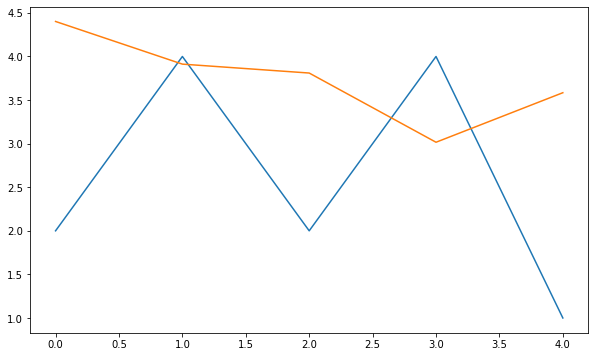

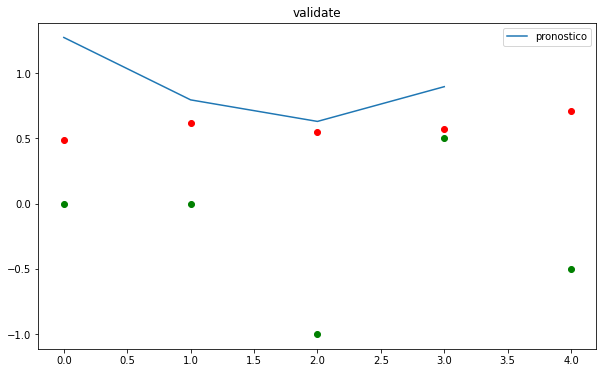

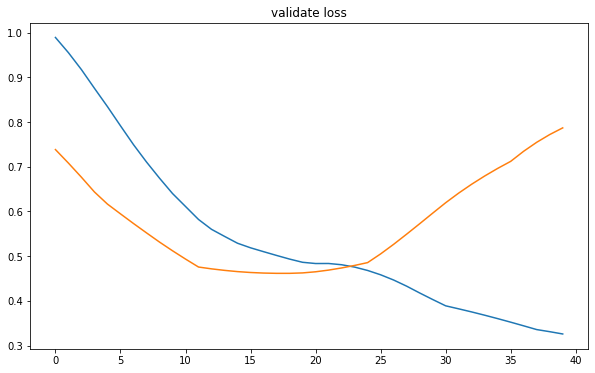

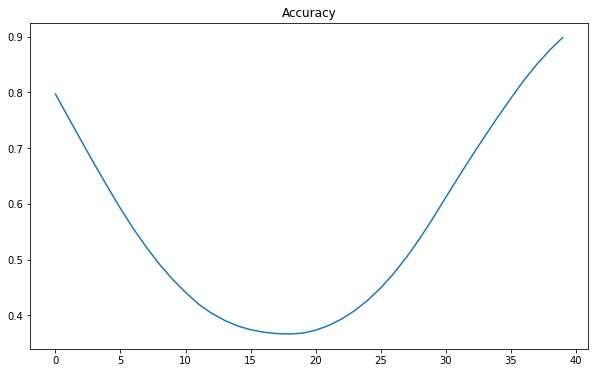

   pronostico
0    1.349325
1    0.802112
2    1.850465
3    1.143474
  ******  VER0007   ******  
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_174 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_87 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_175 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 76ms/step - loss: 0.5652 - mse: 0.4404 - val_loss: 0.6314 - val_mse: 0.4278
Epoch 2/40
1/1 [==============================] - 0s 21ms/step - loss: 0.5384 - mse: 0.4089 - val_loss: 0.6391 - val_mse: 0.4395
Epoch 3/40
1/1 [============

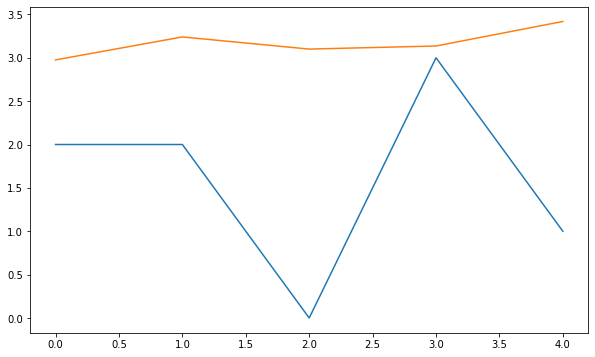

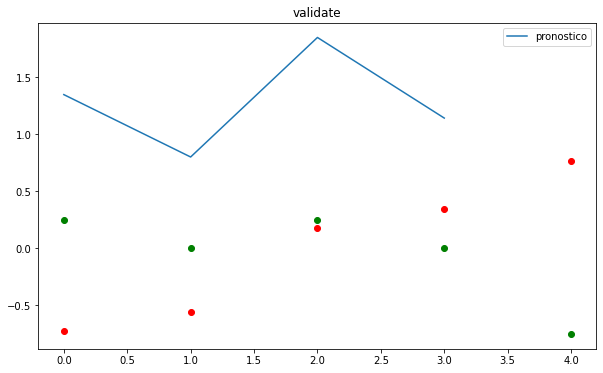

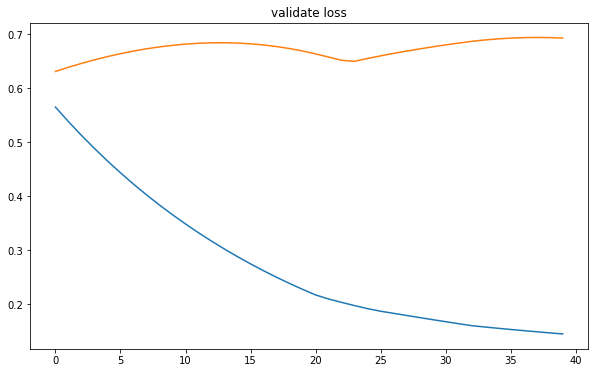

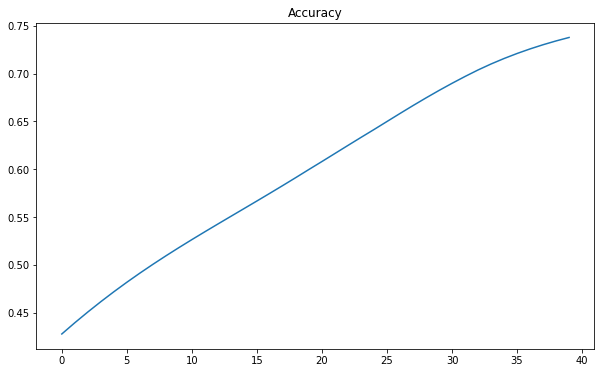

   pronostico
0    0.431975
1    0.034445
2    0.057582
3    0.070785
  ******  VER0009   ******  
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_88 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_177 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.6758 - mse: 0.6559 - val_loss: 0.4309 - val_mse: 0.2331
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.6644 - mse: 0.6437 - val_loss: 0.4272 - val_mse: 0.2289
Epoch 3/40
1/1 [============

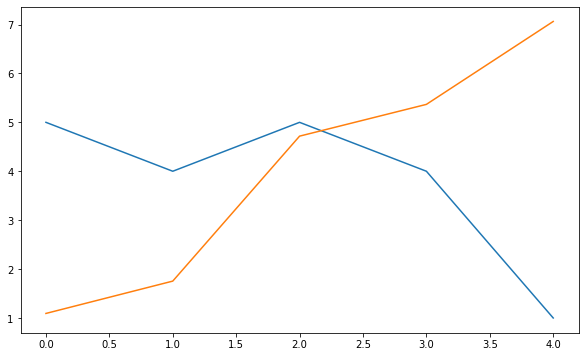

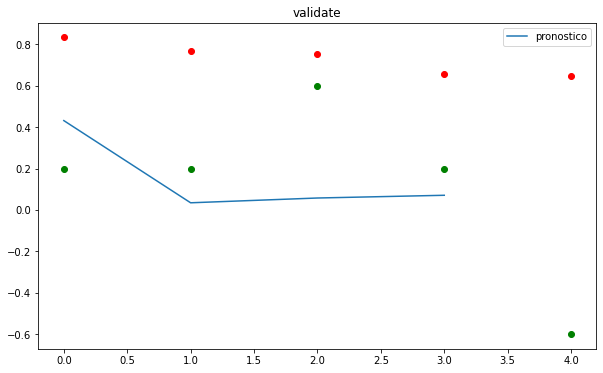

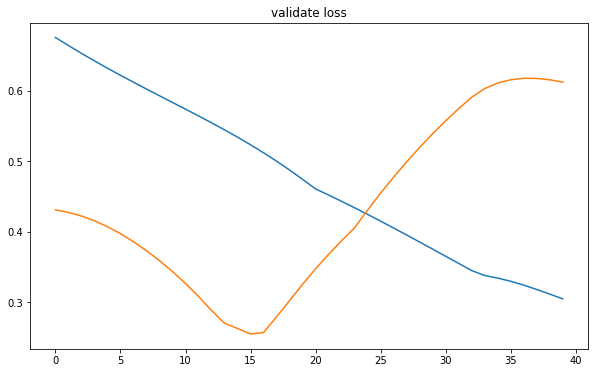

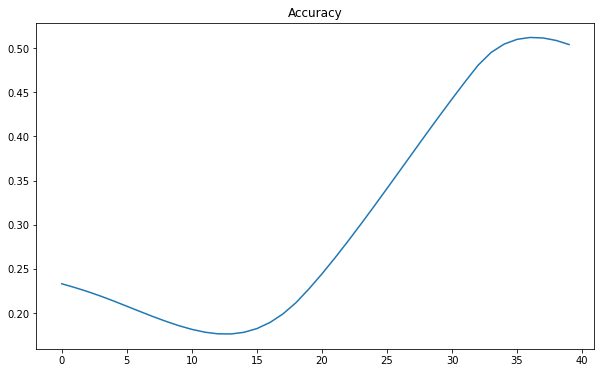

   pronostico
0    0.371069
1    0.579518
2    0.174276
3    0.525054
  ******  VER0010   ******  
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_178 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_89 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_179 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.8433 - mse: 0.8418 - val_loss: 0.8837 - val_mse: 0.8409
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.8095 - mse: 0.7921 - val_loss: 0.8801 - val_mse: 0.8355
Epoch 3/40
1/1 [============

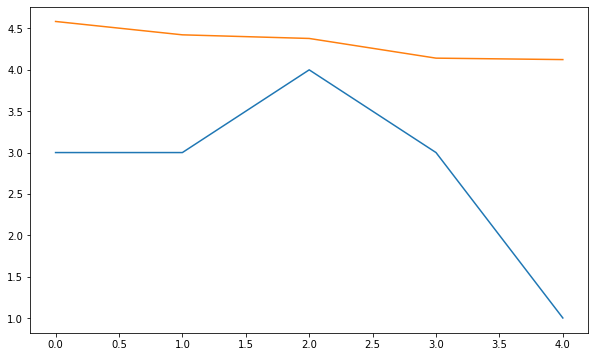

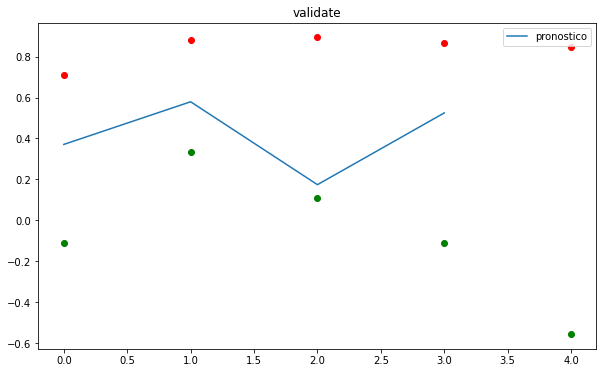

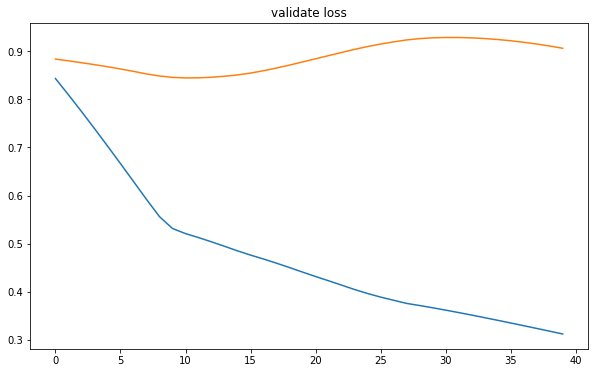

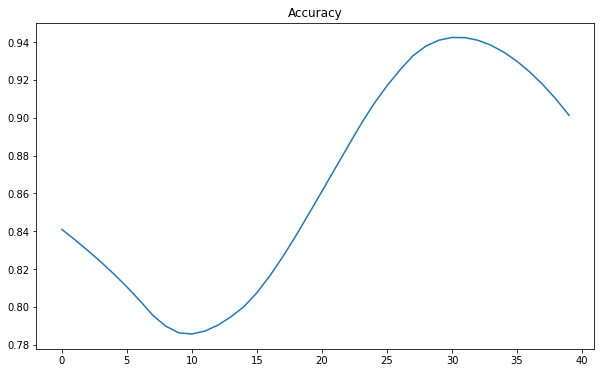

   pronostico
0    0.701643
1    1.476064
2    0.932428
3    1.344214
  ******  VER0012   ******  
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_90 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_181 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.8681 - mse: 0.8969 - val_loss: 0.7788 - val_mse: 0.7964
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.8228 - mse: 0.7987 - val_loss: 0.8123 - val_mse: 0.8169
Epoch 3/40
1/1 [============

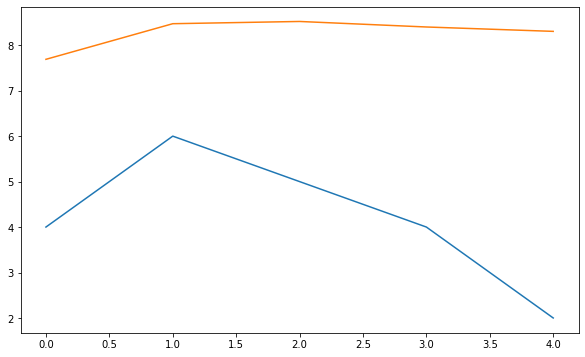

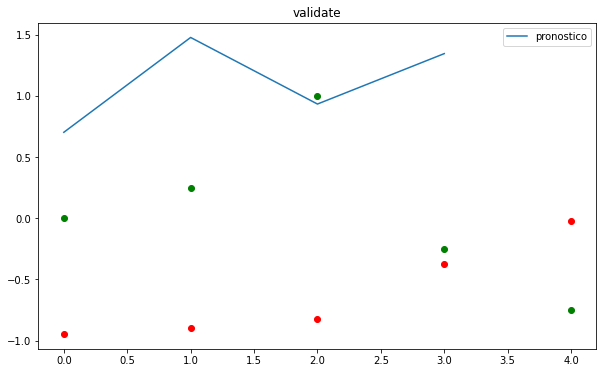

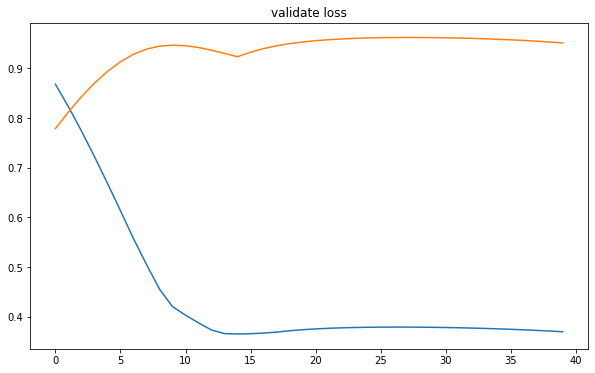

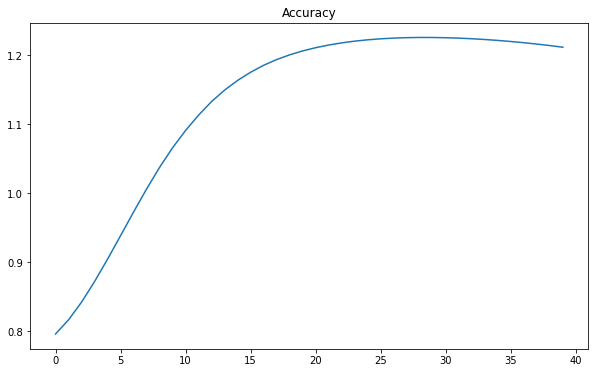

   pronostico
0    1.008061
1    0.224736
2    0.403986
3    1.292068
  ******  VER0013   ******  
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_182 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_91 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_183 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 1.2054 - mse: 1.7368 - val_loss: 0.7194 - val_mse: 0.7164
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 1.1867 - mse: 1.6847 - val_loss: 0.7300 - val_mse: 0.7070
Epoch 3/40
1/1 [============

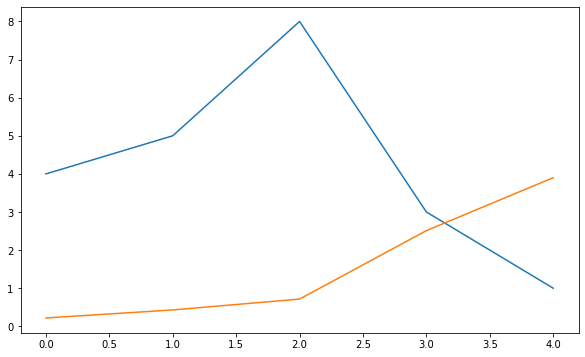

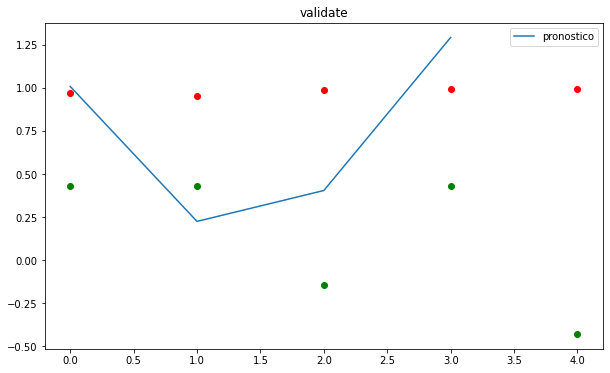

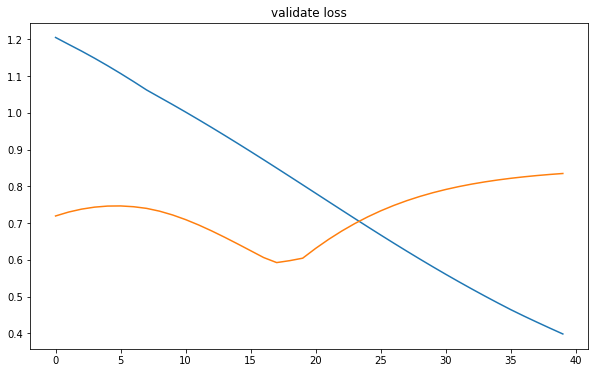

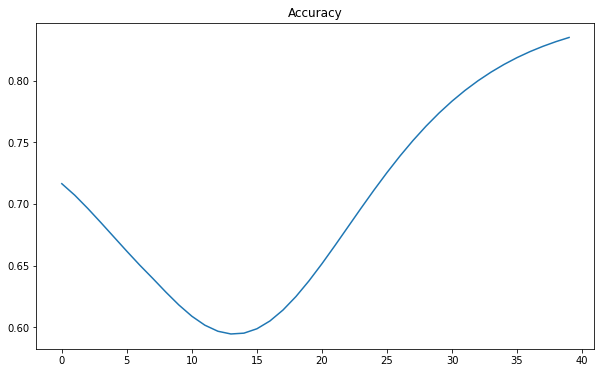

   pronostico
0    0.908936
1    1.271137
2    1.534718
3    1.067358
  ******  VER0014   ******  
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_184 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_92 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_185 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 335ms/step - loss: 0.7218 - mse: 0.6410 - val_loss: 0.4312 - val_mse: 0.2420
Epoch 2/40
1/1 [==============================] - 0s 21ms/step - loss: 0.6857 - mse: 0.5871 - val_loss: 0.4405 - val_mse: 0.2514
Epoch 3/40
1/1 [===========

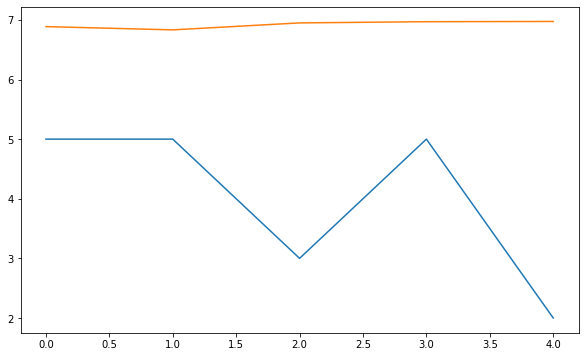

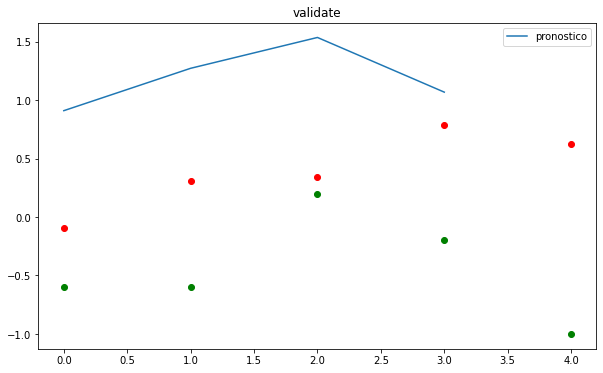

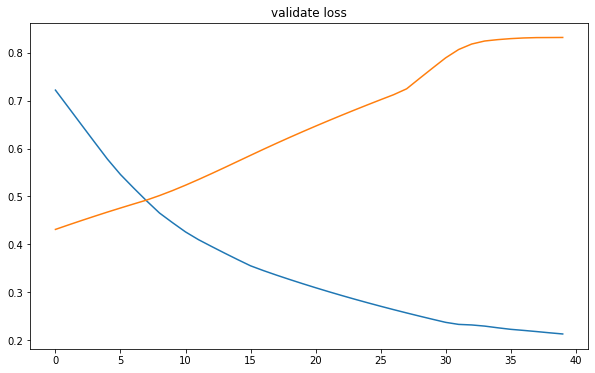

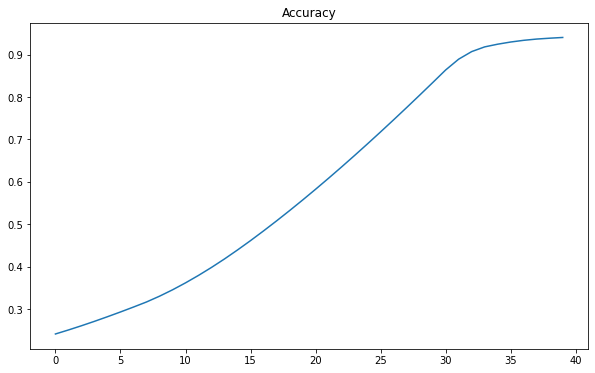

   pronostico
0    0.069808
1    0.181343
2    0.407470
3    0.309591
  ******  VER0016   ******  
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_93 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_187 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5184 - mse: 0.4084 - val_loss: 0.9078 - val_mse: 0.9516
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.5025 - mse: 0.3919 - val_loss: 0.8991 - val_mse: 0.9330
Epoch 3/40
1/1 [============

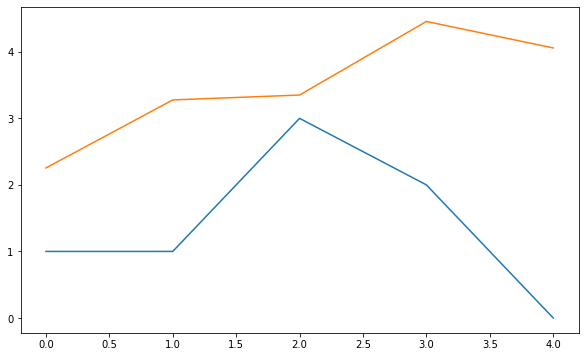

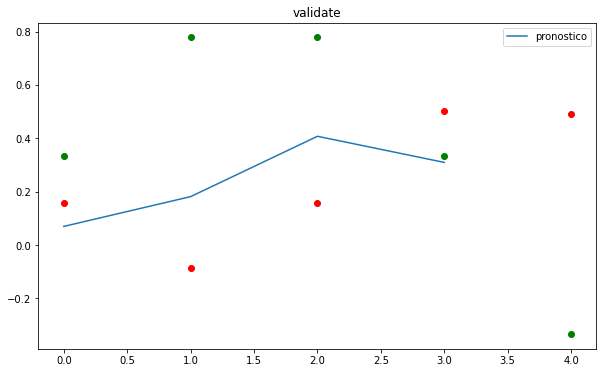

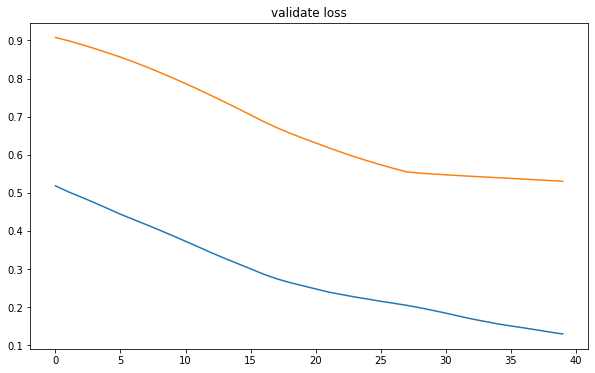

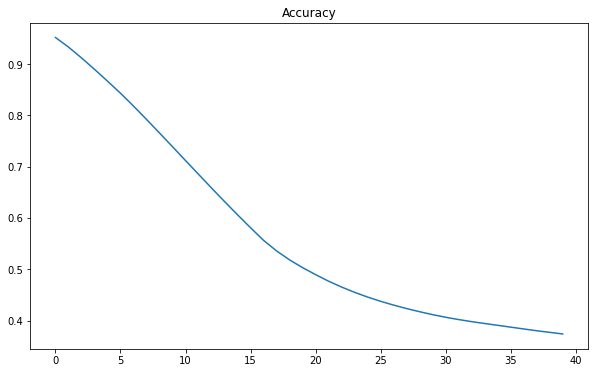

   pronostico
0    4.516234
1    4.930642
2    4.094555
3    4.081979
  ******  VER0017   ******  
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_188 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_94 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_189 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5736 - mse: 0.4585 - val_loss: 0.9601 - val_mse: 1.2851
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.5326 - mse: 0.4318 - val_loss: 0.9870 - val_mse: 1.3332
Epoch 3/40
1/1 [============

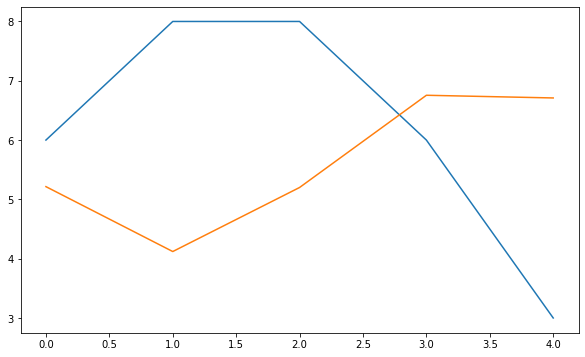

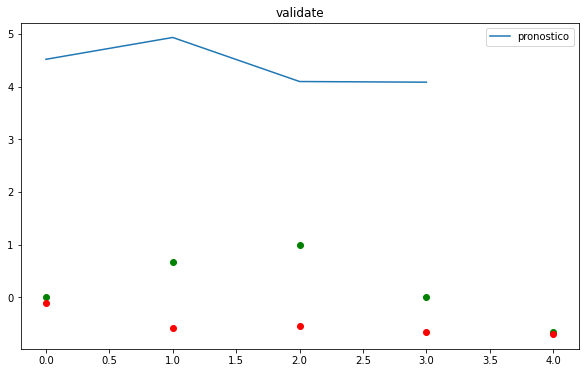

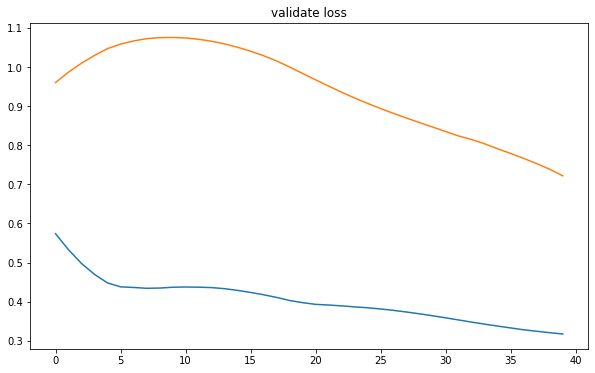

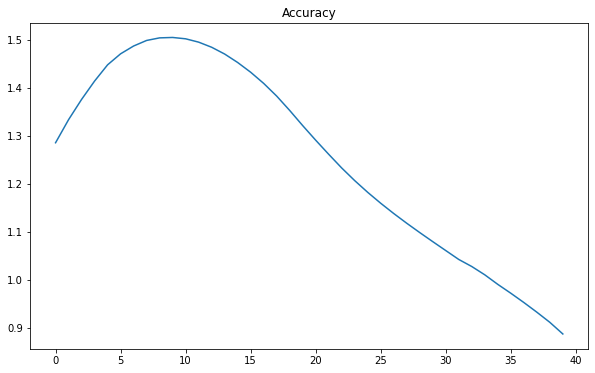

   pronostico
0    0.677547
1    0.486259
2    0.750377
3    1.810408
  ******  VER0020   ******  
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_190 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_95 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5465 - mse: 0.4355 - val_loss: 0.3247 - val_mse: 0.1854
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.5342 - mse: 0.4219 - val_loss: 0.3287 - val_mse: 0.1811
Epoch 3/40
1/1 [============

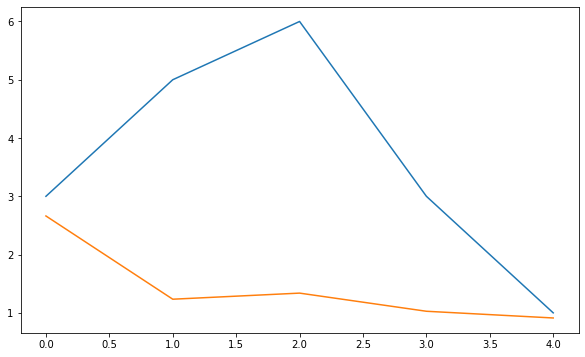

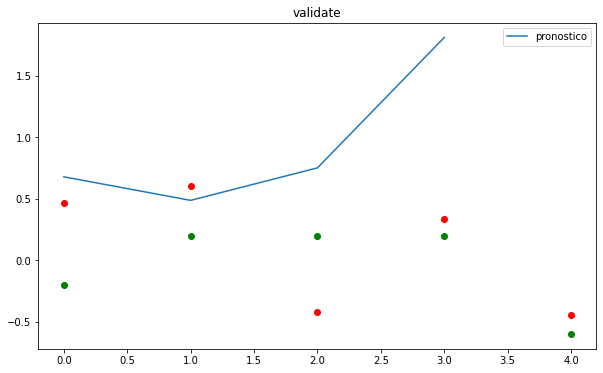

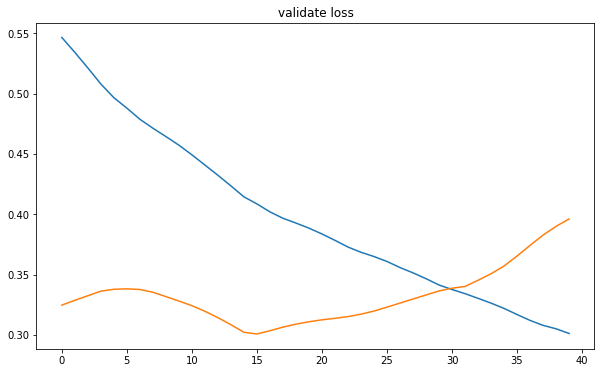

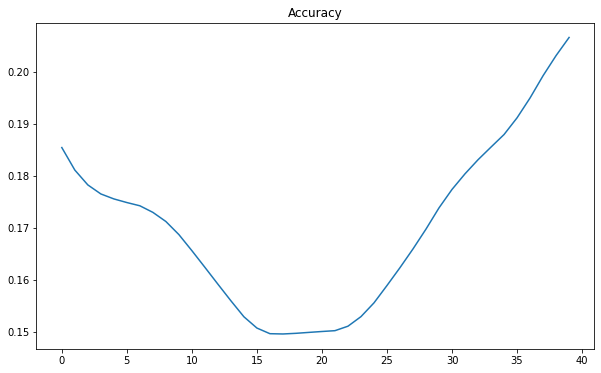

   pronostico
0    2.242523
1    0.974864
2    0.872957
3    1.803255
  ******  VER0024   ******  
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_96 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_193 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.8482 - mse: 0.9964 - val_loss: 1.0352 - val_mse: 1.3842
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.8257 - mse: 0.9605 - val_loss: 1.0108 - val_mse: 1.3450
Epoch 3/40
1/1 [============

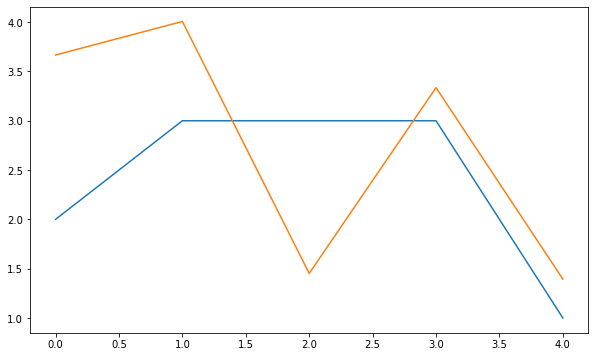

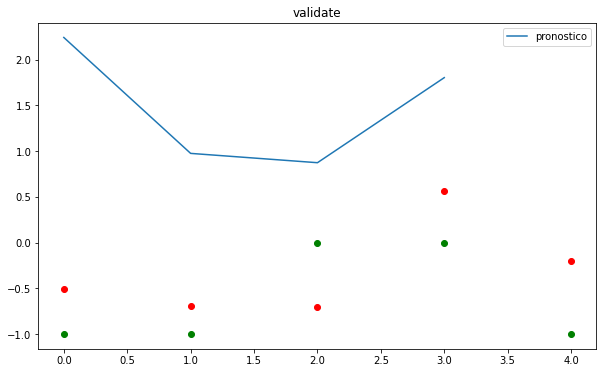

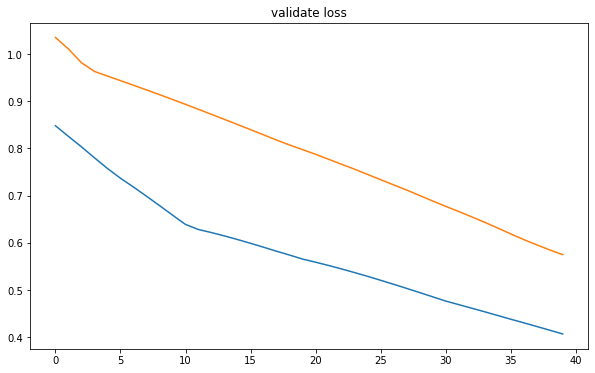

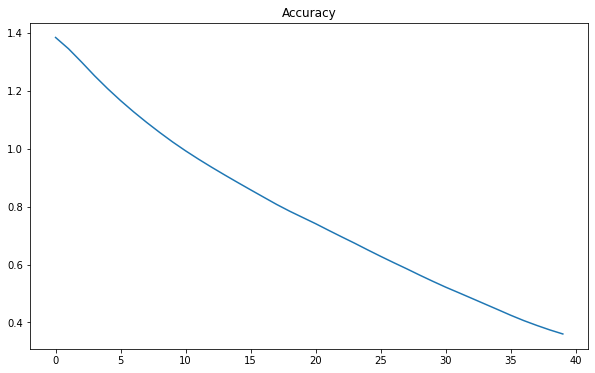

   pronostico
0    0.646048
1    0.015510
2    0.847243
3    1.246947
  ******  VER0028   ******  
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_194 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_97 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_195 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5189 - mse: 0.4096 - val_loss: 0.9202 - val_mse: 1.0063
Epoch 2/40
1/1 [==============================] - 0s 21ms/step - loss: 0.5054 - mse: 0.3976 - val_loss: 0.9122 - val_mse: 0.9933
Epoch 3/40
1/1 [============

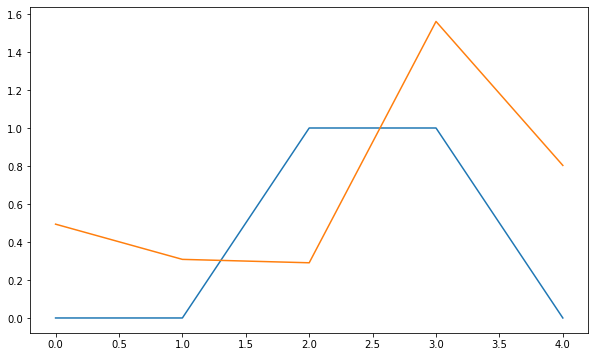

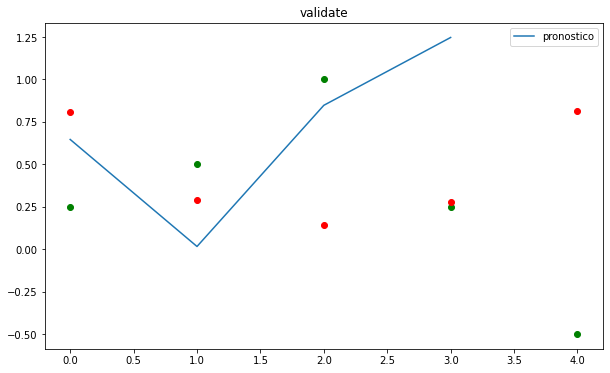

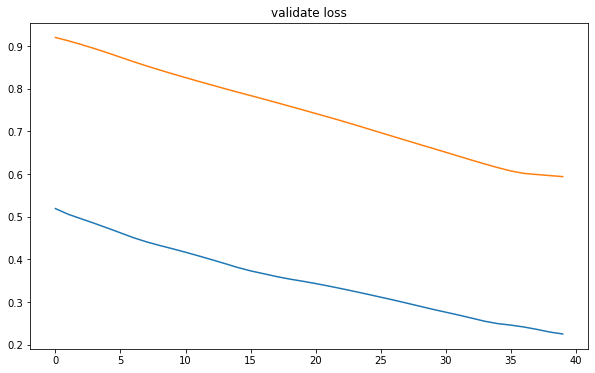

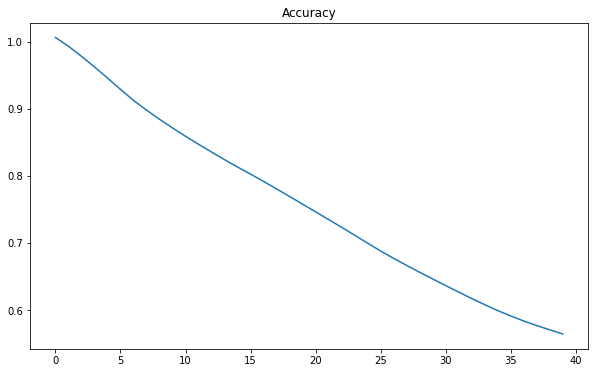

   pronostico
0    4.835927
1    4.928432
2    3.935932
3    2.769086
  ******  VER0033   ******  
Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_196 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_98 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_197 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.8905 - mse: 1.0320 - val_loss: 0.5690 - val_mse: 0.4697
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.8374 - mse: 0.9290 - val_loss: 0.5258 - val_mse: 0.3843
Epoch 3/40
1/1 [============

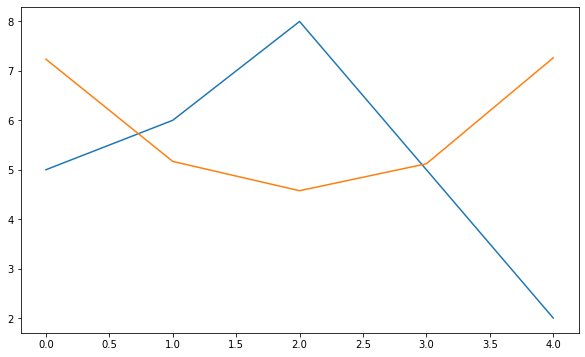

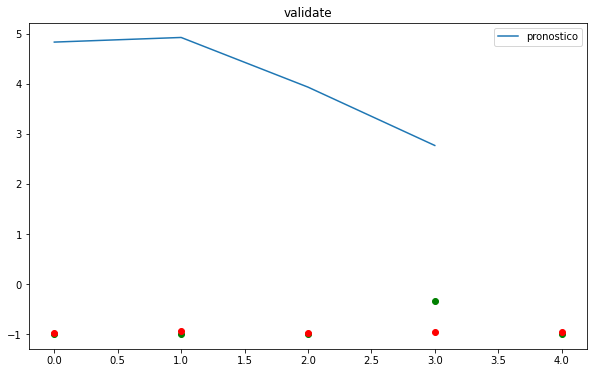

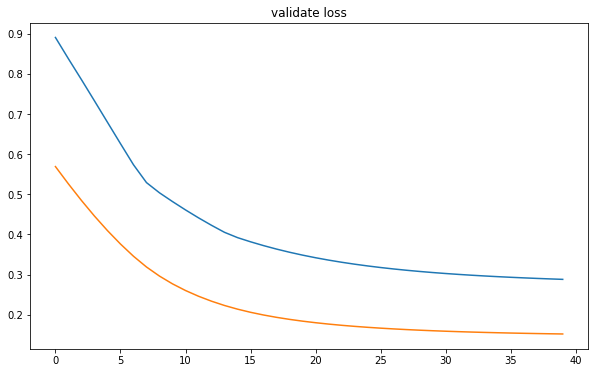

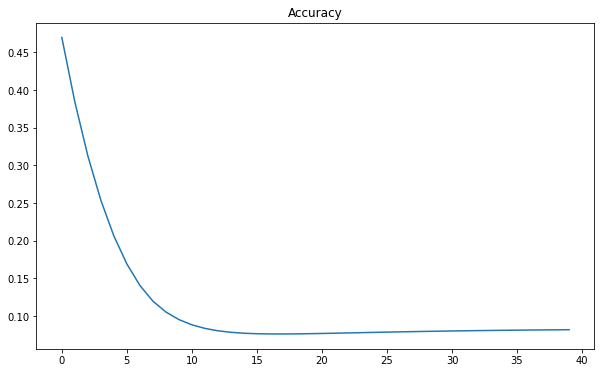

   pronostico
0    0.237491
1    0.072994
2    0.032118
3    0.091554
  ******  VER0035   ******  
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_198 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_99 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_199 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4466 - mse: 0.2905 - val_loss: 0.7700 - val_mse: 0.6664
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.4344 - mse: 0.2740 - val_loss: 0.7779 - val_mse: 0.6790
Epoch 3/40
1/1 [============

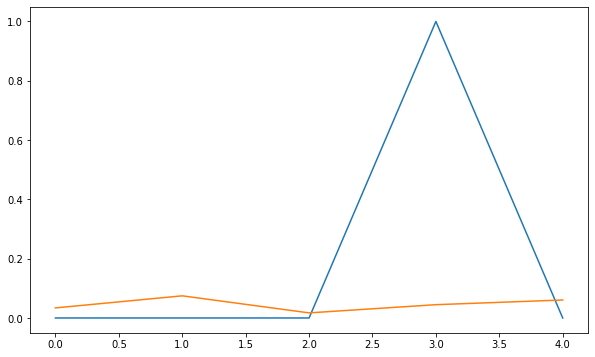

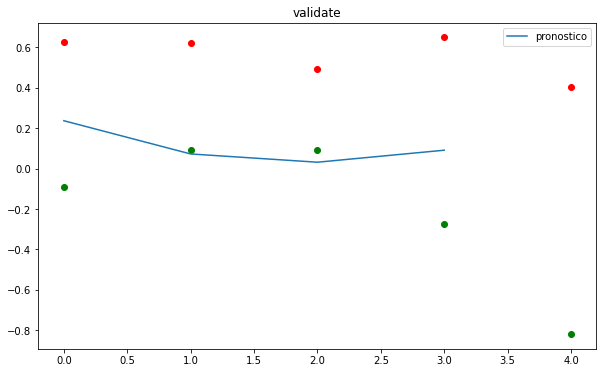

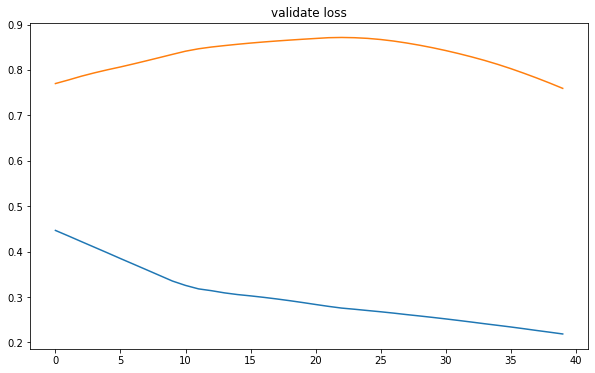

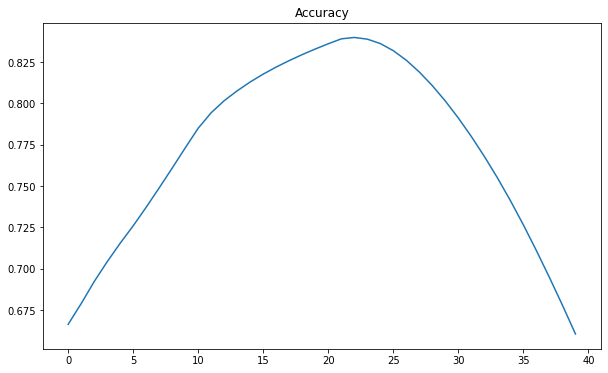

   pronostico
0    2.140135
1    1.488131
2    2.308337
3    2.345147
  ******  VER0037   ******  
Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_100 (Flatten)        (None, 24)                0         
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4258 - mse: 0.2995 - val_loss: 0.6707 - val_mse: 0.6773
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.3997 - mse: 0.2694 - val_loss: 0.6487 - val_mse: 0.6512
Epoch 3/40
1/1 [===========

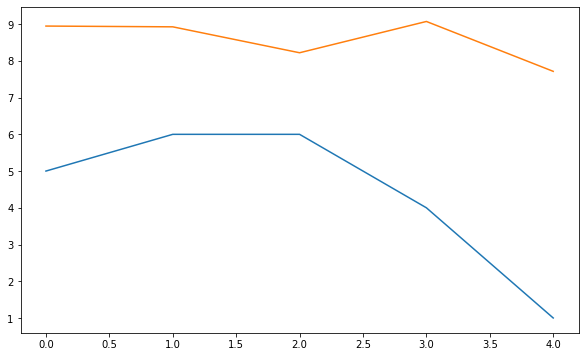

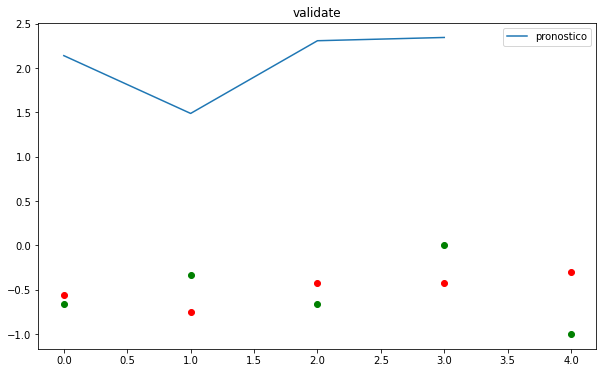

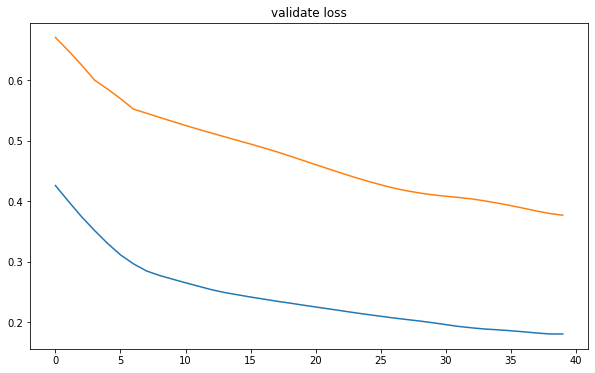

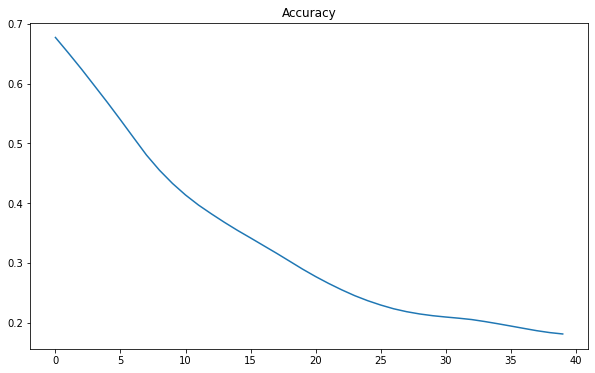

   pronostico
0    0.488455
1    0.331610
2    0.158442
3    0.312715
  ******  VER0038   ******  
Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_202 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_101 (Flatten)        (None, 24)                0         
_________________________________________________________________
dense_203 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 332ms/step - loss: 0.9005 - mse: 0.9210 - val_loss: 0.8534 - val_mse: 0.8514
Epoch 2/40
1/1 [==============================] - 0s 21ms/step - loss: 0.8705 - mse: 0.8695 - val_loss: 0.8536 - val_mse: 0.8531
Epoch 3/40
1/1 [==========

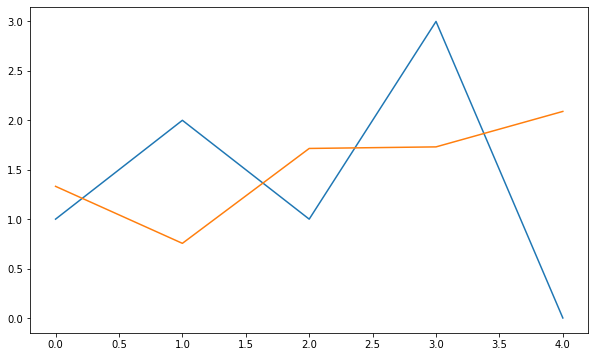

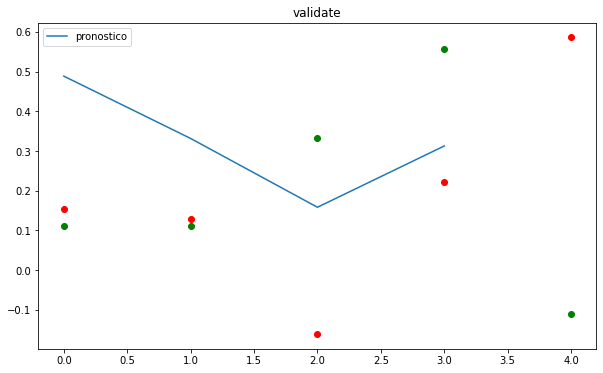

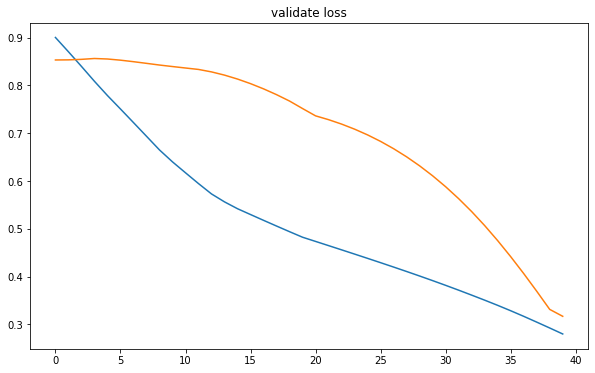

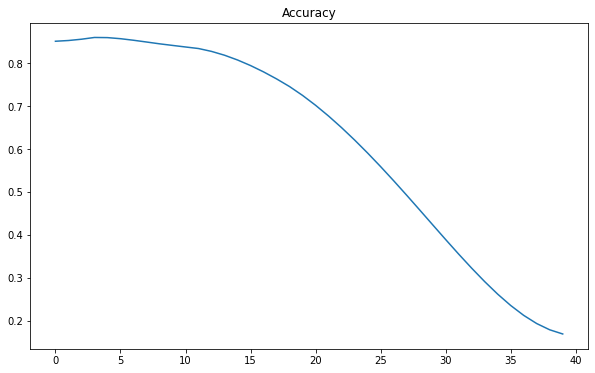

   pronostico
0    1.160879
1    0.779250
2    1.045647
3    2.657614
  ******  VER0043   ******  
Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_102 (Flatten)        (None, 24)                0         
_________________________________________________________________
dense_205 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.3976 - mse: 0.1958 - val_loss: 0.4517 - val_mse: 0.3752
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.3872 - mse: 0.1845 - val_loss: 0.4560 - val_mse: 0.3633
Epoch 3/40
1/1 [===========

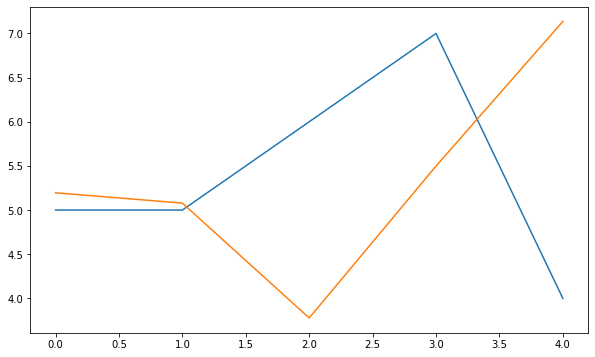

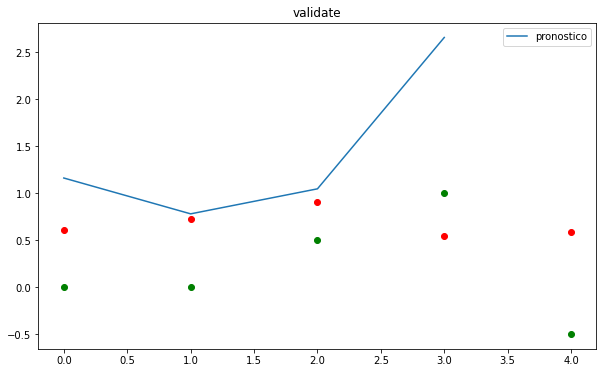

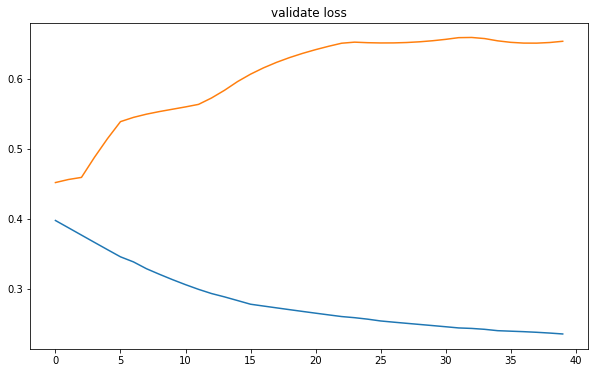

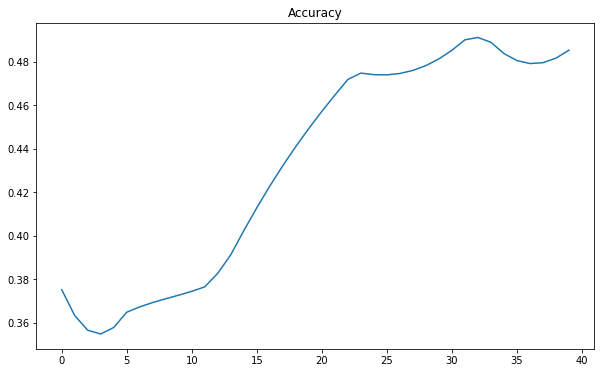

   pronostico
0    0.332425
1    0.340947
2    0.354864
3    0.432012
  ******  VER0049   ******  
Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_206 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_103 (Flatten)        (None, 24)                0         
_________________________________________________________________
dense_207 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4743 - mse: 0.3120 - val_loss: 0.3230 - val_mse: 0.1269
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.4422 - mse: 0.2752 - val_loss: 0.3015 - val_mse: 0.1093
Epoch 3/40
1/1 [===========

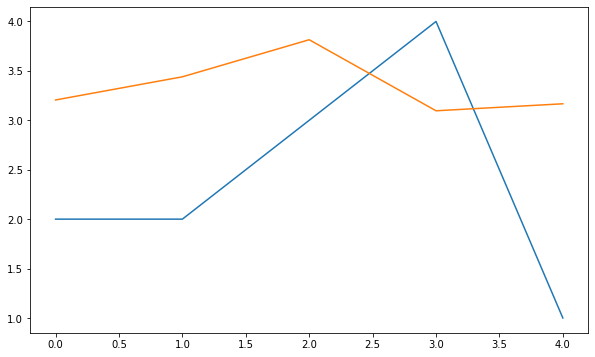

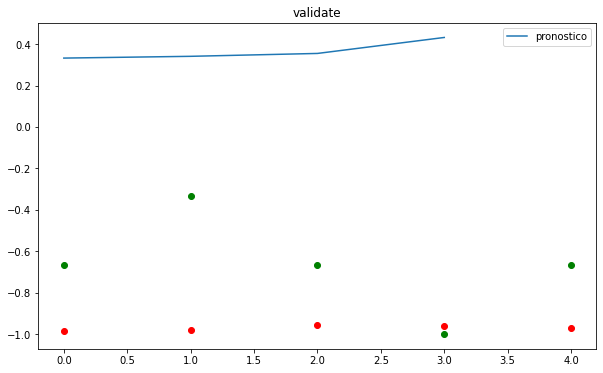

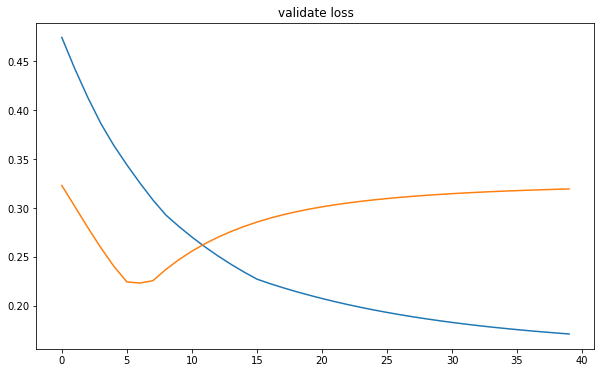

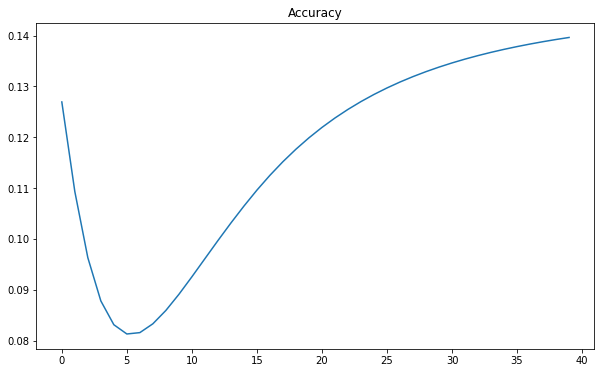

   pronostico
0    0.223453
1    0.196840
2    0.356345
3    0.618866
  ******  VER0050   ******  
Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_208 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_104 (Flatten)        (None, 24)                0         
_________________________________________________________________
dense_209 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4650 - mse: 0.5907 - val_loss: 0.8539 - val_mse: 0.8966
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.4542 - mse: 0.5687 - val_loss: 0.8930 - val_mse: 0.9532
Epoch 3/40
1/1 [===========

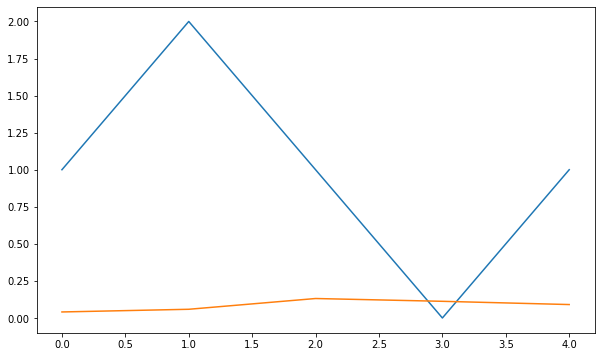

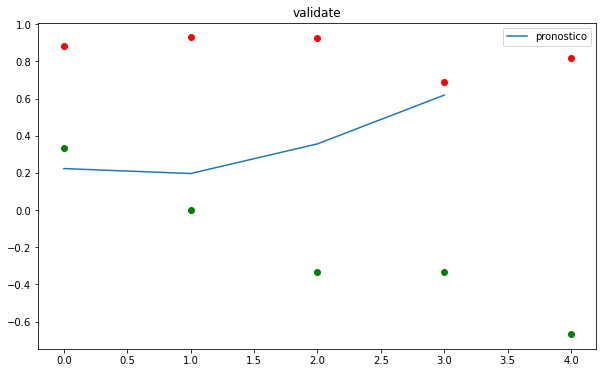

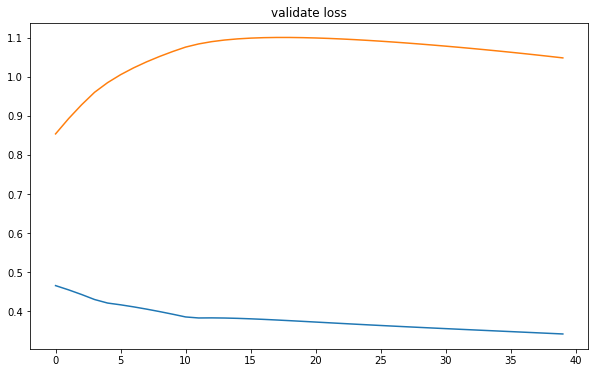

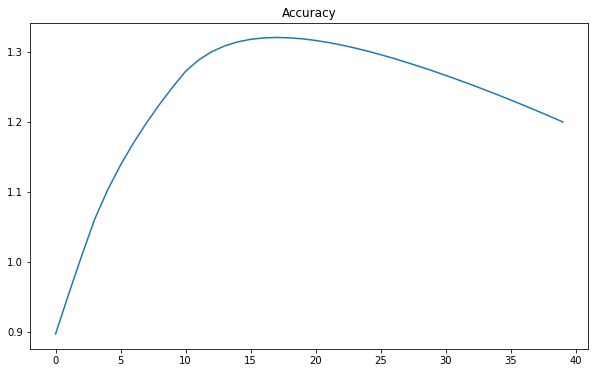

   pronostico
0    0.197498
1    0.073706
2    0.139645
3    0.305193
  ******  VER0051   ******  
Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_210 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_105 (Flatten)        (None, 24)                0         
_________________________________________________________________
dense_211 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.6586 - mse: 0.5572 - val_loss: 0.7928 - val_mse: 0.7147
Epoch 2/40
1/1 [==============================] - 0s 23ms/step - loss: 0.6203 - mse: 0.5027 - val_loss: 0.7478 - val_mse: 0.6489
Epoch 3/40
1/1 [===========

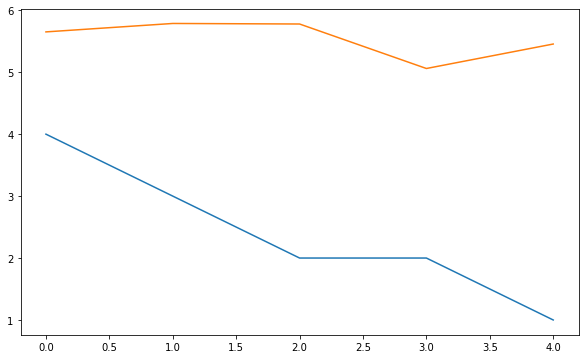

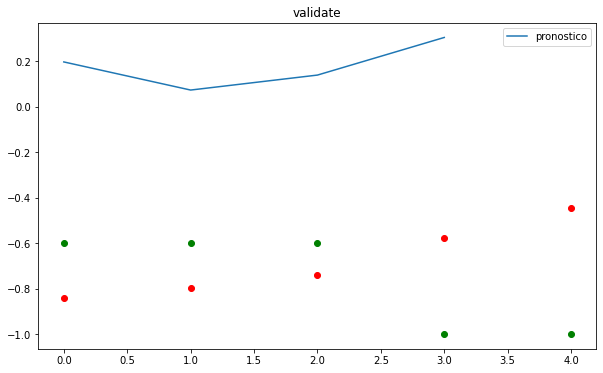

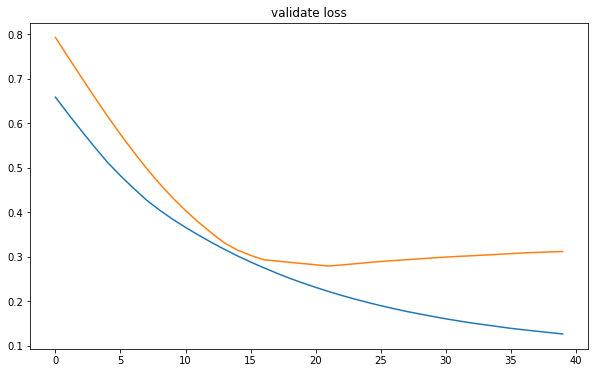

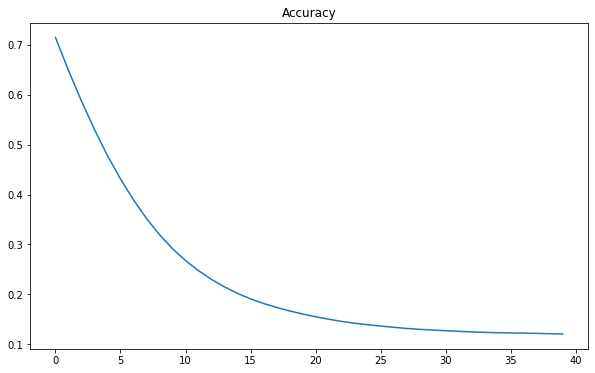

   pronostico
0    0.067309
1    0.057808
2    0.153119
3    0.106776
  ******  VER0052   ******  
Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 1, 24)             600       
_________________________________________________________________
flatten_106 (Flatten)        (None, 24)                0         
_________________________________________________________________
dense_213 (Dense)            (None, 1)                 25        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5236 - mse: 0.3748 - val_loss: 0.6914 - val_mse: 0.6615
Epoch 2/40
1/1 [==============================] - 0s 22ms/step - loss: 0.4675 - mse: 0.3494 - val_loss: 0.7005 - val_mse: 0.7173
Epoch 3/40
1/1 [===========

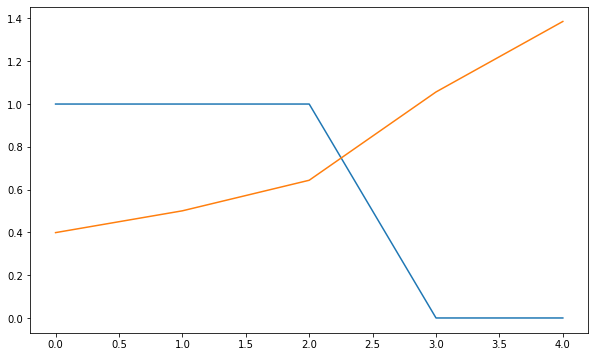

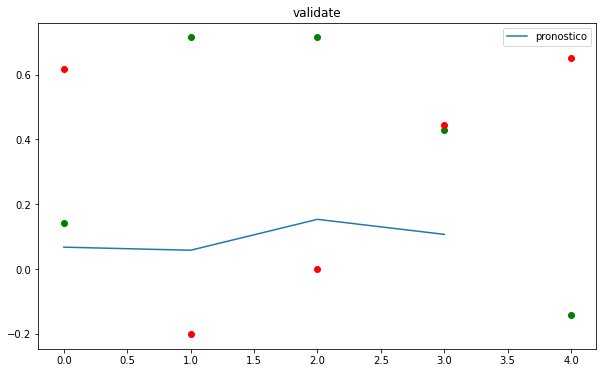

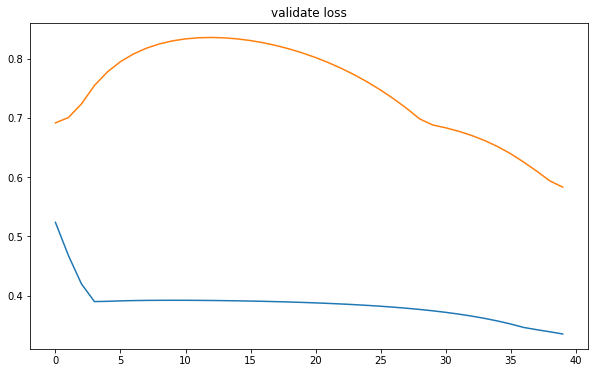

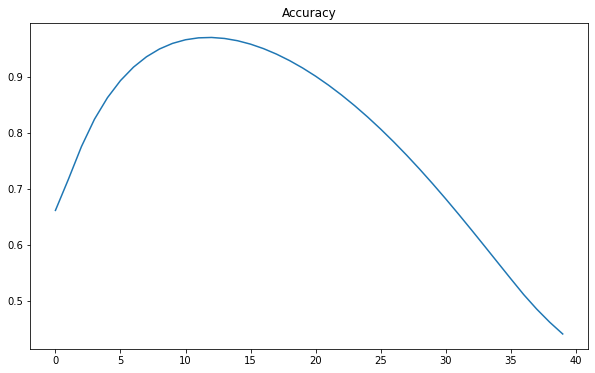

   pronostico
0    0.800427
1    0.844011
2    1.324773
3    1.092254


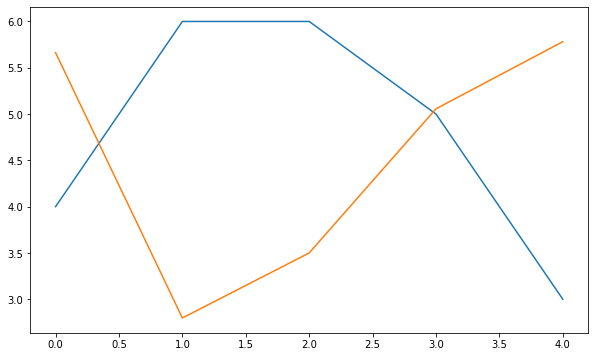

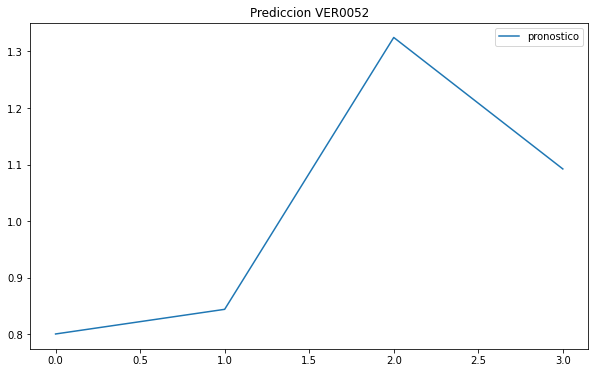

In [74]:
PASOS=24

for i in range(1,ventas_producto.shape[1]-1):
    colname = ventas_producto.columns[i]
    print("  ******  " + colname + "   ******  ")
    # load dataset
    df = pd.read_csv(colname + ".txt",delimiter="\t", parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades'])
    values = df.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, PASOS, 1)

    # split into train and test sets (80% - 20%)
    values = reframed.values
    N = values.shape[0]
    n_train = round(N*0.8)
    train = values[:n_train, :]
    test = values[n_train:, :]
    # split into input and outputs
    x_train, y_train = train[:, :-1], train[:, -1]
    x_val, y_val = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

    EPOCHS=40
    # Se crea el modelo Feed Forward
    model = crear_modeloFF()
    
    # Se entrena el modelo
    history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)    
    
    # Se valida
    results=model.predict(x_val)
    plt.scatter(range(len(y_val)),y_val,c='g')
    plt.scatter(range(len(results)),results,c='r')
    plt.title('validate')
    plt.show()

    # Validacion de la pérdida
    plt.plot(history.history['loss'])
    plt.title('loss')
    plt.plot(history.history['val_loss'])
    plt.title('validate loss')
    plt.show()    

    # Validacion del desempeño
    plt.title('Accuracy')
    plt.plot(history.history['val_mse'])
    plt.show()    
    
    # Se compara y se reescala
    compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
    compara.columns = ['real', 'prediccion']
    inverted = scaler.inverse_transform(compara.values)
    compara2 = pd.DataFrame(inverted)
    compara2.columns = ['real', 'prediccion']
    compara2['diferencia'] = compara2['real'] - compara2['prediccion']
    compara2['real'].plot()
    compara2['prediccion'].plot()
    
    #Se realiza la predicción
    ultimos_datos = df.tail(PASOS*2)    
    
    #Se preparan los datos para prueba
    values = ultimos_datos.values
    values = values.astype('float32')
    # normalize features
    values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[PASOS]], axis=1, inplace=True)
    
    values = reframed.values
    x_test = values[7:, :]
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    
    # Se hacen la predicción para las próximas semanas
    results=[]
    for i in range(4):
        parcial=model.predict(x_test)
        results.append(parcial[0])
        x_test=agregarNuevoValor(x_test,parcial[0])
        
    
    adimen = [x for x in results]    
    inverted = scaler.inverse_transform(adimen)
    
    prediccion = pd.DataFrame(inverted)
    prediccion.columns = ['pronostico']
    prediccion.plot(title='Prediccion ' + colname)
    prediccion.to_csv('pronostico_' + colname  + '.csv')
    print(prediccion)

## Conclusiones  

<ul>
<li> Teniendo en cuenta la pregunta de negocio: ¿Qué cantidad de cada producto se debe solicitar para la próxima semana?, se implementaron dos metodologías de pronóstico, la primera mediante el paquete prophet y la segunda mediante redes neuronales usando el paquete keras.       
    </li>    
    <li>Si bien la red neuronal ofrece mayor flexibilidad de parametrización, resulta más compleja de ajustar dado la cantidad y homogeneidad de productos. Por tanto en términos de implementación y escalabilidad, prophet resulta una alternativa más sencilla de implementar.  
    </li>
    <li> En la Figura se muestra como el inventario de productos a solicitar disminuye de 121 productos inicialmente ofertados a 52 en el caso de la red neuronal y 43 en el caso de prophet.  De acuerdo al registro histórico de lo vendido en la última semana, se presentará a la start-up dos escenarios: el conservador estimado a través de la red neuronal y el optimista estimado a través de prophet. 
    </li>
    <li>Teniendo en cuenta el estado financiero de la start-up la decisión de cuál de las dos alternativas elegir, estará relacionada al perfil de tolerancia al riesgo y estrategias de crecimiento de la compañía. 
    </li>
    <li> Se propone entonces como alternativa de crecimiento, diseñar paquetes de productos de alta rotación combinados con los de baja rotación para estimular el consumo de los segundos.
    </li>
    <li> Si bien en la fase de exploración de datos, se modelo la demanda total de productos por semana mediante un modelo ARIMA, se decidió no implementar esta metodología para los 52 productos escogidos ya que de acuerdo con la base de datos, los productos tienen un comportamiento de demanda distinto y esto hace dispendioso y poco eficiente el modelado de de cada serie de manera individual. 
    </li>
</ul>
